### E10S Experiment Aurora (all histograms)

This analysis compares all non-keyed histograms between the control and experiment branch.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from collections import defaultdict
from __future__ import division
from itertools import groupby
from operator import itemgetter

from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from moztelemetry.histogram import Histogram
from mozaggregator.aggregator import _aggregate_ping, _aggregate_aggregates, _trim_payload, simple_measures_labels, count_histogram_labels


%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

160

#### Get e10s and non-e10s partitions

In [3]:
def is_in_e10s_experiment(ping):
    try:
        experiment = ping["environment"]["addons"]["activeExperiment"]
        return experiment["id"] == "e10s-enabled-aurora-20151020@experiments.mozilla.org" and \
               (experiment["branch"] == "control" or experiment["branch"] == "experiment")   
    except:
        return False
    
def sample_by_client_id(ping):
    sample_id = ping["meta"]["sampleId"]
    return sample_id < 50

In [7]:
pings = get_pings(sc, app="Firefox", channel="aurora", version="43.0a2", submission_date=("20151023", "20151030"))\
        .filter(is_in_e10s_experiment)\
        .filter(sample_by_client_id)

How many pings do we have in each branch?

In [8]:
pings.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
     .reduceByKey(lambda x, y: x + y)\
     .collect()

[(u'control', 244546), (u'experiment', 249337)]

Get a single ping for each client, but make sure it's not the first one as the experiment branch will not be enforced until the next restart

In [9]:
first_ping_of_client = \
      pings.map(lambda p: (p["clientId"], p))\
     .reduceByKey(lambda x, y: x if x["meta"]["creationTimestamp"] < y["meta"]["creationTimestamp"] else y)\
     .map(lambda p: (p[0], p[1]["meta"]["documentId"]))\
     .collectAsMap()

In [10]:
def not_first(ping):
    return not ping["meta"]["documentId"] in first_ping_of_client[ping["clientId"]]

subset = get_one_ping_per_client(pings.filter(not_first))

How many clients do we have in each branch?

In [11]:
subset.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
      .reduceByKey(lambda x, y: x + y)\
      .collect()

[(u'control', 19598), (u'experiment', 19816)]

## Histograms

In [20]:
def chi2_distance(histA, histB, eps = 1e-10, normalize = True):    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d


def compare_histogram(histogram, e10s, none10s): 
    eTotal = e10s["histogram"]
    nTotal = none10s["histogram"]
    
    if e10s["count"] < 5000 or none10s["count"] < 5000:
        return
    
    chi2dist = chi2_distance(eTotal, nTotal)
    if chi2dist < 0.001:
        return
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(e10s["count"]), "non e10s ({} samples)".format(none10s["count"])])

    print "The chi2 distance for {} is {}".format(histogram, chi2dist)
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
    
    
def map_ping_to_dimensions(ping):
    e10s = ping["environment"]["settings"]["e10sEnabled"]
    subset = {}
    subset["payload"] = _trim_payload(ping["payload"])
    subset["payload"]["childPayloads"] = [_trim_payload(c) for c in ping["payload"].get("childPayloads", [])]
    return (e10s, subset)


def reduce_histograms(h1, h2):
    res = {}
    
    res["count"] = h1["count"] + h2["count"]
    res["sum"] = h1["sum"] + h2["sum"]
    res["histogram"] = {}

    for k in h1["histogram"].keys() + h2["histogram"].keys():
        res["histogram"][k] = h1["histogram"].get(k, 0L) + h2["histogram"].get(k, 0L)
        
    return res


def keymod_aggregates(branch_aggregates):
    keymod_branch_aggregates = [(k[0], v) for k, v in branch_aggregates[1].iteritems()]
    grouped = groupby(sorted(keymod_branch_aggregates), key=itemgetter(0))
    return dict([(k, reduce(reduce_histograms, map(itemgetter(1), group))) for k, group in grouped])


def get_complete_histogram(metric, values):
    if metric.startswith("SIMPLE_MEASURES"):
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=simple_measures_labels).fillna(0)
    elif metric.startswith("[[COUNT]]_"):  # Count histogram
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=count_histogram_labels).fillna(0)
    else:
        histogram = Histogram(metric, {"values": values}).buckets
        
    return histogram


def complete_histograms(histograms):
    for k, v in histograms.iteritems():
        try:
            v["histogram"] = get_complete_histogram(k, v["histogram"])
            yield (k, v)
        except:
            pass

In [13]:
trimmed = subset.map(map_ping_to_dimensions).filter(lambda x: x)
partial_aggregates = trimmed.aggregateByKey(defaultdict(dict), _aggregate_ping, _aggregate_aggregates).collect()
aggregates = map(keymod_aggregates, partial_aggregates)
aggregates = map(lambda x: dict(complete_histograms(x)), aggregates)

ne10s_keys = set(aggregates[0].keys())
we10s_keys = set(aggregates[1].keys())
keys = list(ne10s_keys.intersection(we10s_keys))

In [14]:
print "Histogram that appear in non-e10s pings only:"
for x in sorted(ne10s_keys.difference(we10s_keys)):
    print x

print "\nHistogram that appear in e10s pings only:"
for x in sorted(we10s_keys.difference(ne10s_keys)):
    print x

Histogram that appear in non-e10s pings only:
CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHESERVICE_DISKDEVICEHEAPSIZE
DEVTOOLS_TILT_OPENED_BOOLEAN
DEVTOOLS_TILT_TIME_ACTIVE_SECONDS
DEVTOOLS_WEBIDE_WIFI_CONNECTION_RESULT
DWRITEFONT_INIT_PROBLEM
FX_TAB_SWITCH_TOTAL_MS
MOZ_SQLITE_WEBAPPS_SYNC_MAIN_THREAD_MS
SSL_VERSION_FALLBACK_INAPPROPRIATE
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETEXPIRATIONTIME
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETLASTMODIFIED
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_OPENOUTPUTSTREAM
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSOUTPUTSTREAMWRAPPER_RELEASE
STARTUP_HTTP_CACHE_ENTRY_ALIVE_TIME
STARTUP_HTTP_CACHE_ENTRY_REUSE_COUNT
STARTUP_HTTP_PAGE_CACHE_READ_TIME_V2
STARTUP_HTTP_PAGE_COMPLETE_LOAD
STARTUP_HTTP_PAGE_COMPLETE_LOAD_CACHED_V2
STARTUP_HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2
STARTUP_HTTP_SUB_REVALIDATION
STARTUP_MOZ_SQLITE_WEBAPPS_SYNC_MAIN_THREAD_MS
STARTUP_NETWORK_CACHE_V1_MISS_TIM

The chi2 distance for E10S_AUTOSTART is 0.9999999999


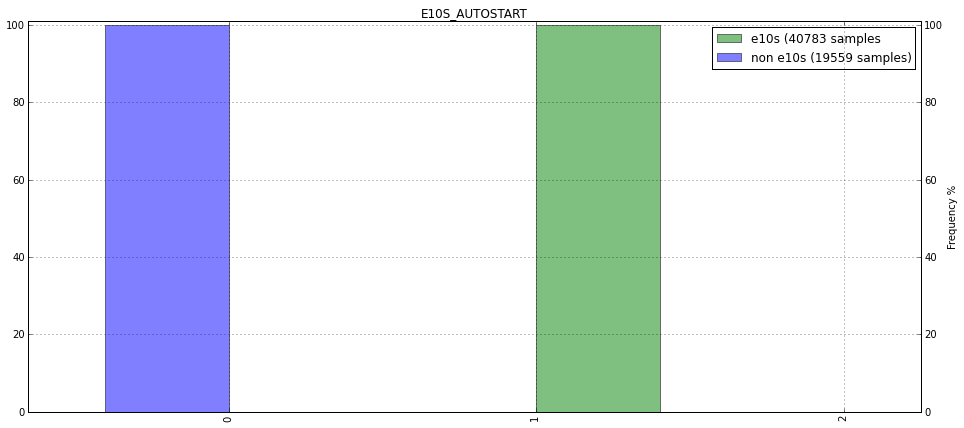

The chi2 distance for E10S_AUTOSTART_STATUS is 0.9999999999


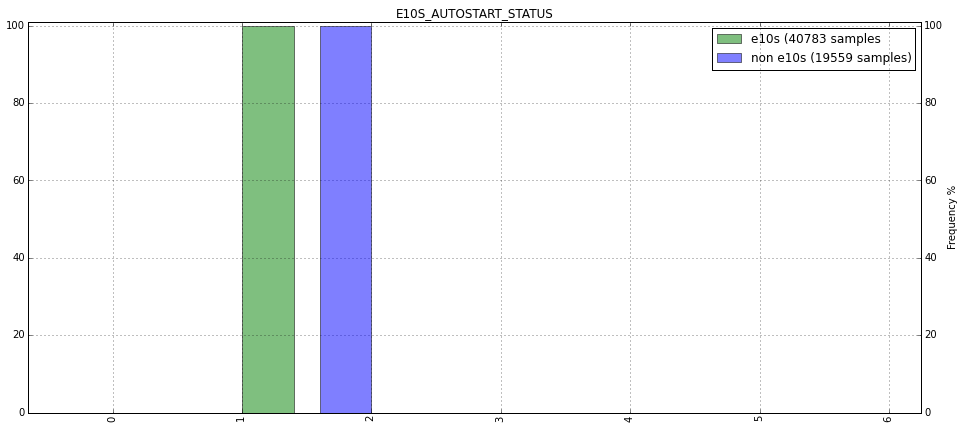

The chi2 distance for BLOCKED_ON_PLUGIN_MODULE_INIT_MS is 0.99999999925


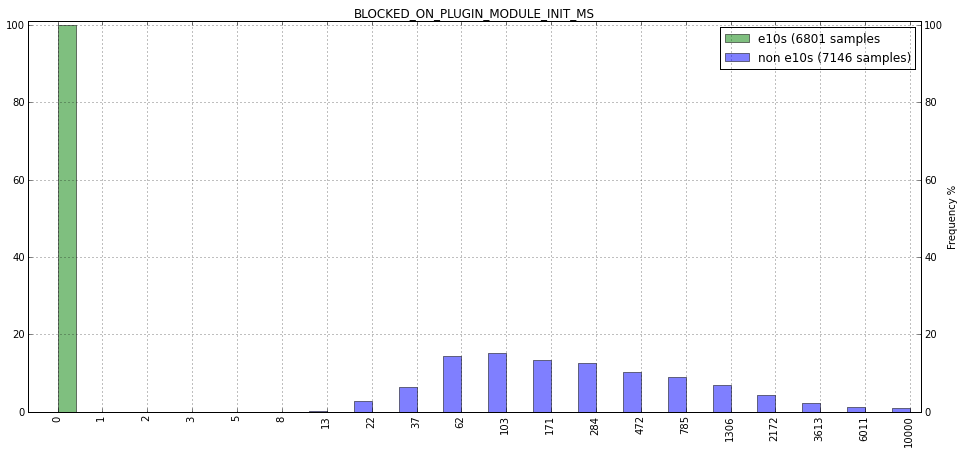

The chi2 distance for E10S_WINDOW is 0.995652523852


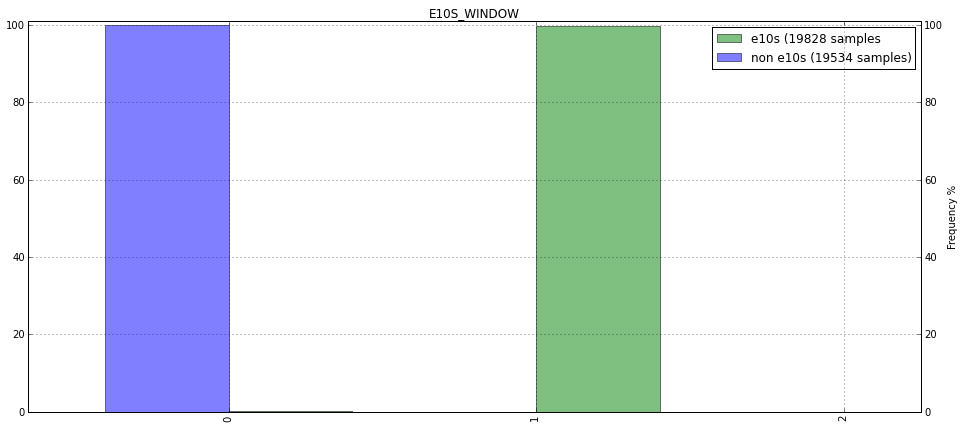

The chi2 distance for FIND_PLUGINS is 0.529090744338


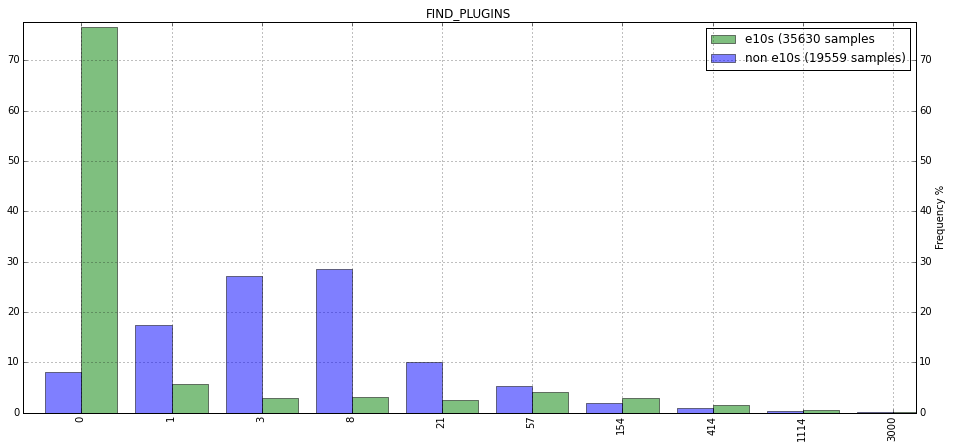

The chi2 distance for HTTP_REQUEST_PER_PAGE_FROM_CACHE is 0.488320536004


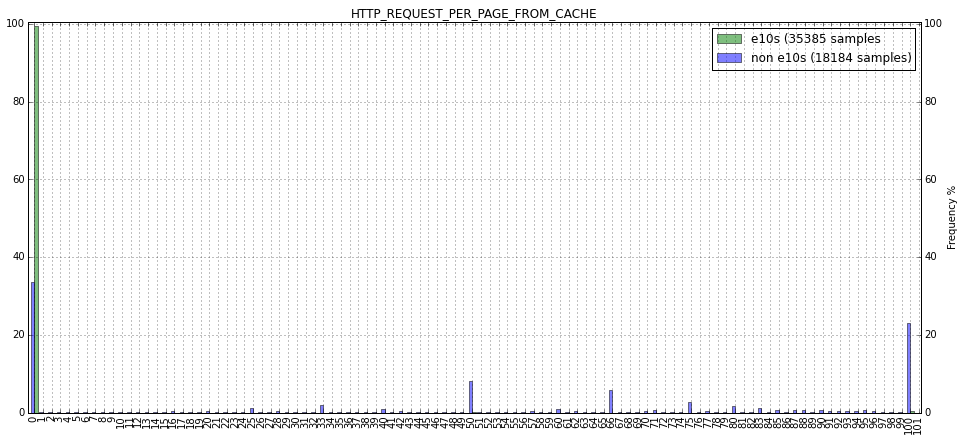

The chi2 distance for MEMORY_JS_COMPARTMENTS_SYSTEM is 0.434165309618


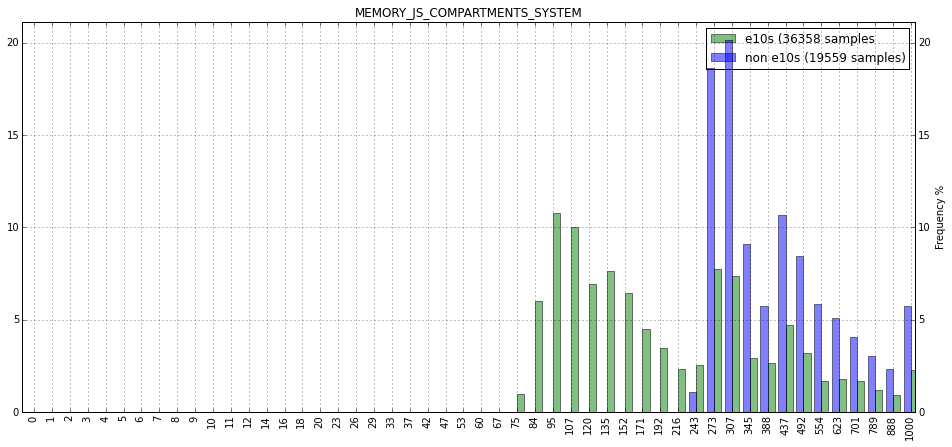

The chi2 distance for FX_THUMBNAILS_CAPTURE_TIME_MS is 0.433592538251


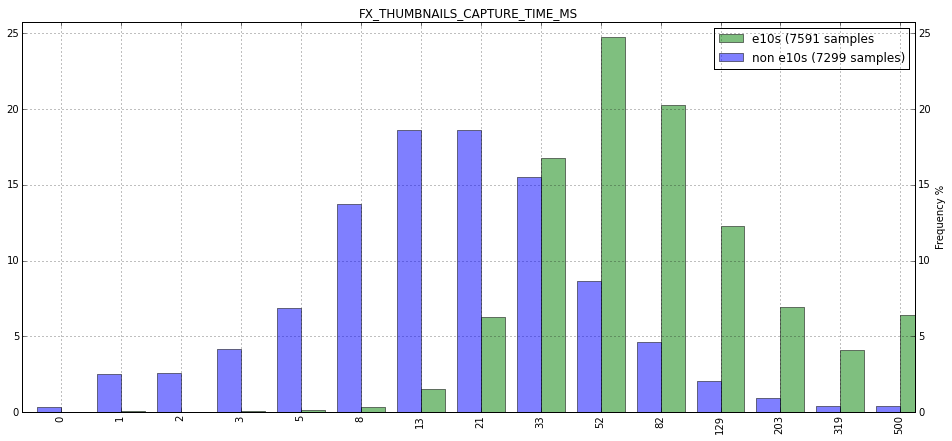

The chi2 distance for GC_MINOR_REASON_LONG is 0.296636180802


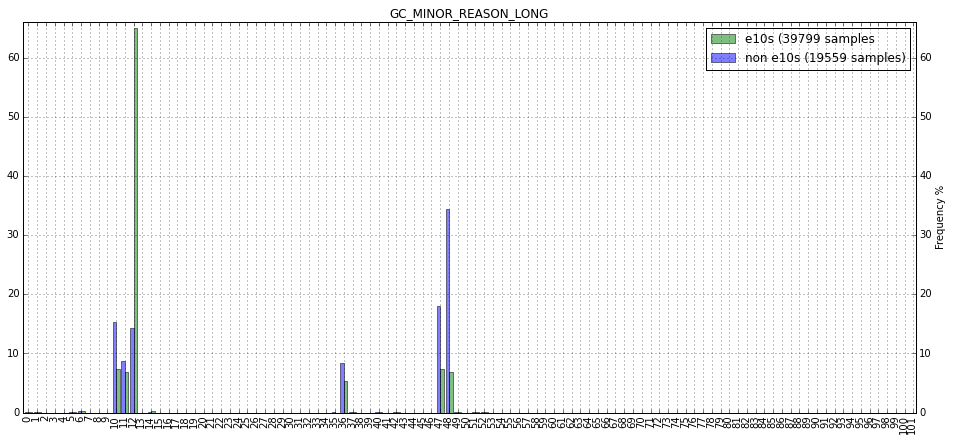

The chi2 distance for SIMPLE_MEASURES_FIRSTLOADURI is 0.224125563559


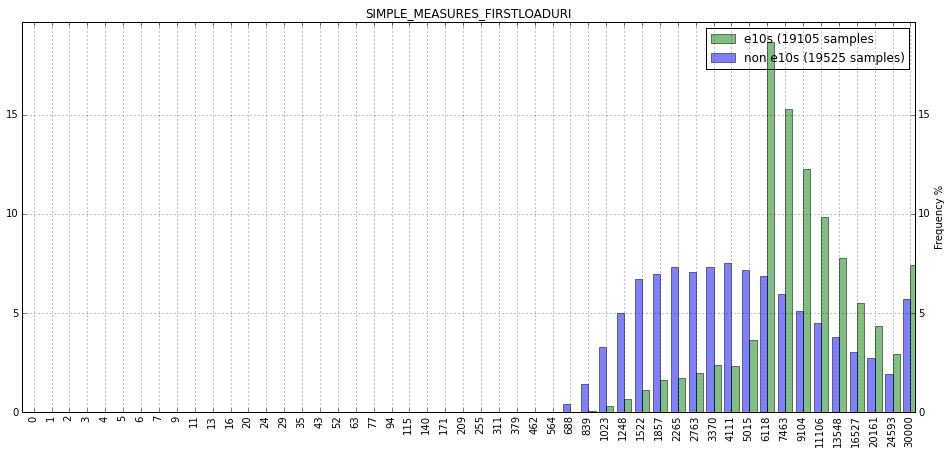

The chi2 distance for HTTP_SUB_DNS_ISSUE_TIME is 0.216883473274


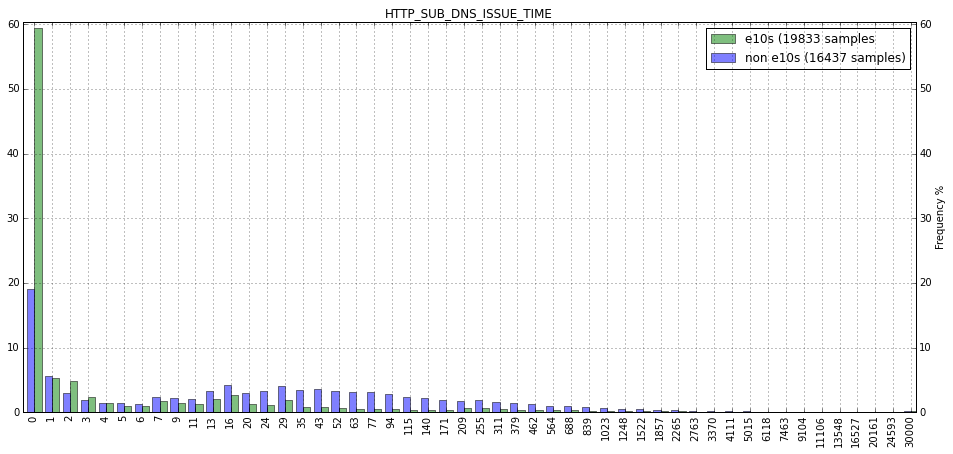

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.207582753233


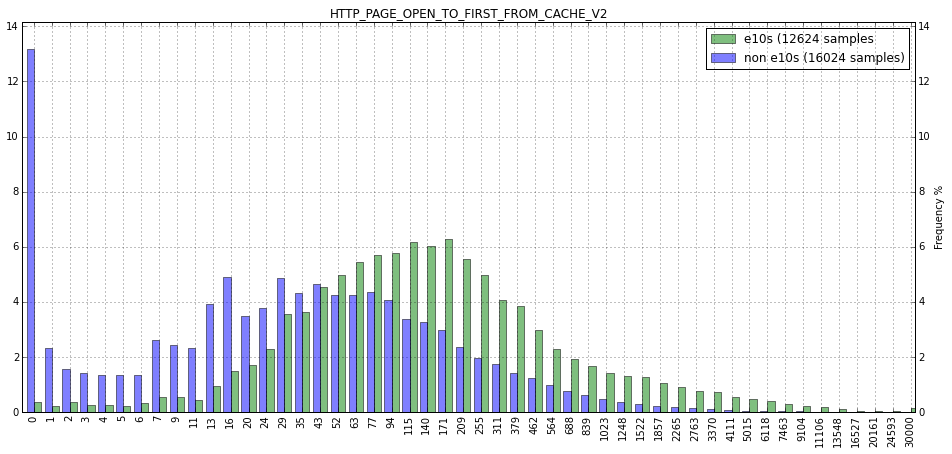

The chi2 distance for EVENTLOOP_UI_LAG_EXP_MS is 0.203564518971


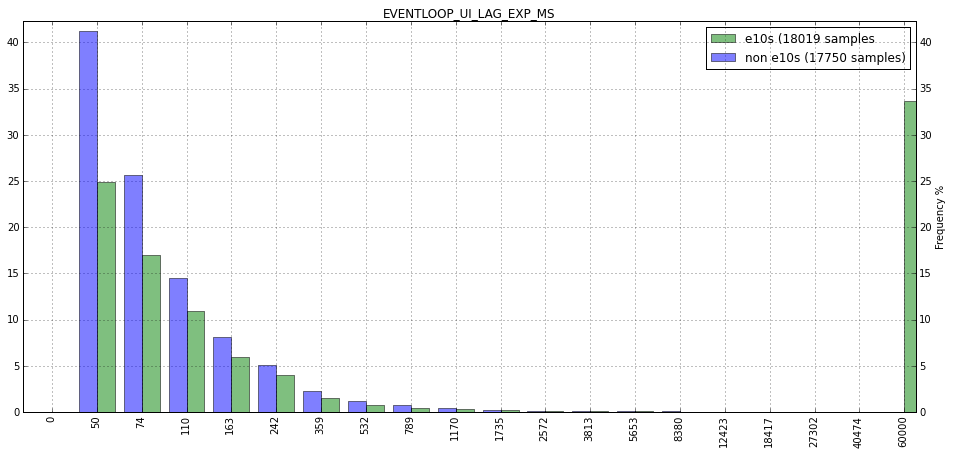

The chi2 distance for HTTP_SUB_DNS_LOOKUP_TIME is 0.184419777161


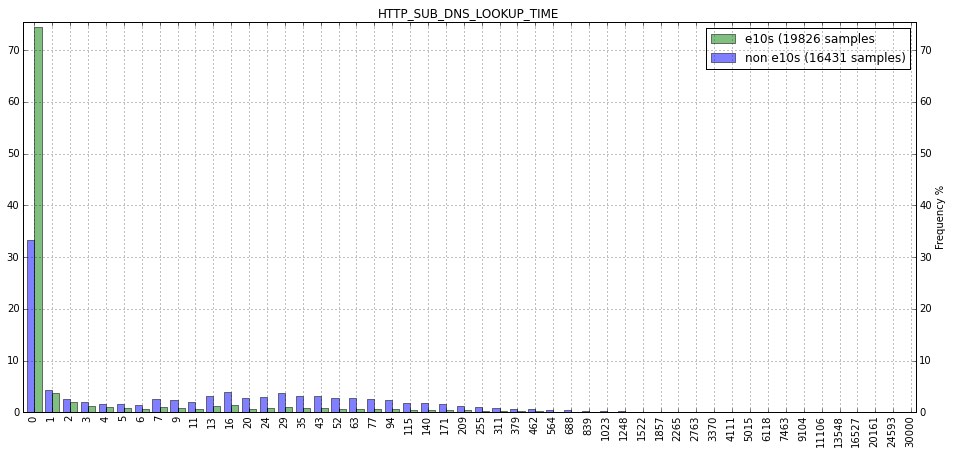

The chi2 distance for HTTP_PAGE_DNS_ISSUE_TIME is 0.183774227375


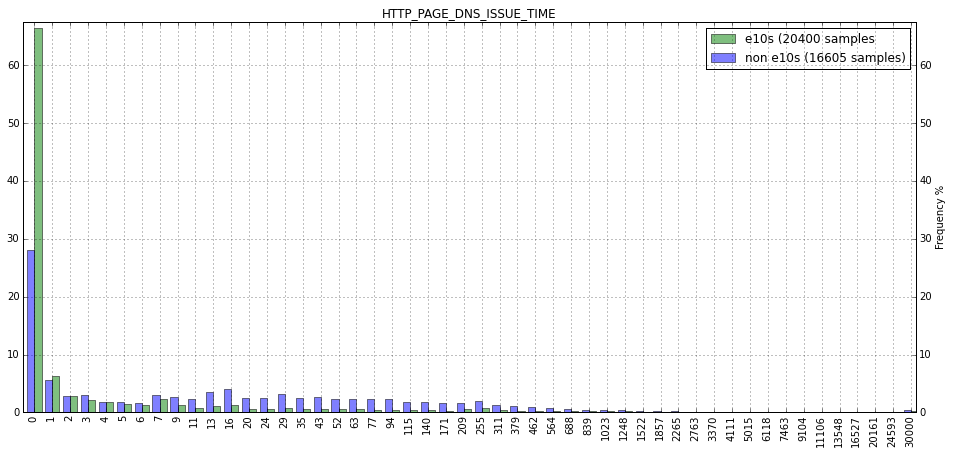

The chi2 distance for CYCLE_COLLECTOR_VISITED_GCED is 0.161367224528


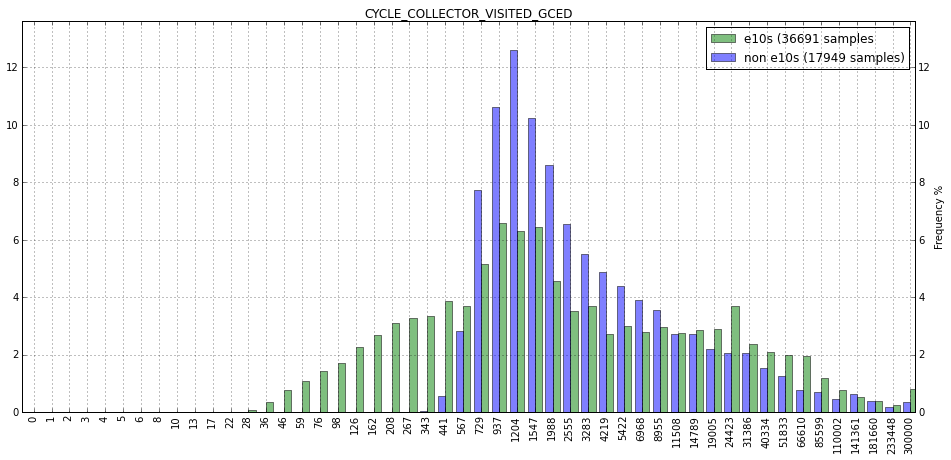

The chi2 distance for FX_TAB_SWITCH_UPDATE_MS is 0.155567772715


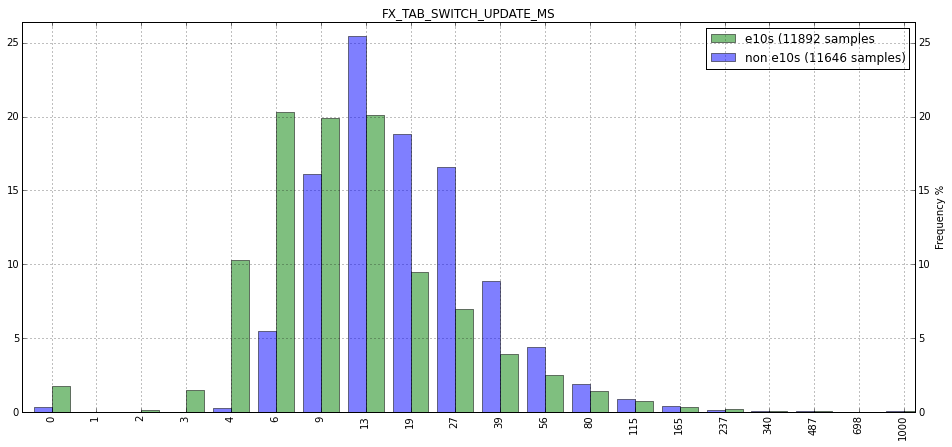

The chi2 distance for HTTP_SUB_REVALIDATION is 0.151473672089


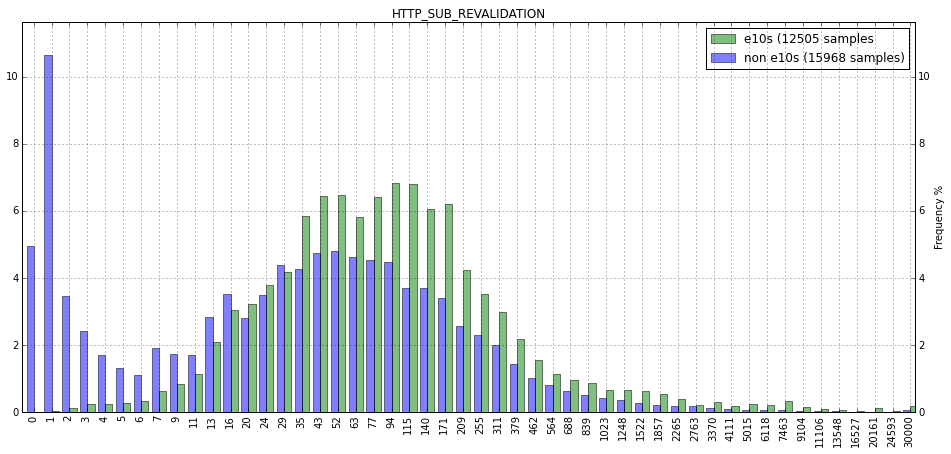

The chi2 distance for MEMORY_JS_COMPARTMENTS_USER is 0.14603248399


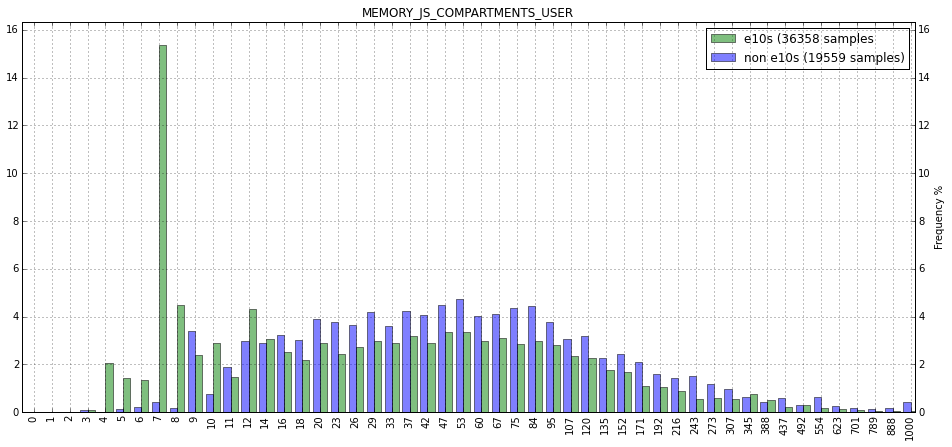

The chi2 distance for GC_MINOR_REASON is 0.144522364043


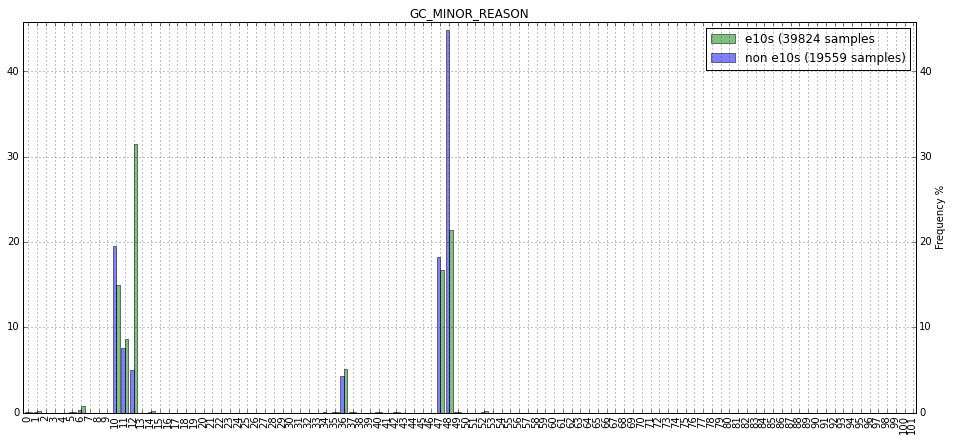

The chi2 distance for FX_TAB_CLICK_MS is 0.142183307683


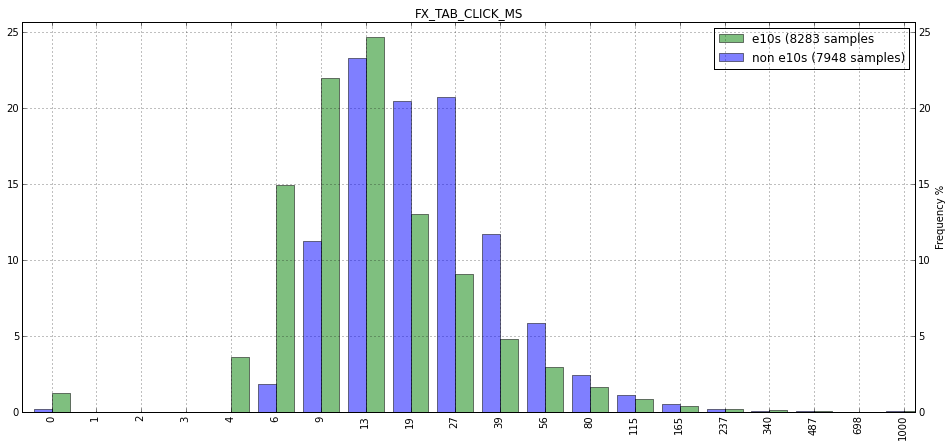

The chi2 distance for ADDON_SHIM_USAGE is 0.13791887761


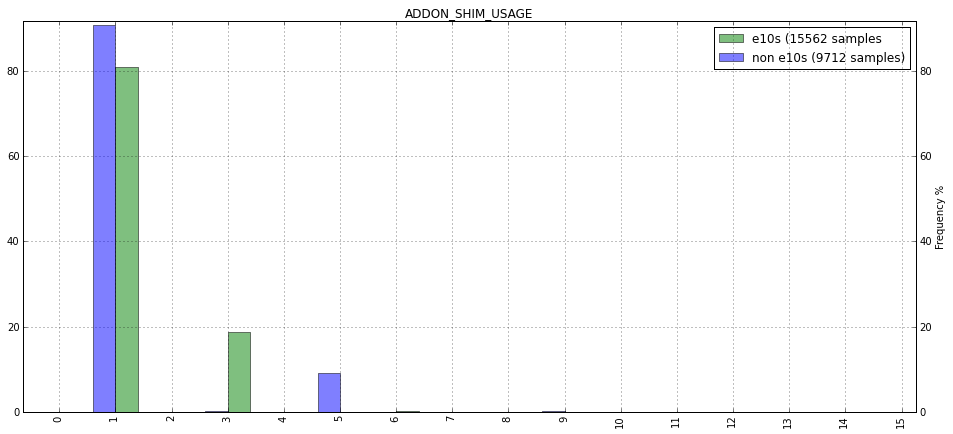

The chi2 distance for SIMPLE_MEASURES_MAXIMALNUMBEROFCONCURRENTTHREADS is 0.128886063367


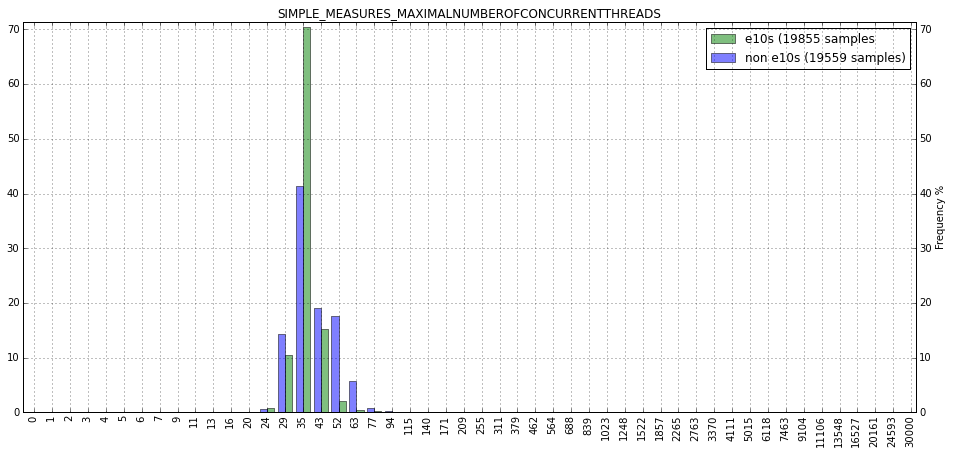

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_SENT is 0.120572706293


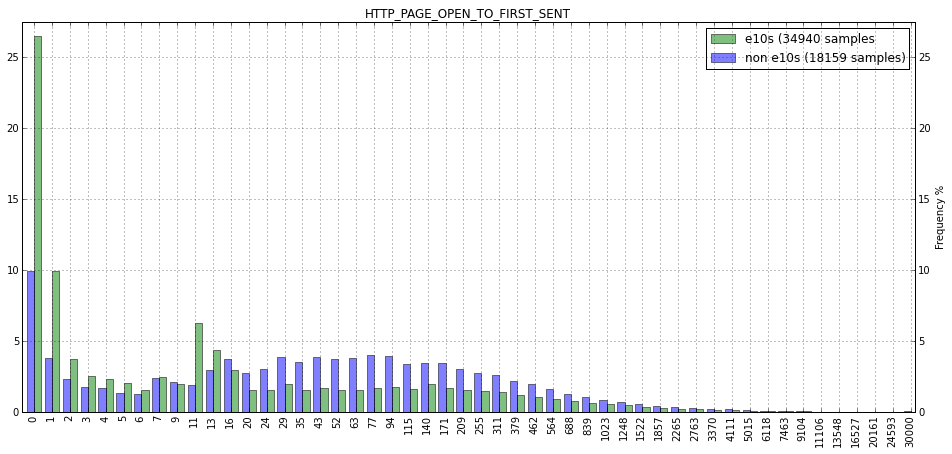

The chi2 distance for PLUGIN_LOAD_METADATA is 0.120401909459


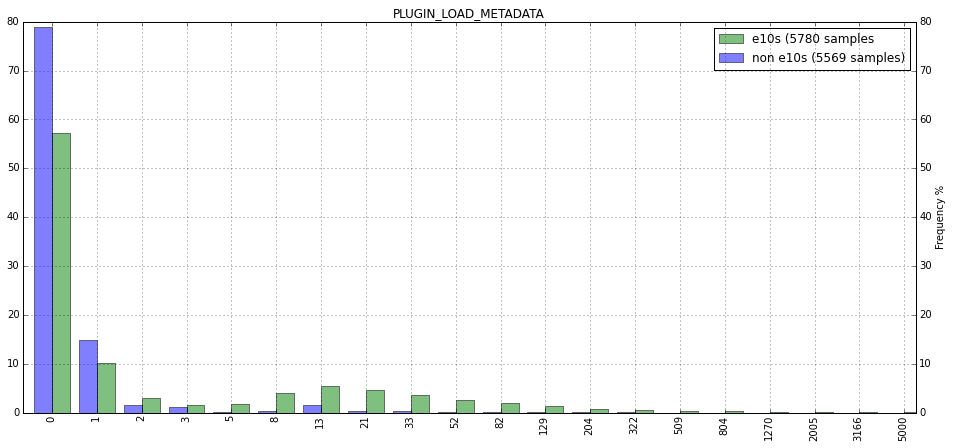

The chi2 distance for MEMORY_VSIZE is 0.117098035981


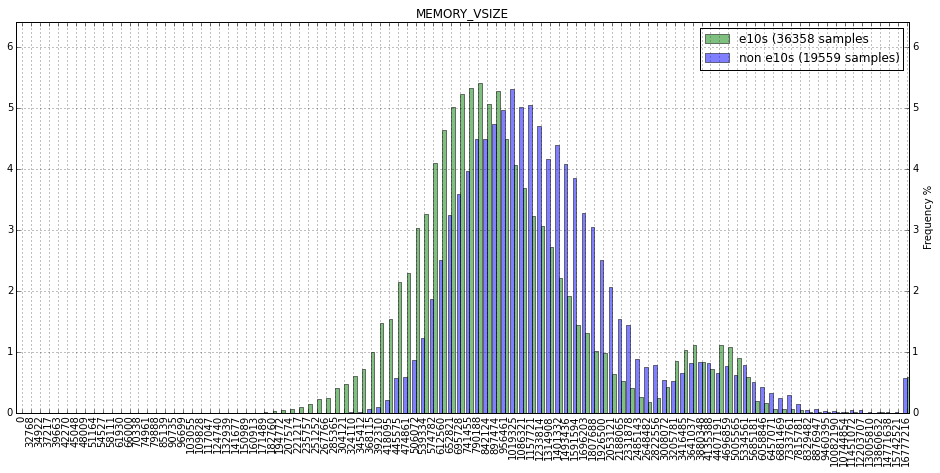

The chi2 distance for GC_MARK_ROOTS_MS is 0.114533574538


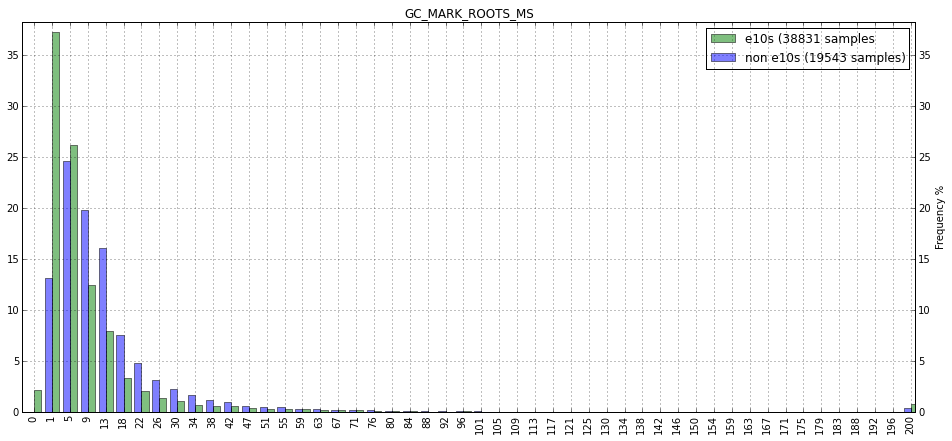

The chi2 distance for GC_MARK_MS is 0.111010467983


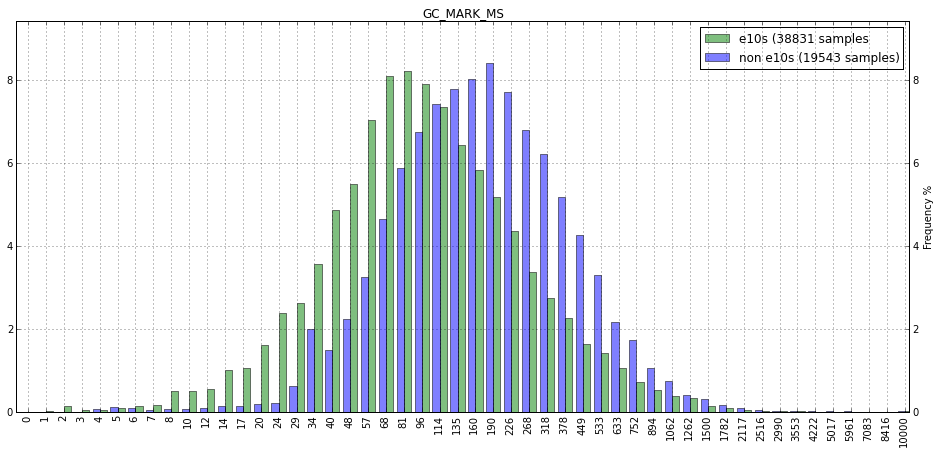

The chi2 distance for SIMPLE_MEASURES_JS_SETPROTO is 0.108219776213


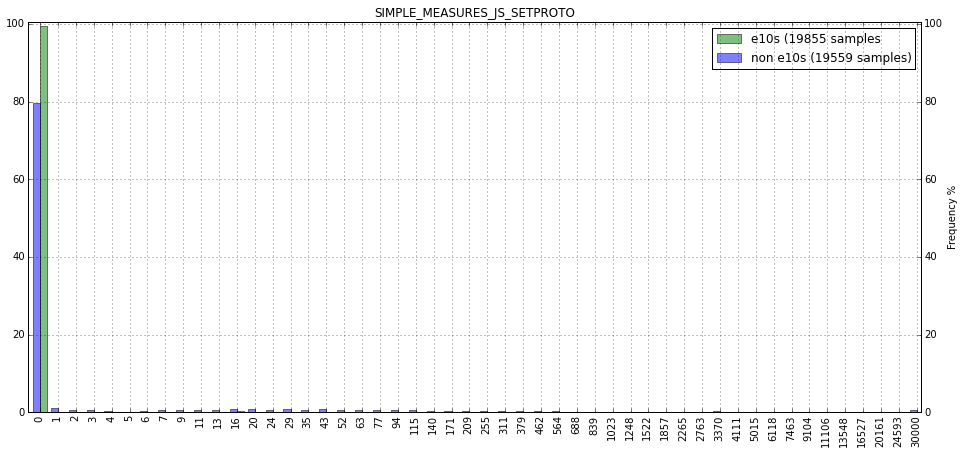

The chi2 distance for MEMORY_RESIDENT is 0.107365380916


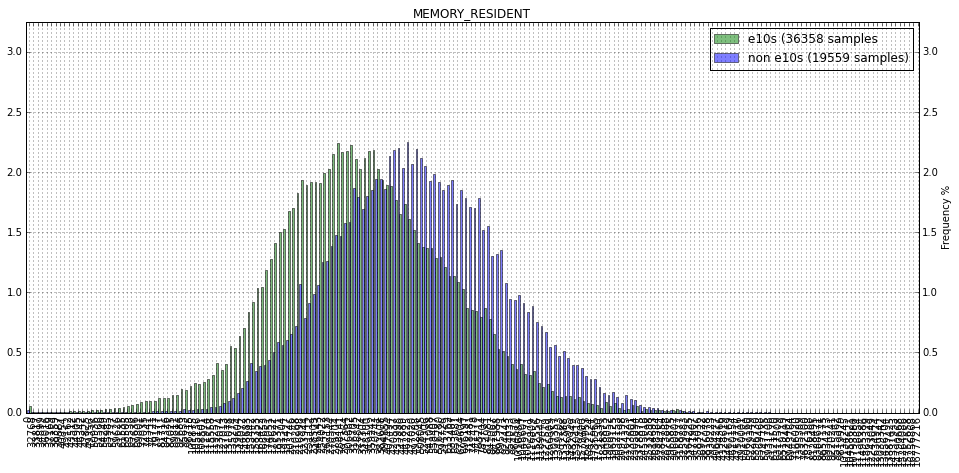

The chi2 distance for MEMORY_HEAP_ALLOCATED is 0.10534565932


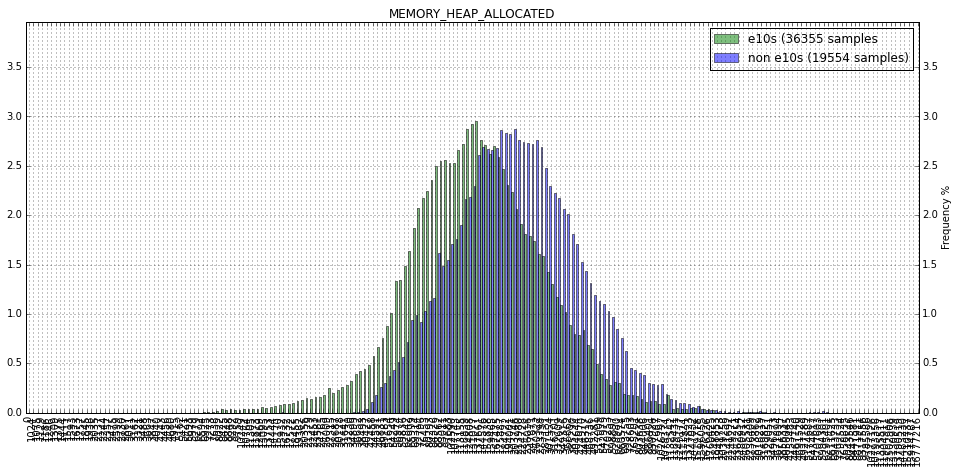

The chi2 distance for GC_MS is 0.10143189638


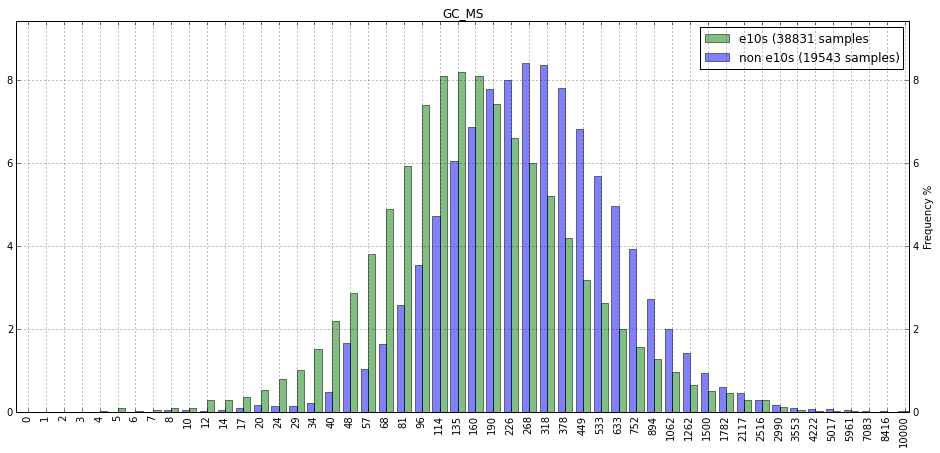

The chi2 distance for CYCLE_COLLECTOR_VISITED_REF_COUNTED is 0.0968676212669


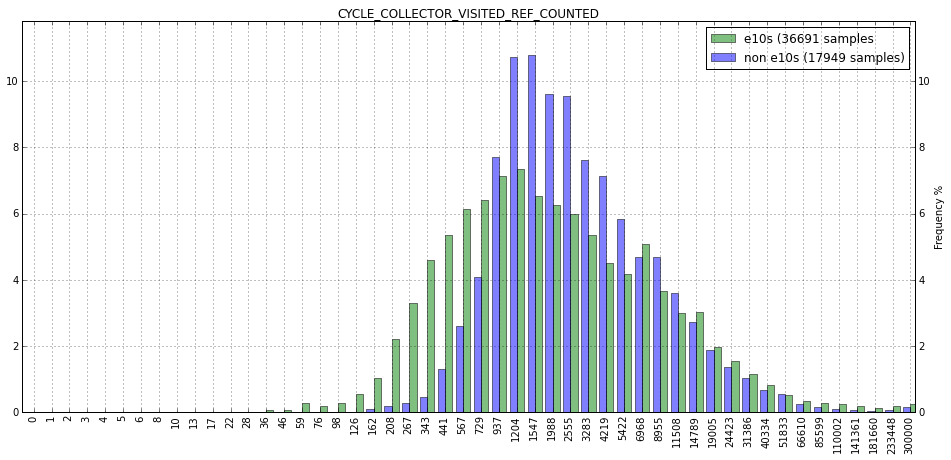

The chi2 distance for MEMORY_JS_GC_HEAP is 0.0939112997304


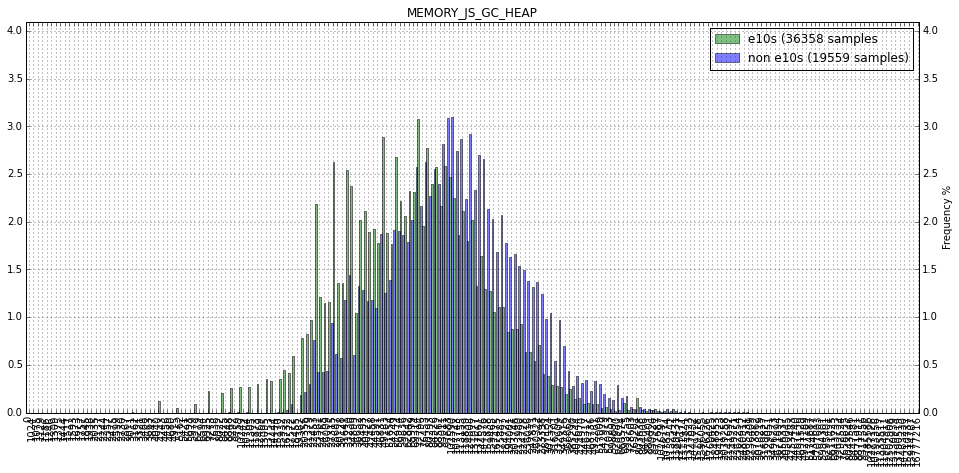

The chi2 distance for FLASH_PLUGIN_AREA is 0.0876419339564


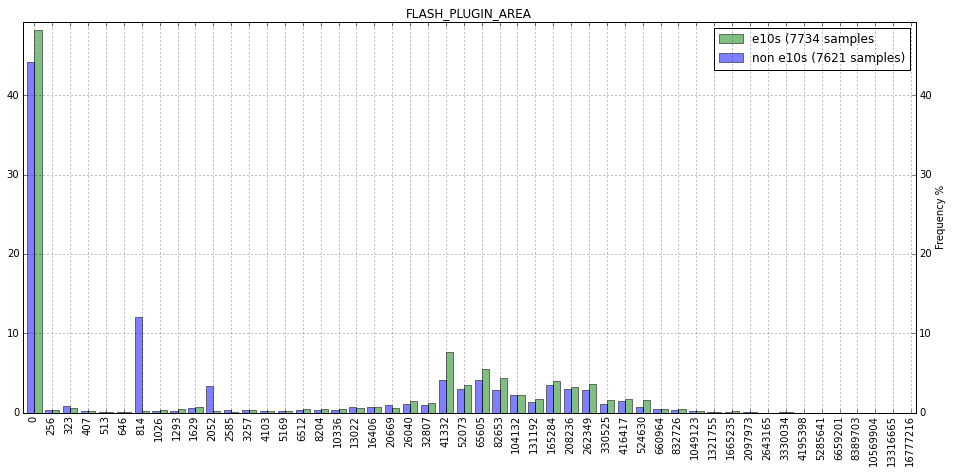

The chi2 distance for HTTP_PAGE_DNS_LOOKUP_TIME is 0.0853087411945


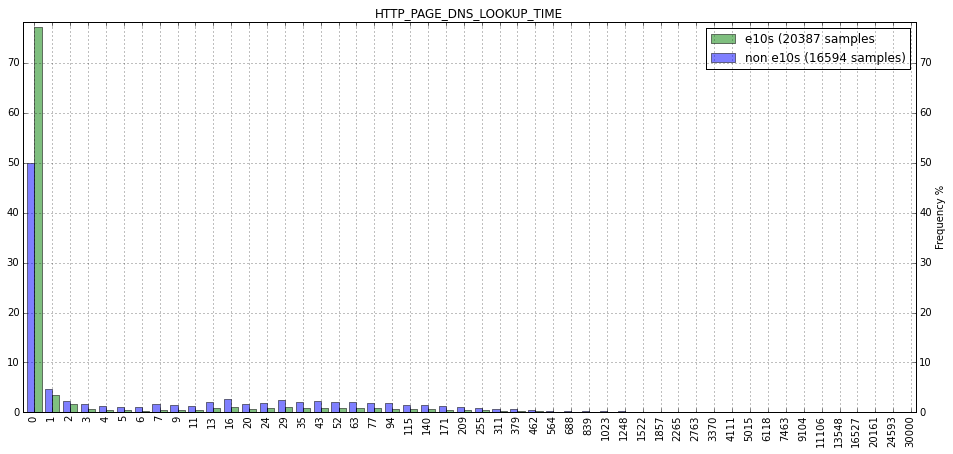

The chi2 distance for LINK_ICON_SIZES_ATTR_DIMENSION is 0.0839597953685


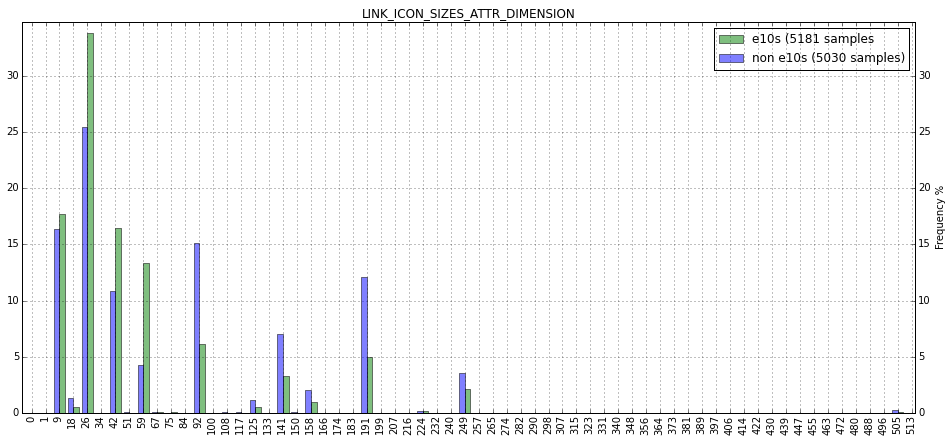

The chi2 distance for GC_SWEEP_MS is 0.0833518390952


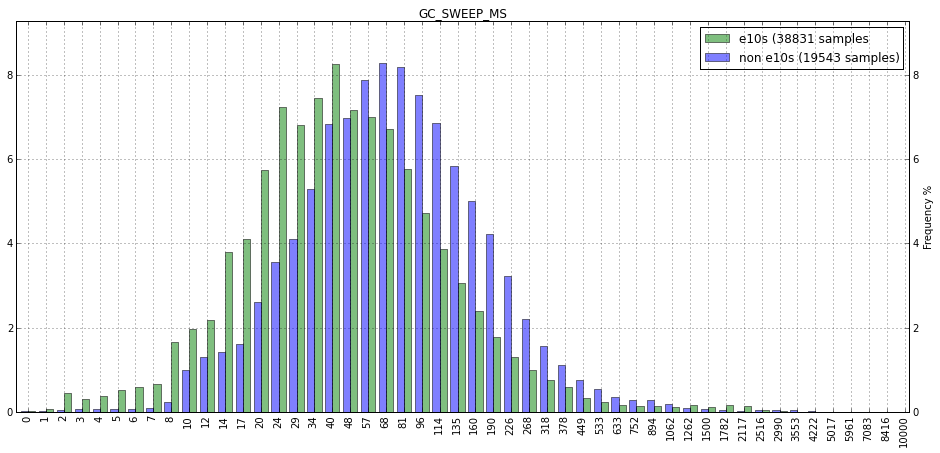

The chi2 distance for PAINT_BUILD_DISPLAYLIST_TIME is 0.0817407457607


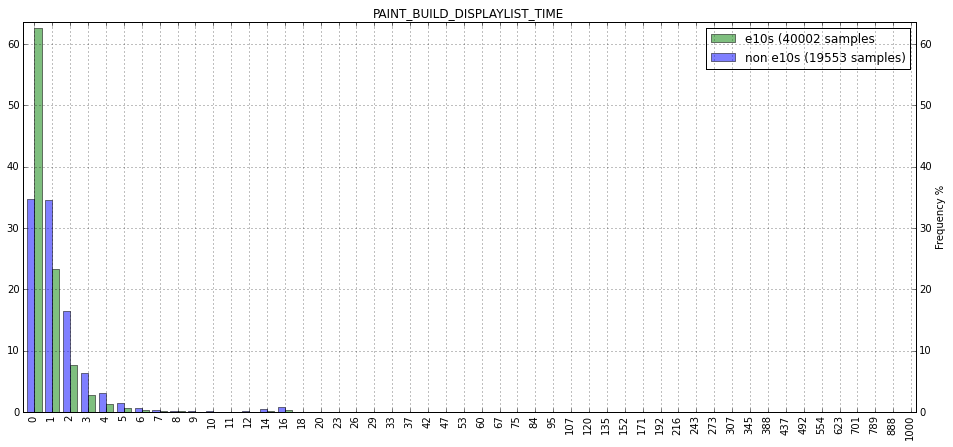

The chi2 distance for HTTP_PAGE_CACHE_READ_TIME_V2 is 0.0816200830683


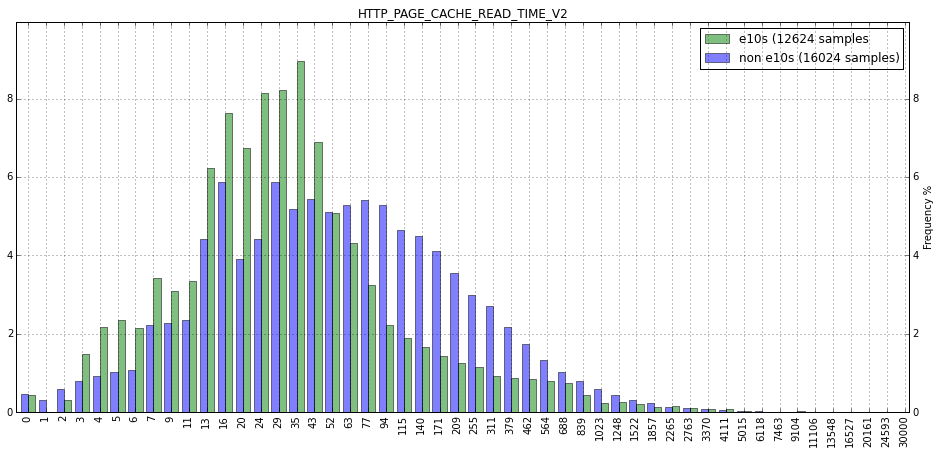

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_SENT is 0.0773053062786


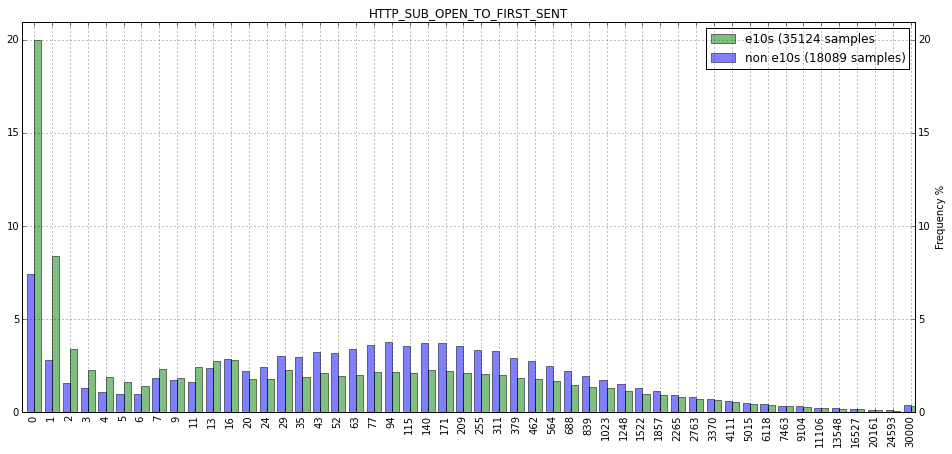

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 is 0.0740158255723


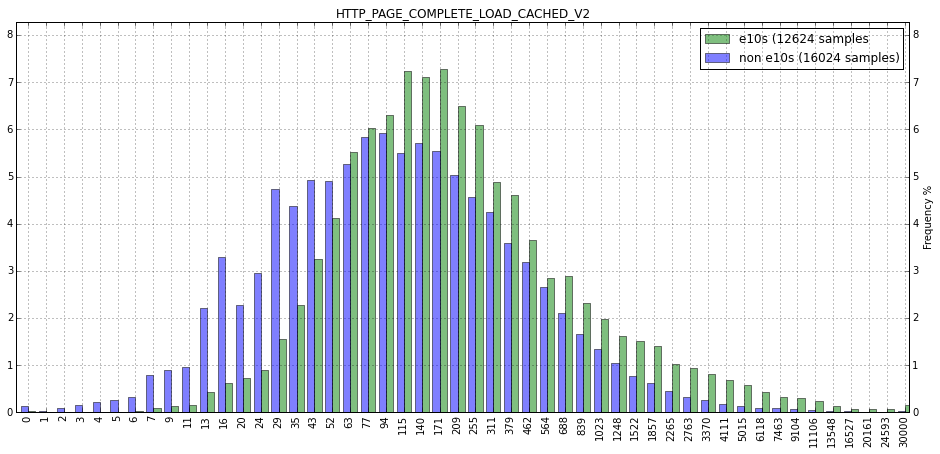

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD is 0.0739969295009


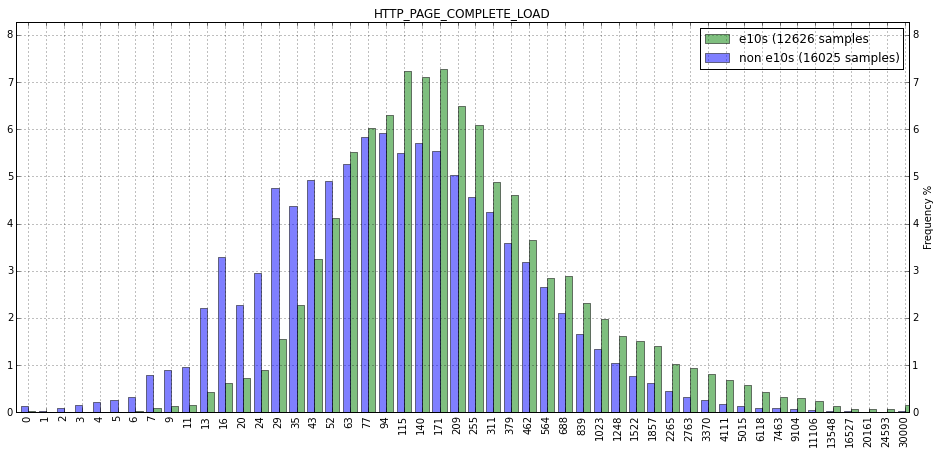

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_NET_V2 is 0.0738916844871


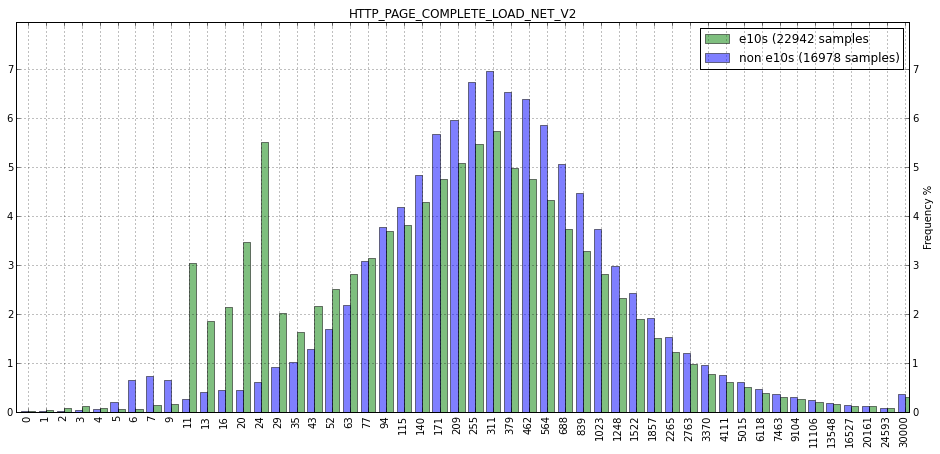

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_V2 is 0.0738916844871


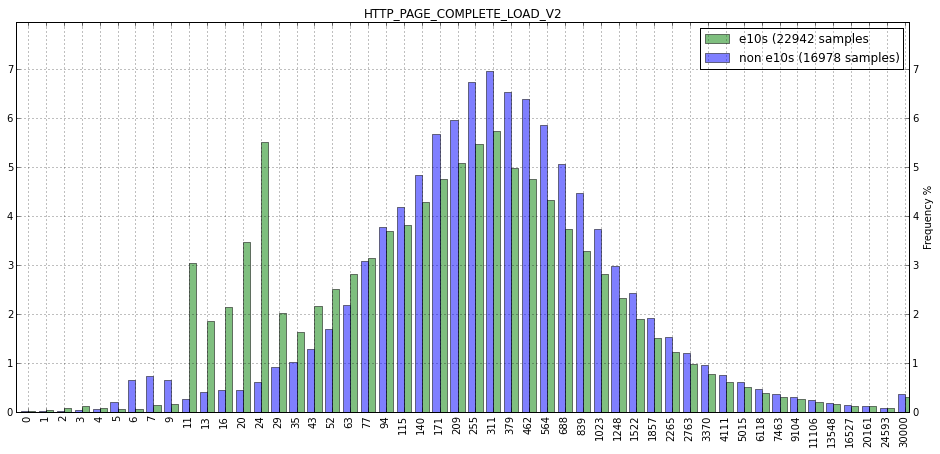

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_RECEIVED is 0.0729695056718


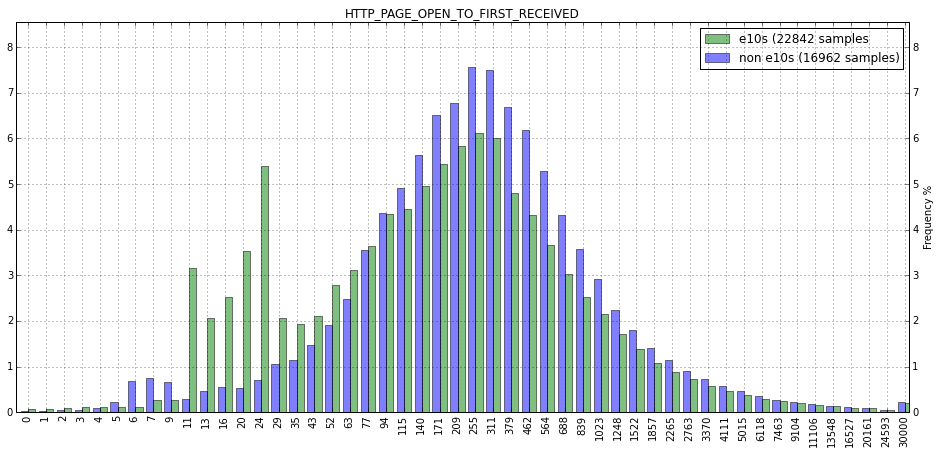

The chi2 distance for HTTP_PAGE_FIRST_SENT_TO_LAST_RECEIVED is 0.071998233402


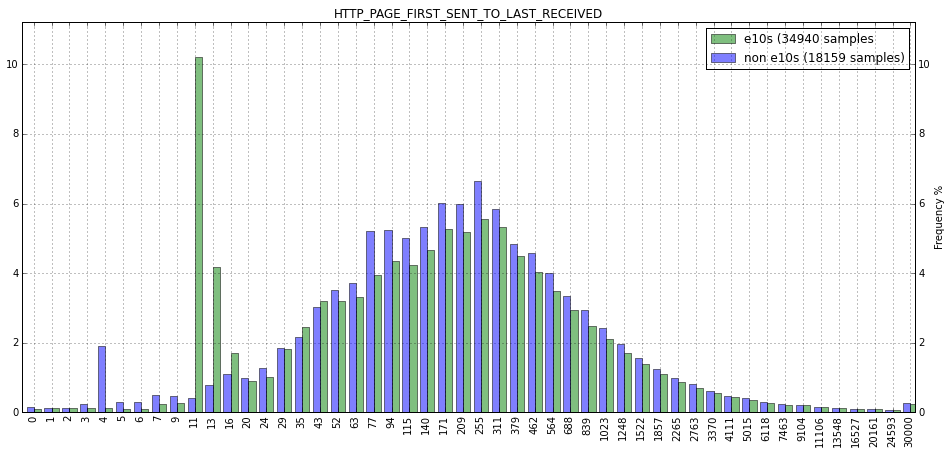

The chi2 distance for LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS is 0.0689568334067


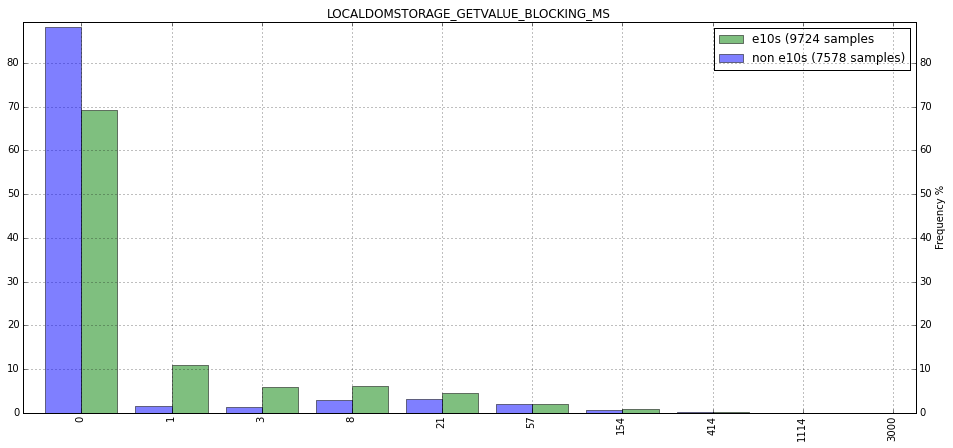

The chi2 distance for CYCLE_COLLECTOR is 0.0650809342569


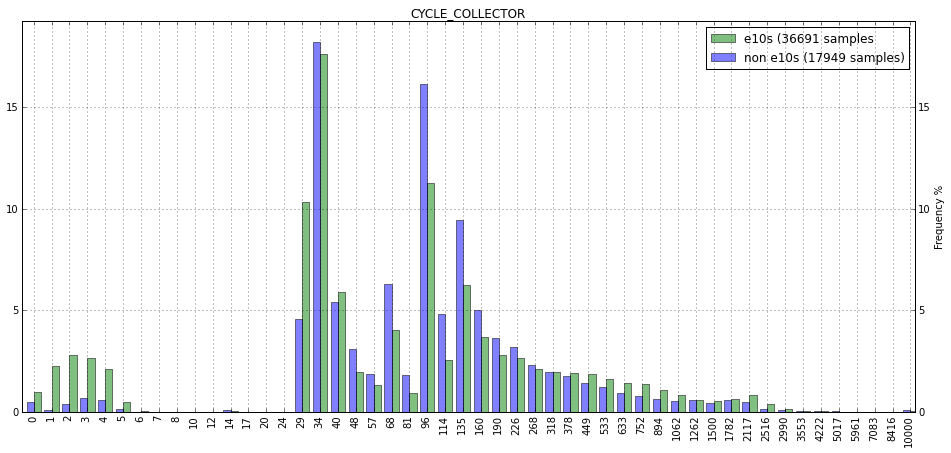

The chi2 distance for CYCLE_COLLECTOR_FULL is 0.0648537238421


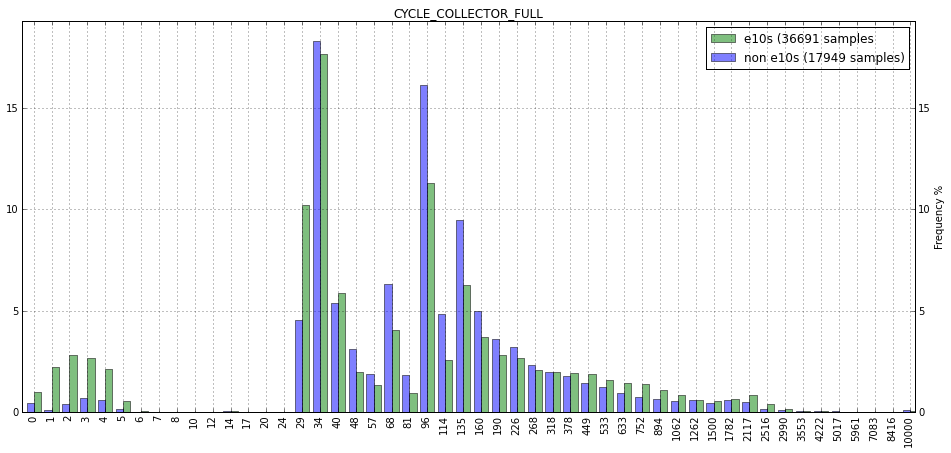

The chi2 distance for IMAGE_DECODE_ON_DRAW_LATENCY is 0.0607125043076


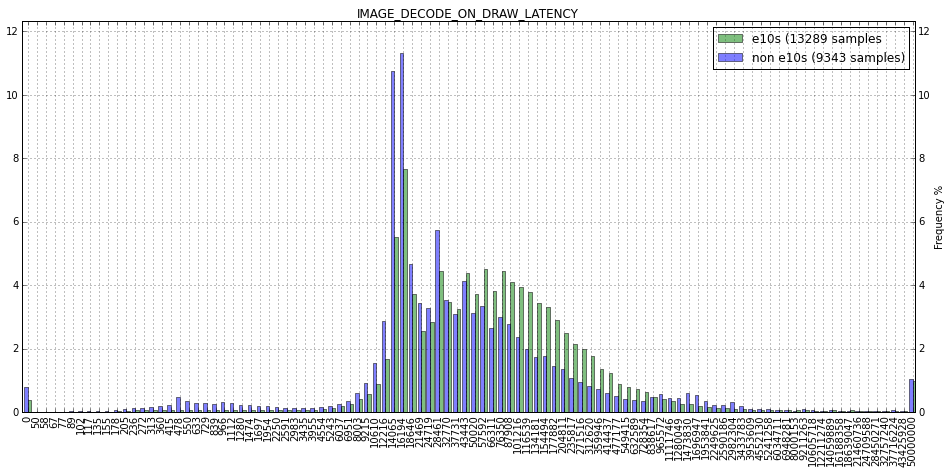

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.0553256099175


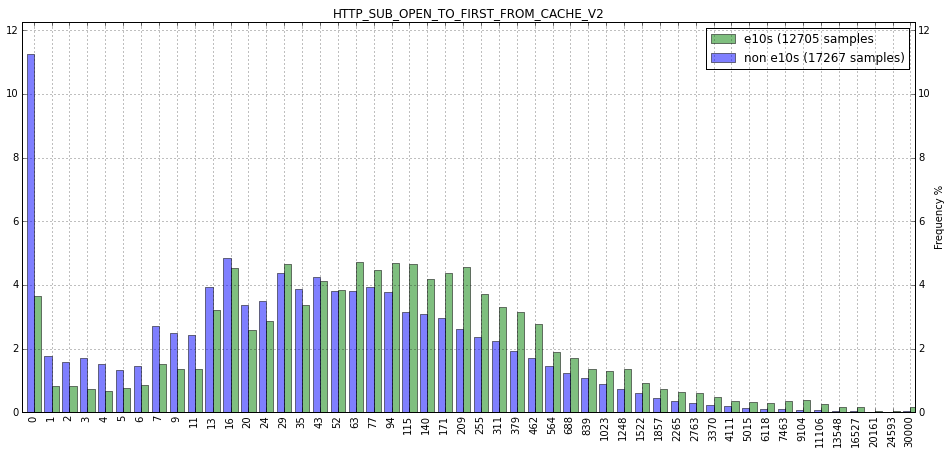

The chi2 distance for PLACES_FAVICON_PNG_SIZES is 0.0539634724966


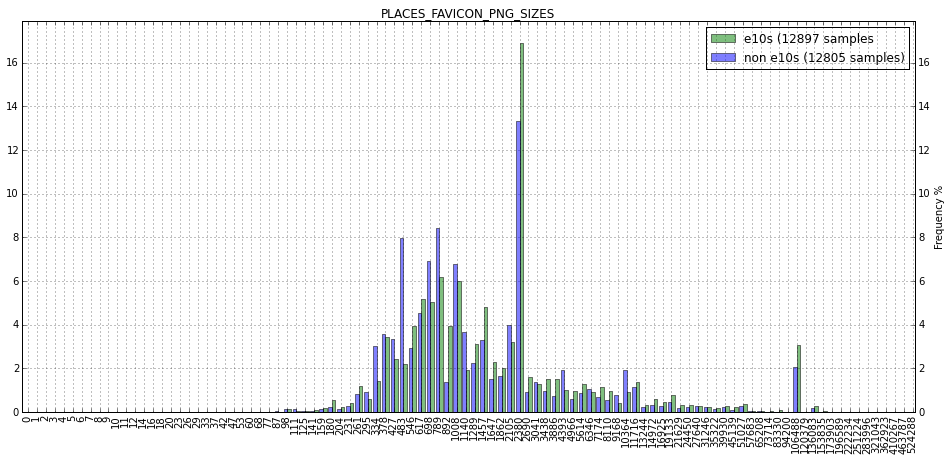

The chi2 distance for MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK is 0.0536379048883


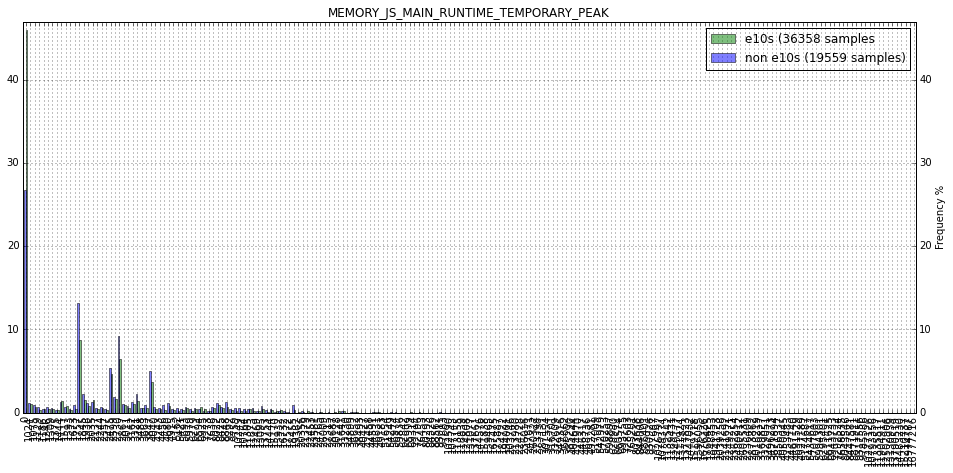

The chi2 distance for GC_MMU_50 is 0.0535350643148


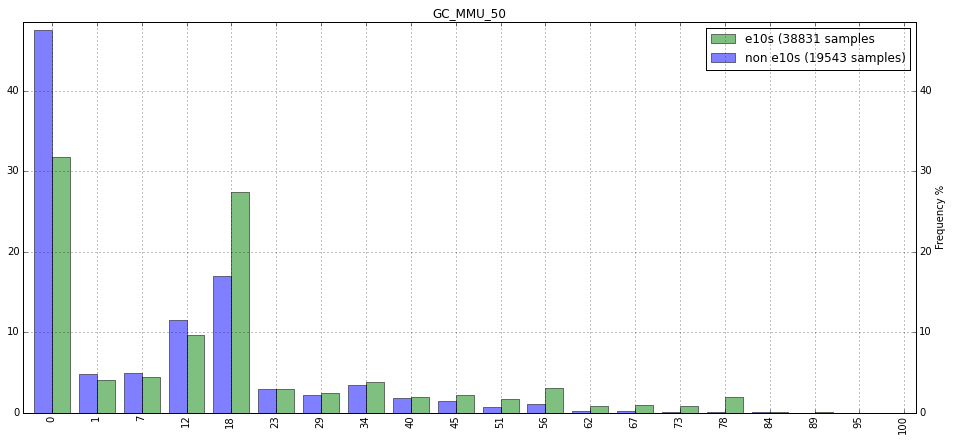

The chi2 distance for GC_MARK_GRAY_MS is 0.0478927997431


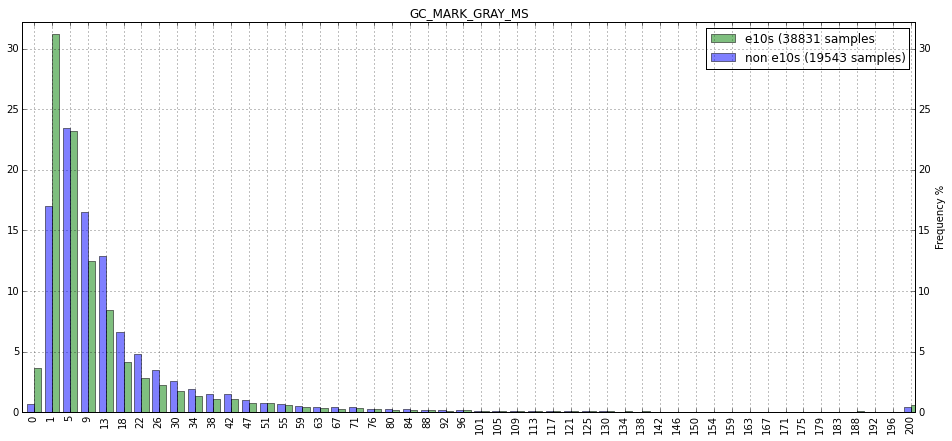

The chi2 distance for MEMORY_HEAP_COMMITTED_UNUSED_RATIO is 0.0449094936243


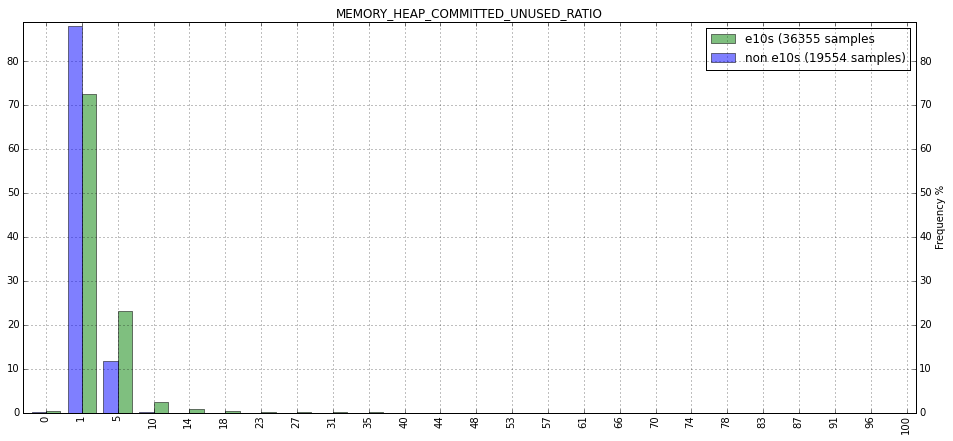

The chi2 distance for SYSTEM_FONT_FALLBACK_SCRIPT is 0.0423120416263


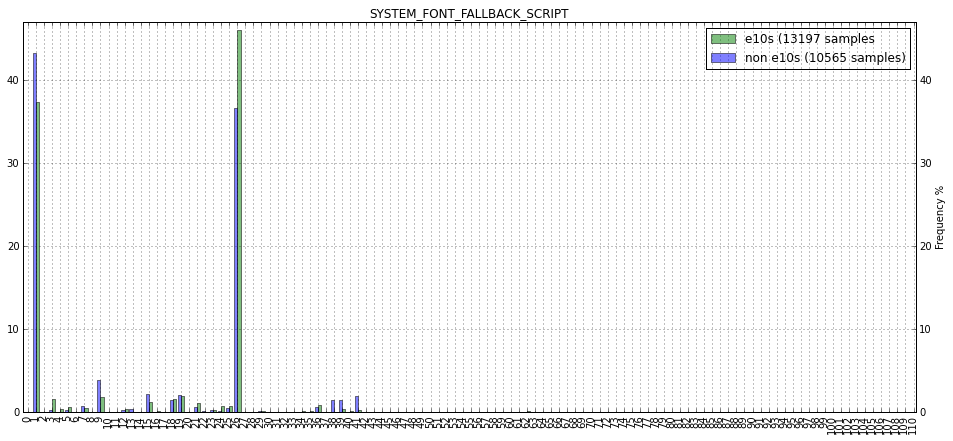

The chi2 distance for IMAGE_MAX_DECODE_COUNT is 0.04191267146


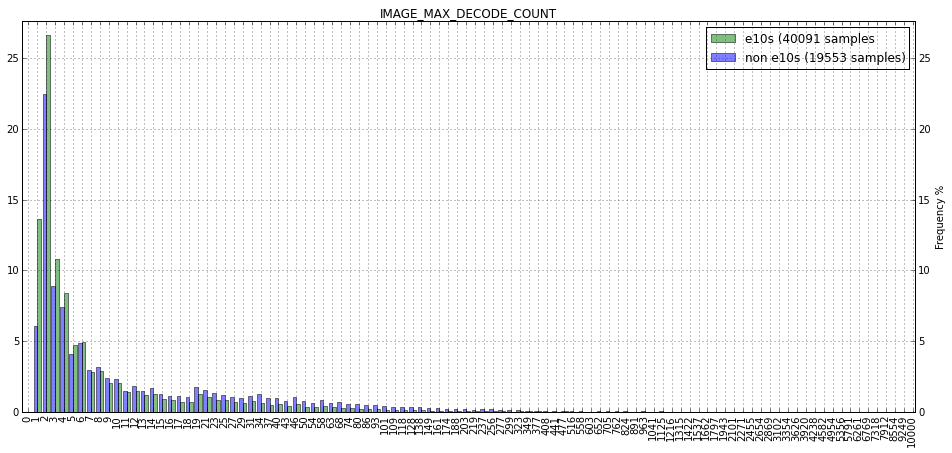

The chi2 distance for GC_SCC_SWEEP_TOTAL_MS is 0.0393499109577


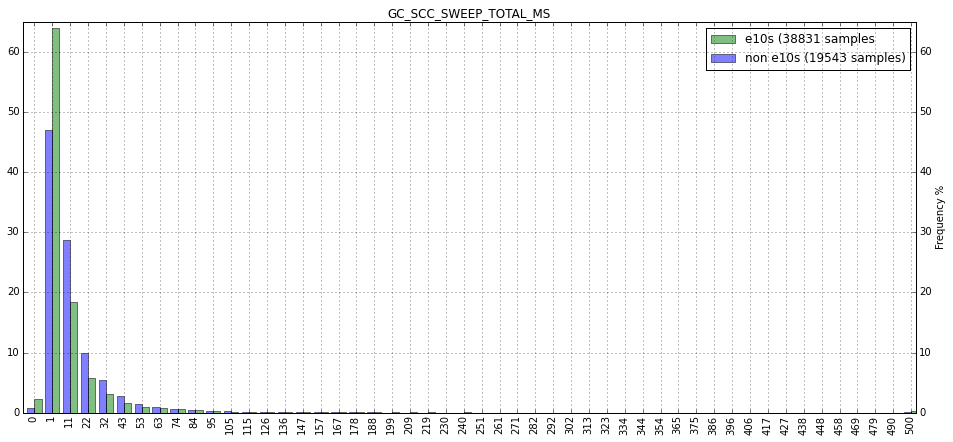

The chi2 distance for FLASH_PLUGIN_INSTANCES_ON_PAGE is 0.0387923782199


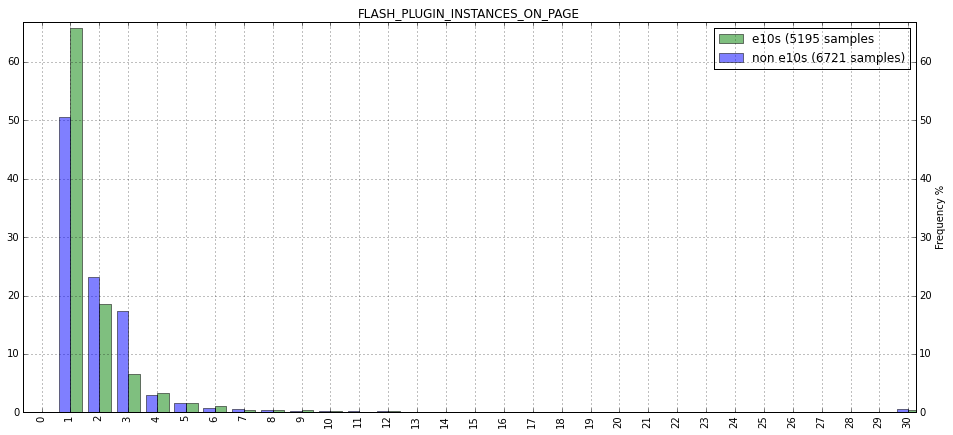

The chi2 distance for HEALTHREPORT_COLLECT_CONSTANT_DATA_MS is 0.0372030127388


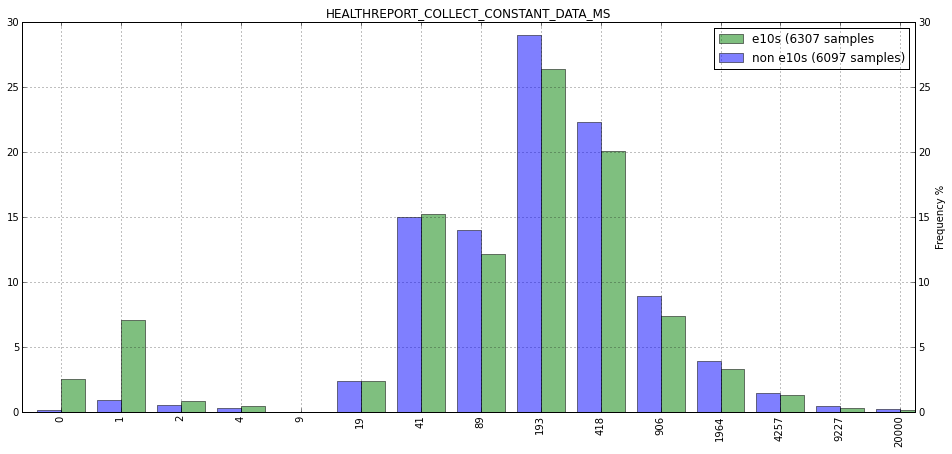

The chi2 distance for PAINT_RASTERIZE_TIME is 0.0358517926809


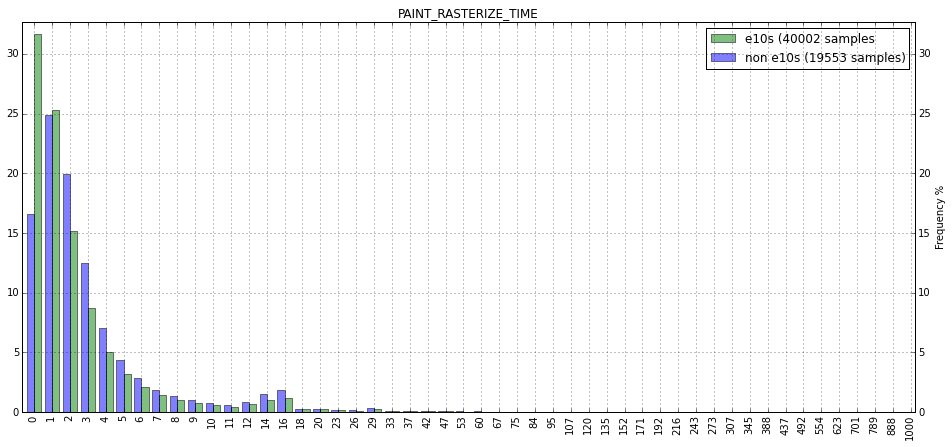

The chi2 distance for TELEMETRY_MEMORY_REPORTER_MS is 0.035226286433


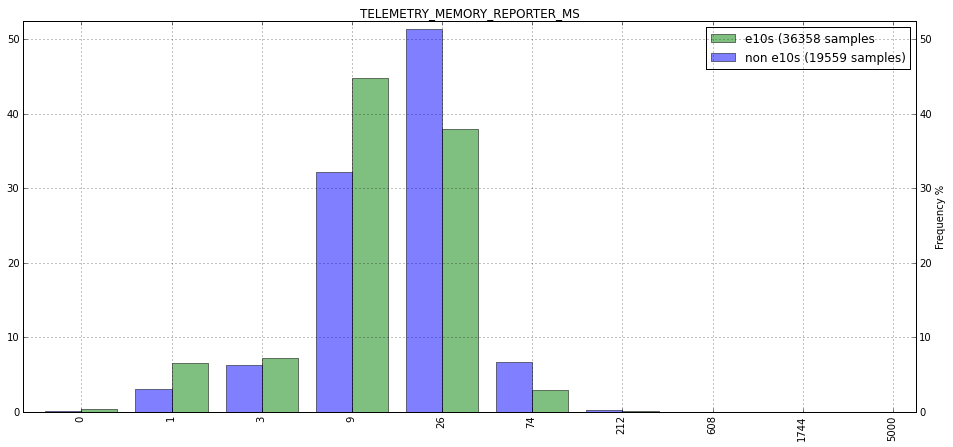

The chi2 distance for NETWORK_CACHE_HIT_RATE_PER_CACHE_SIZE is 0.0341908045323


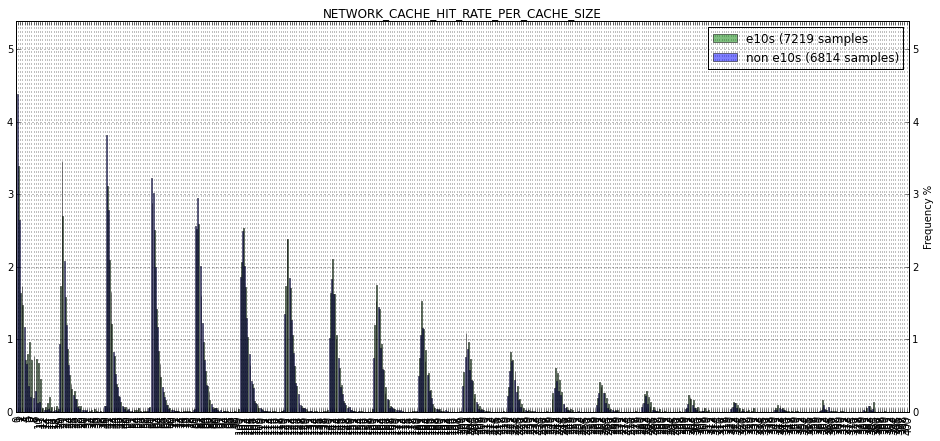

The chi2 distance for GC_REASON_2 is 0.0339361571853


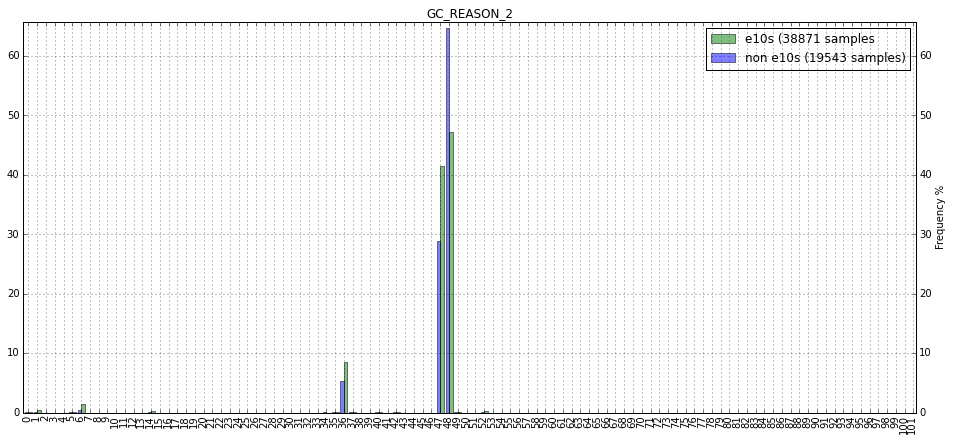

The chi2 distance for FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS is 0.0333723435673


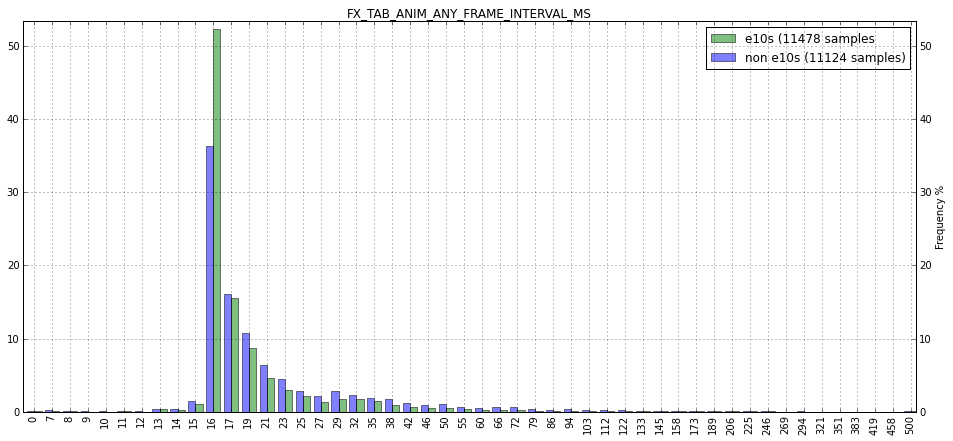

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS is 0.0330470177211


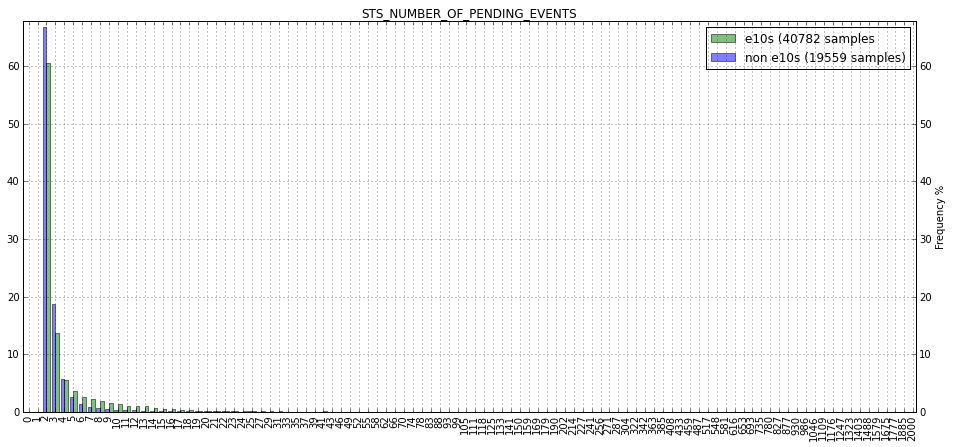

The chi2 distance for DNS_FAILED_LOOKUP_TIME is 0.032790522926


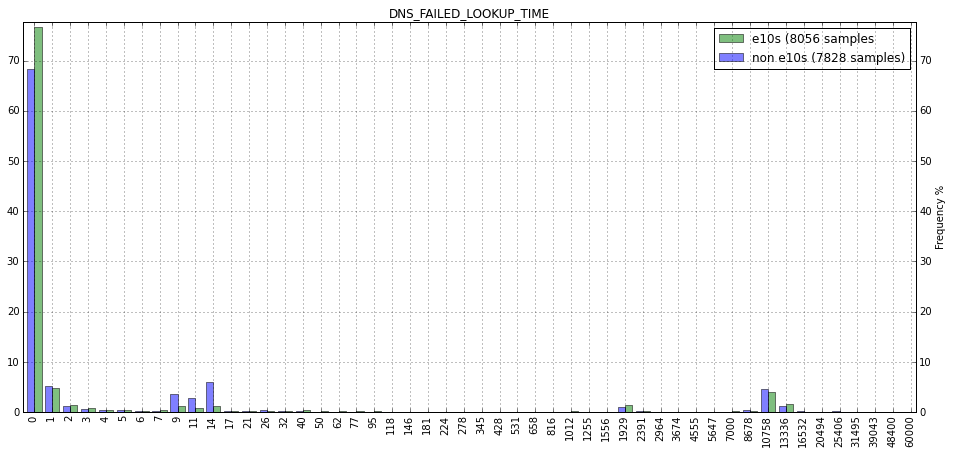

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS is 0.0323952911035


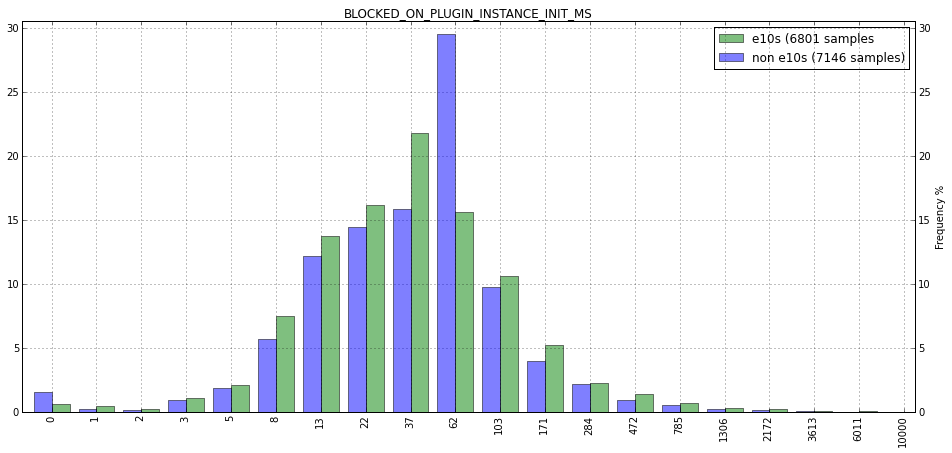

The chi2 distance for LINK_ICON_SIZES_ATTR_USAGE is 0.0322235849343


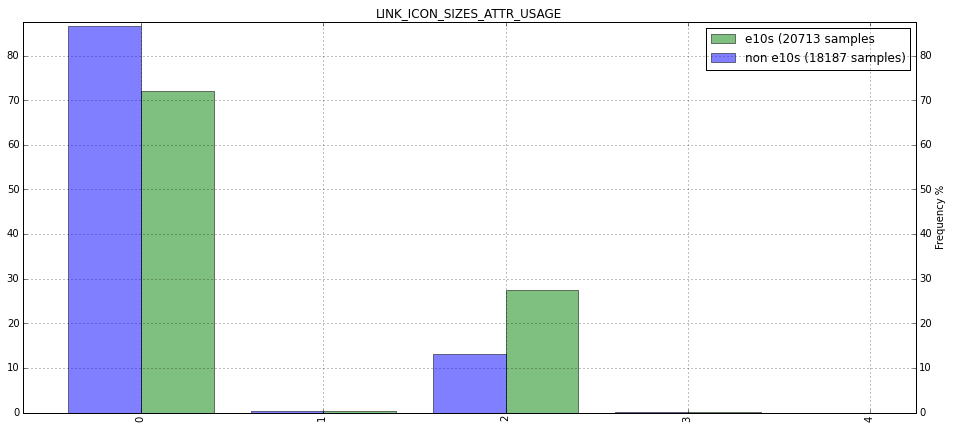

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_CACHED_V2 is 0.0321123587098


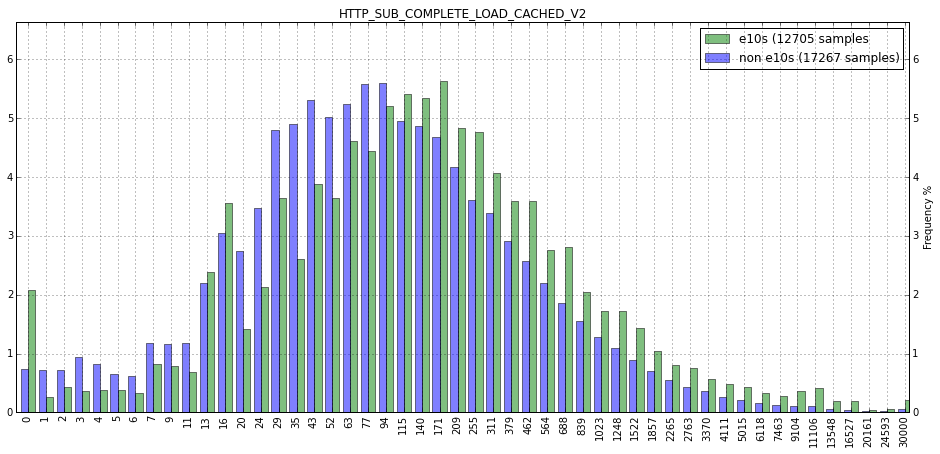

The chi2 distance for HTTP_SUB_COMPLETE_LOAD is 0.0320988126791


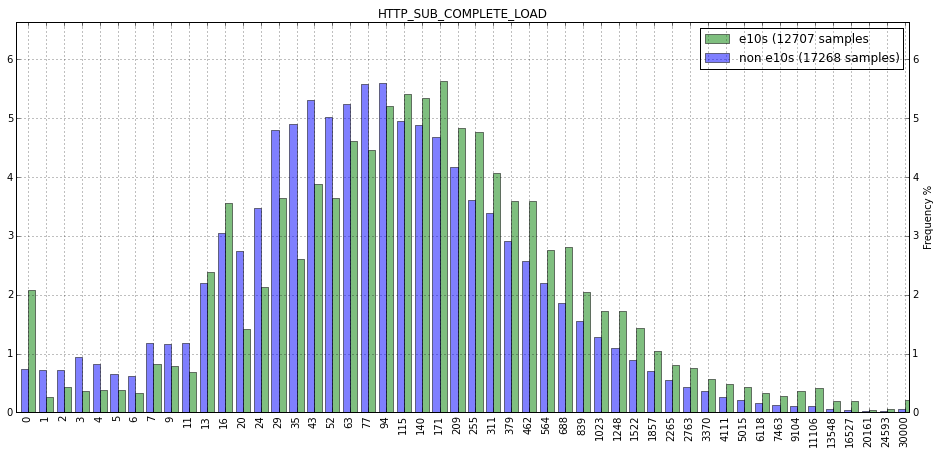

The chi2 distance for NETWORK_CACHE_V2_INPUT_STREAM_STATUS is 0.0317767814967


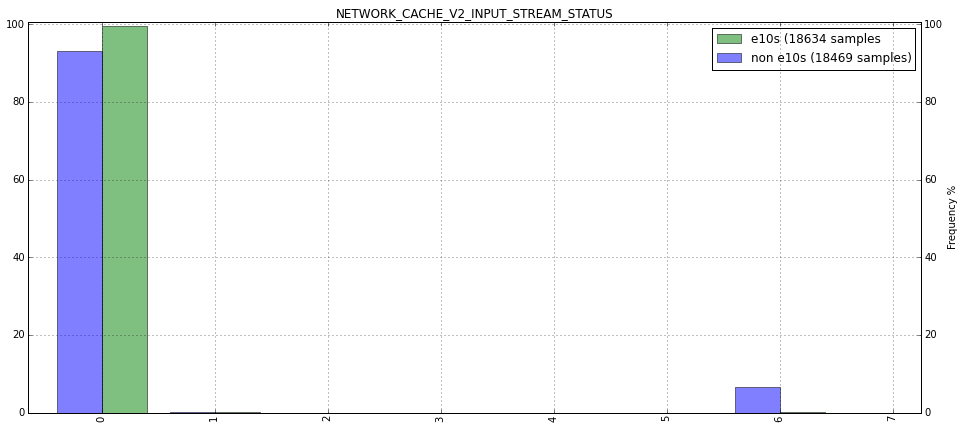

The chi2 distance for STS_NUMBER_OF_ONSOCKETREADY_CALLS is 0.0316487143893


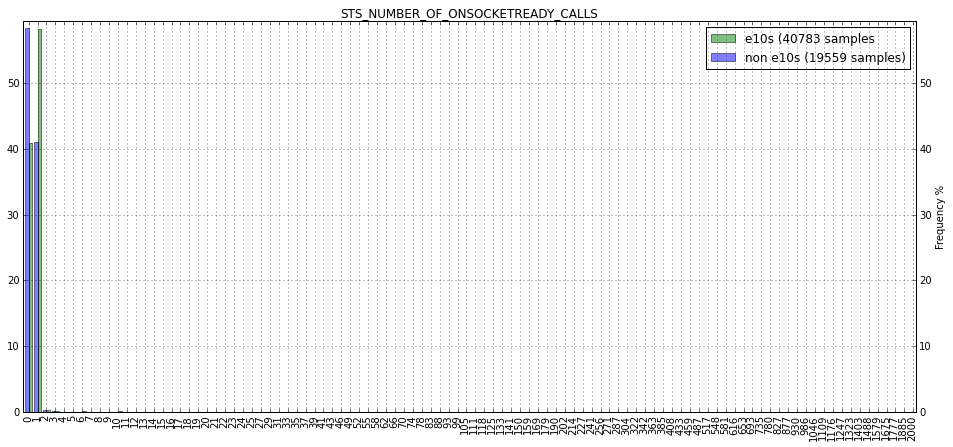

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_RECEIVED is 0.0315596846469


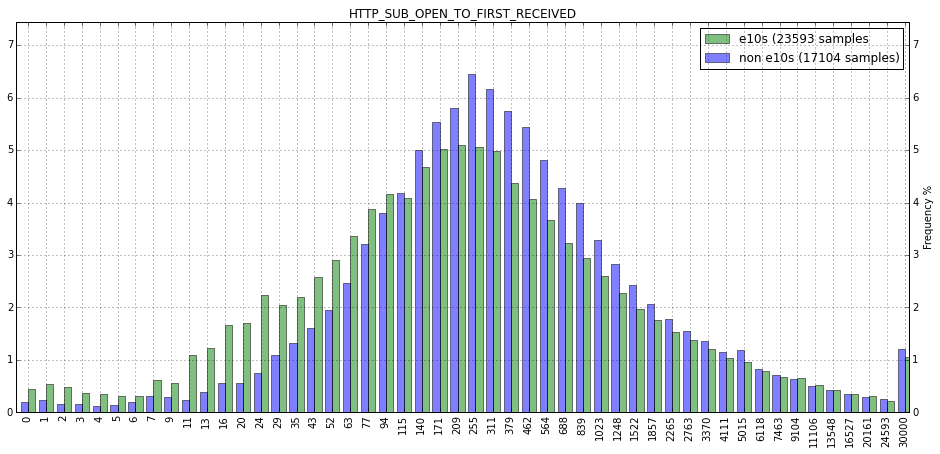

The chi2 distance for GC_MAX_PAUSE_MS is 0.0314614789538


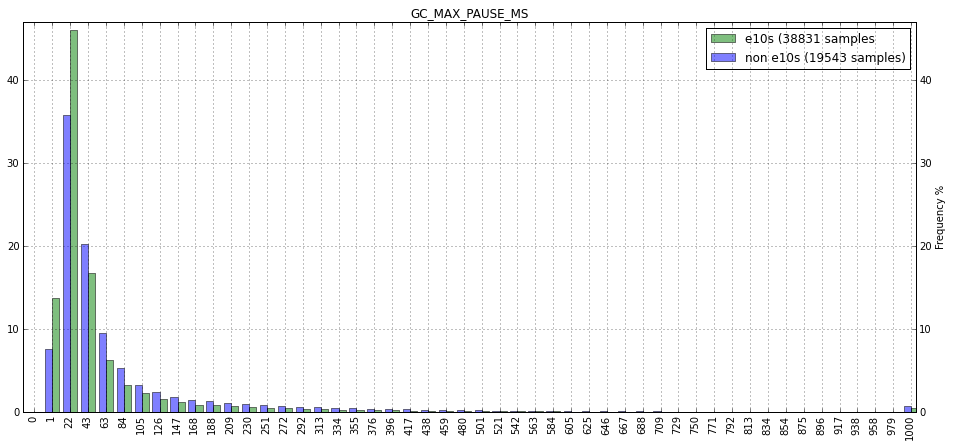

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_V2 is 0.0303297355269


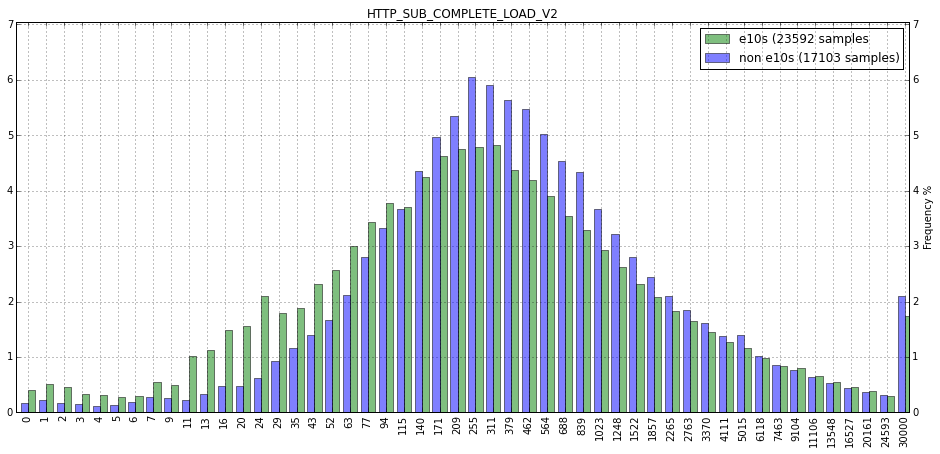

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_NET_V2 is 0.0303297355269


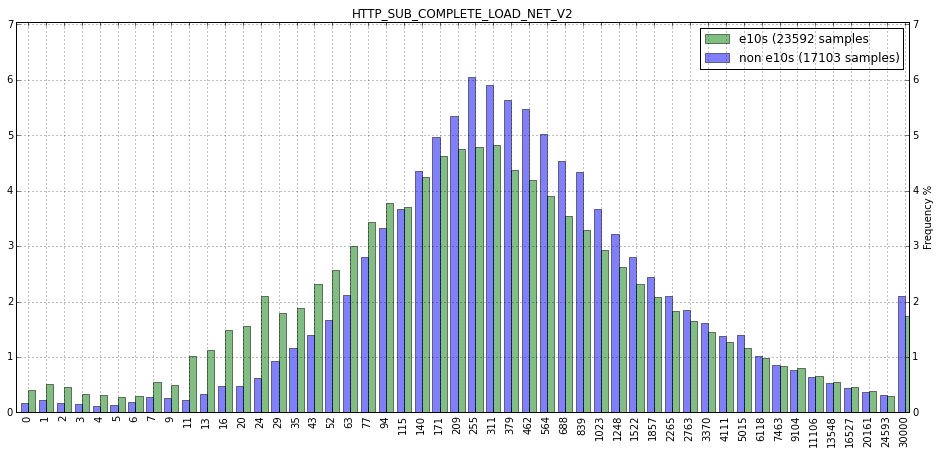

The chi2 distance for MEMORY_VSIZE_MAX_CONTIGUOUS is 0.0301793077495


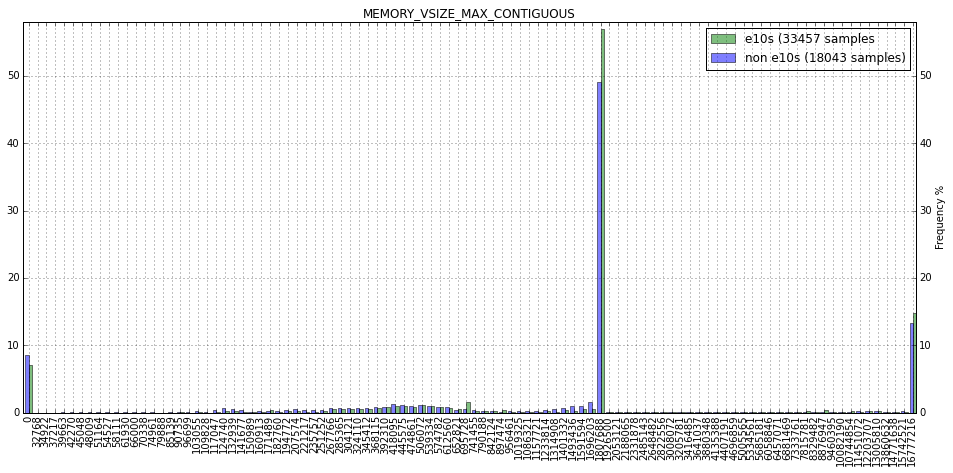

The chi2 distance for FX_PAGE_LOAD_MS is 0.0301497729609


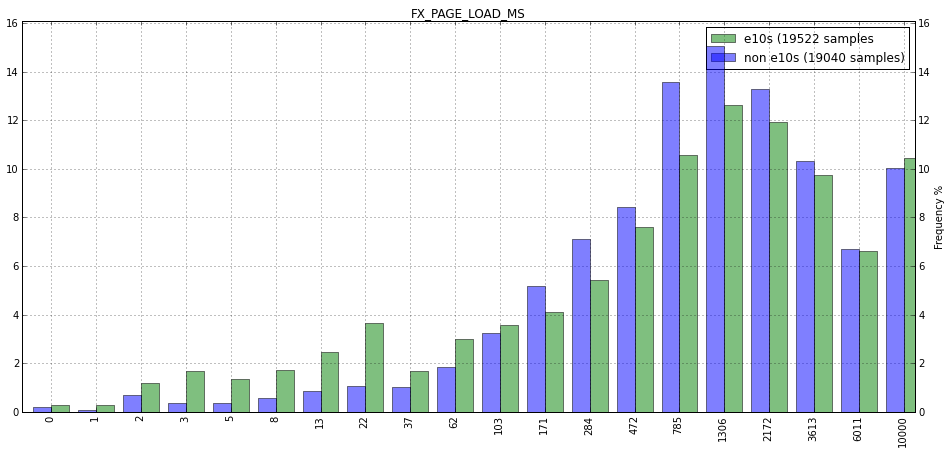

The chi2 distance for SYSTEM_FONT_FALLBACK is 0.030018077937


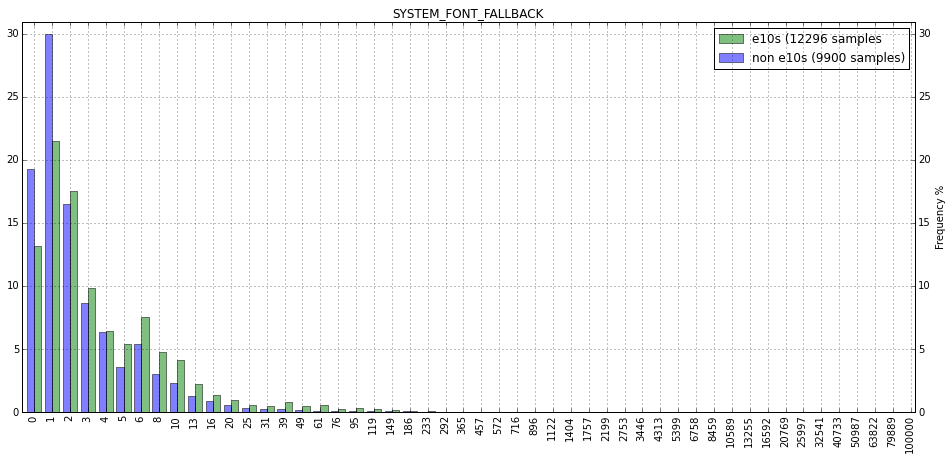

The chi2 distance for GC_SCC_SWEEP_MAX_PAUSE_MS is 0.029679167571


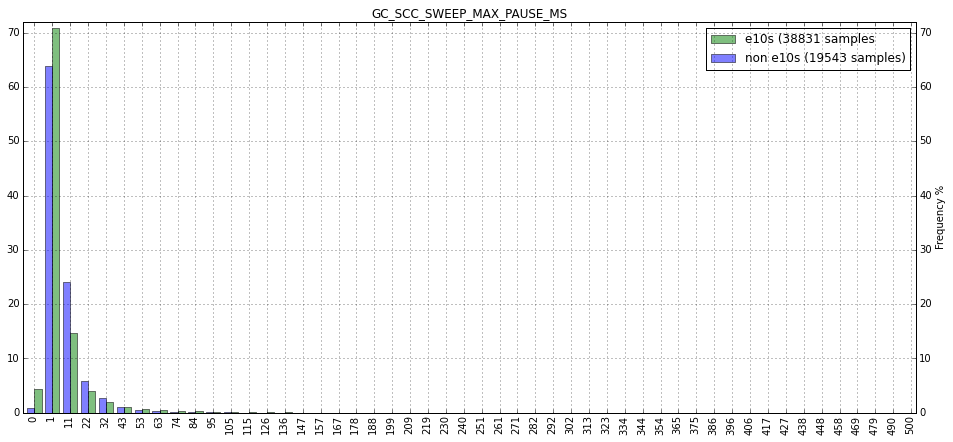

The chi2 distance for GC_MINOR_US is 0.0282110298662


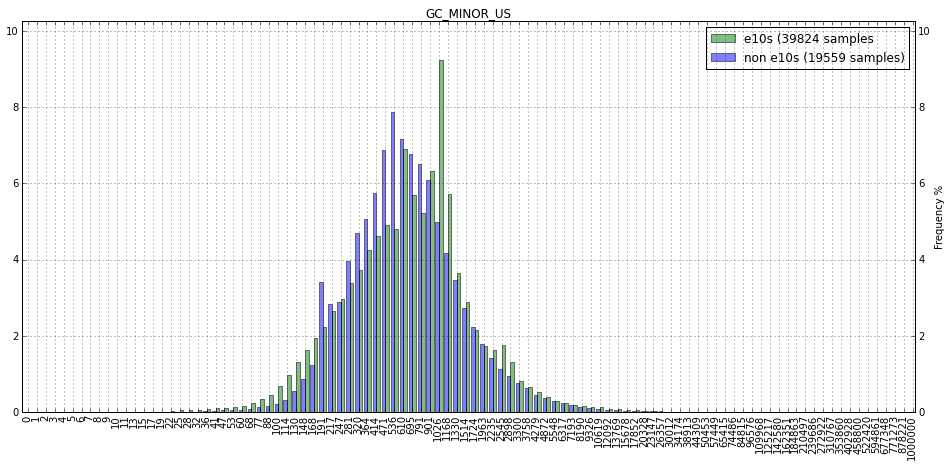

The chi2 distance for GC_SLICE_MS is 0.0275198815097


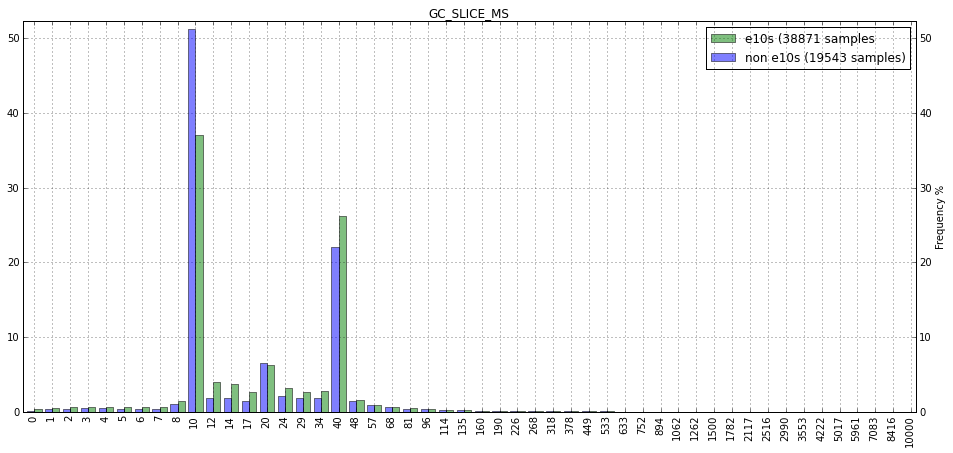

The chi2 distance for FLASH_PLUGIN_WIDTH is 0.0263368273827


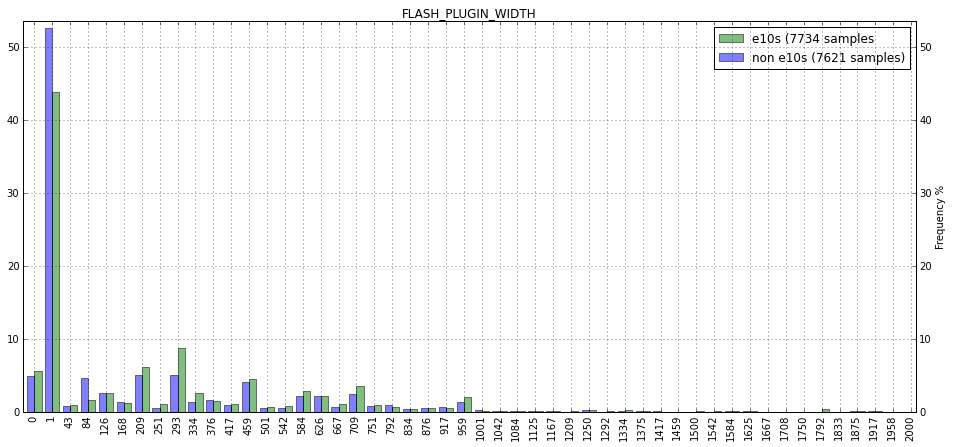

The chi2 distance for AUDIOSTREAM_FIRST_OPEN_MS is 0.0255242419448


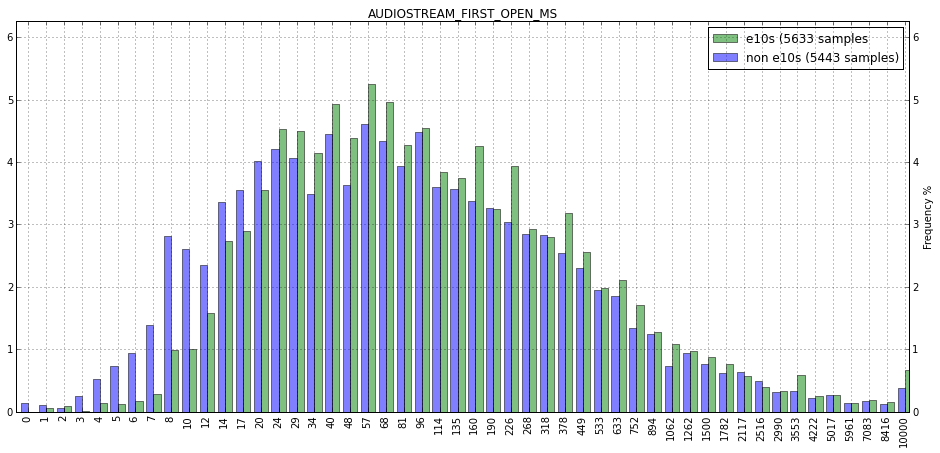

The chi2 distance for GC_ANIMATION_MS is 0.0238230892008


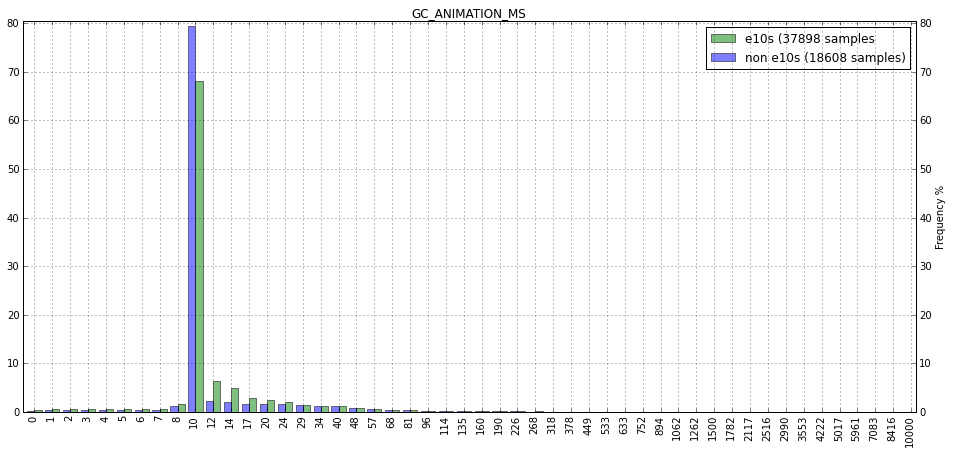

The chi2 distance for GRADIENT_DURATION is 0.0222602840691


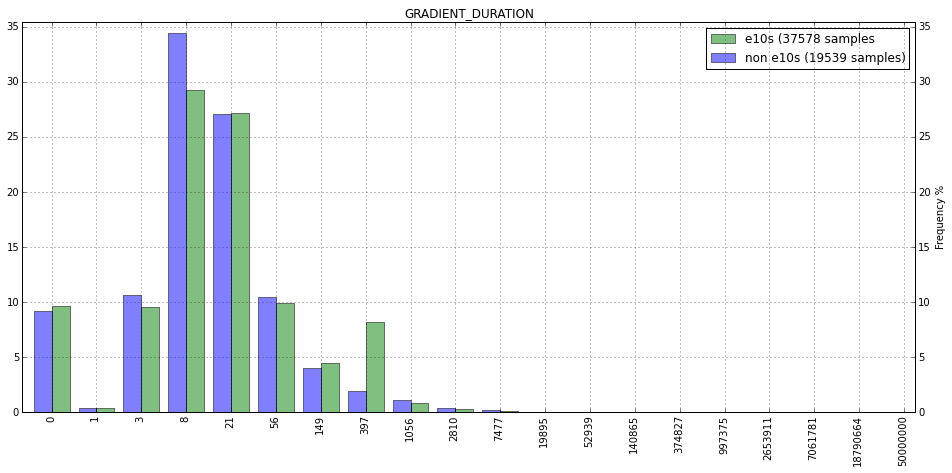

The chi2 distance for HTTP_SUBITEM_OPEN_LATENCY_TIME is 0.0200520174386


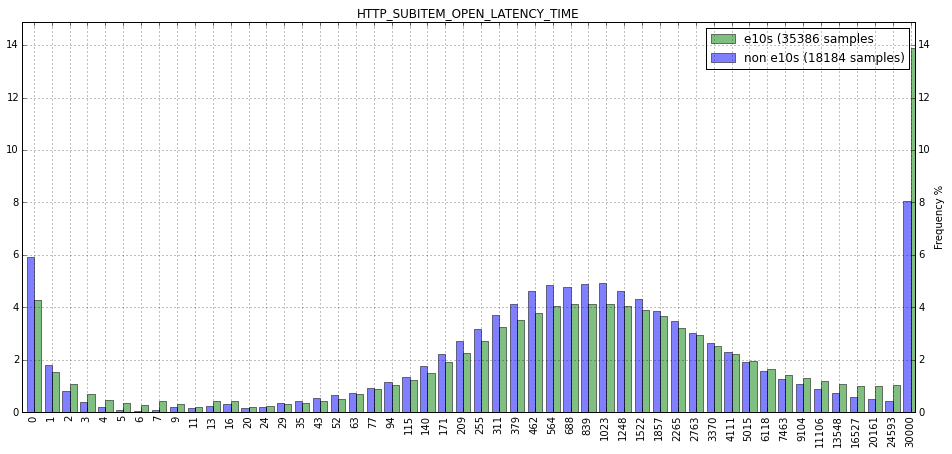

The chi2 distance for TOTAL_CONTENT_PAGE_LOAD_TIME is 0.0198777153548


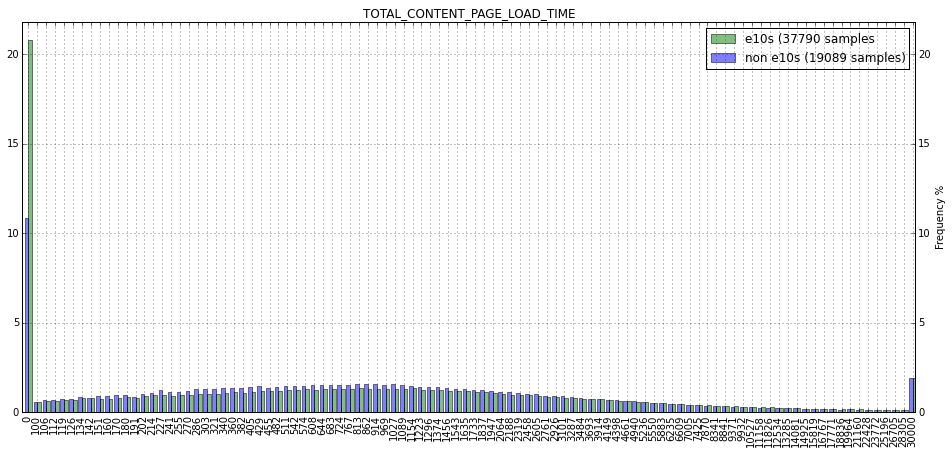

The chi2 distance for MOZ_SQLITE_OTHER_WRITE_B is 0.0194688177359


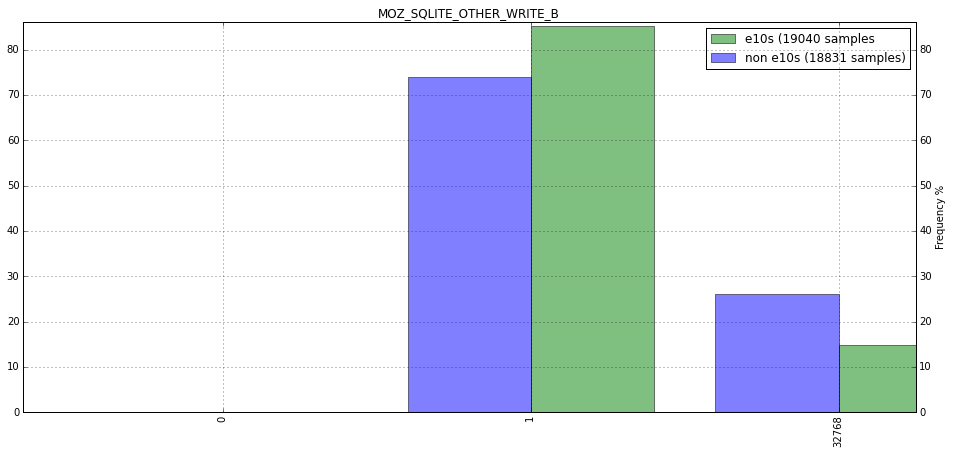

The chi2 distance for FLASH_PLUGIN_HEIGHT is 0.0187703689463


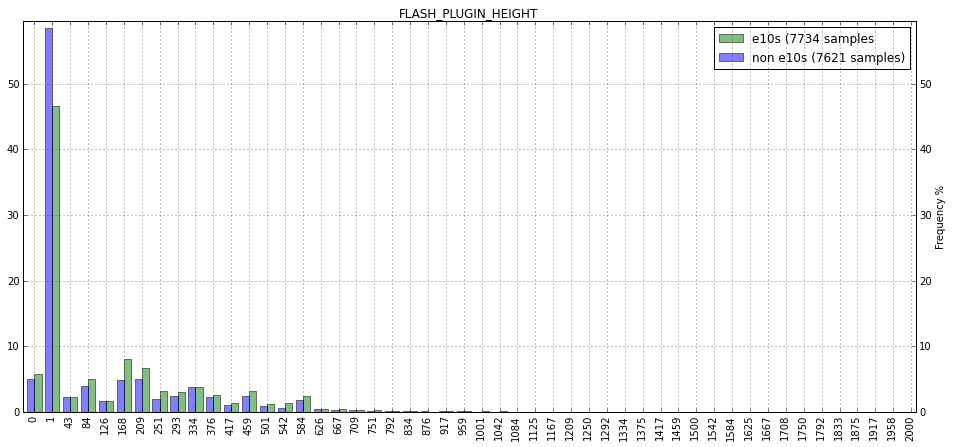

The chi2 distance for PLACES_FAVICON_ICO_SIZES is 0.0179171069985


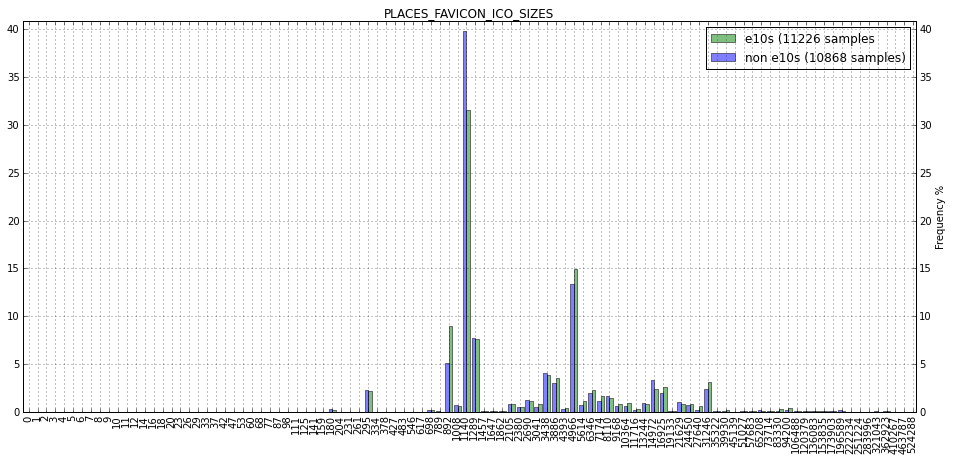

The chi2 distance for GC_BUDGET_MS is 0.0175074457071


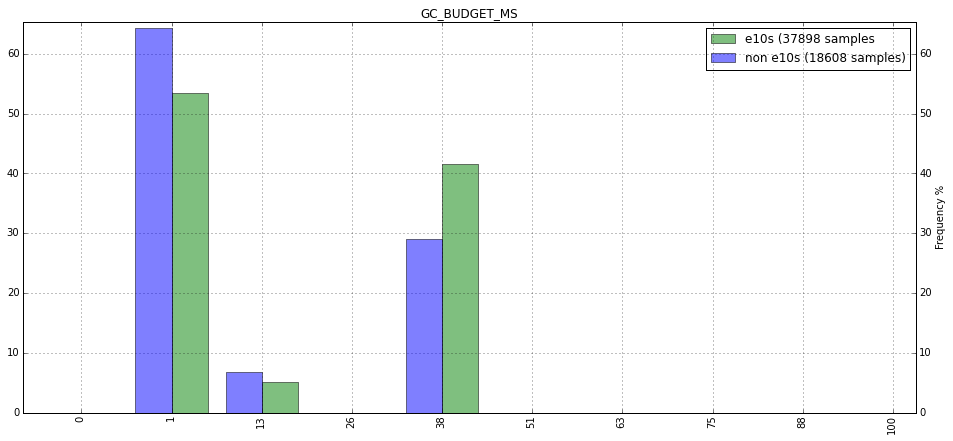

The chi2 distance for CYCLE_COLLECTOR_COLLECTED is 0.0172996997994


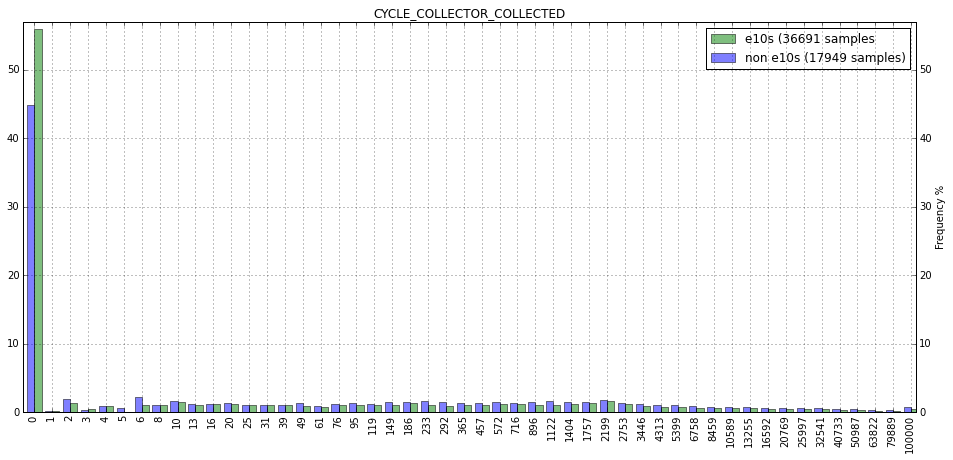

The chi2 distance for PLUGIN_SHUTDOWN_MS is 0.0167384411759


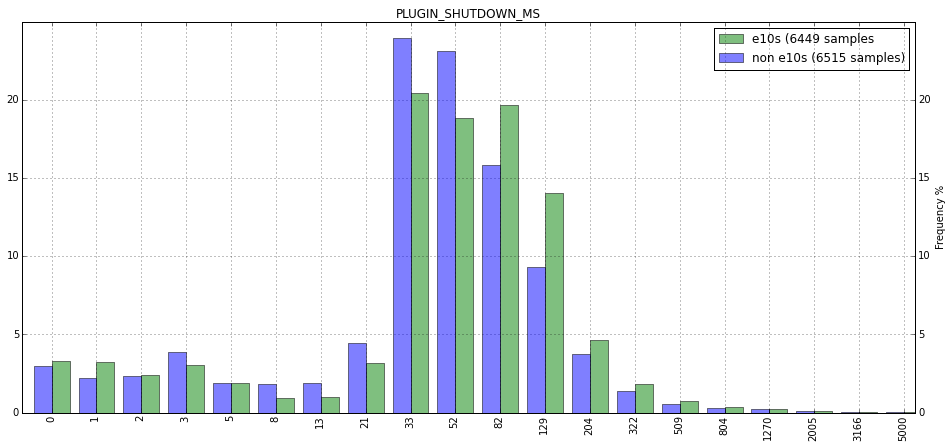

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_INACTION is 0.0167139177543


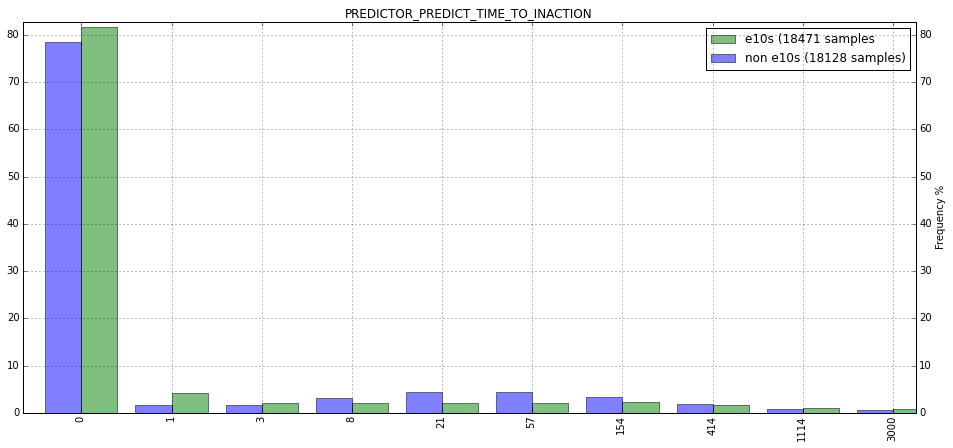

The chi2 distance for FX_THUMBNAILS_STORE_TIME_MS is 0.0165175315208


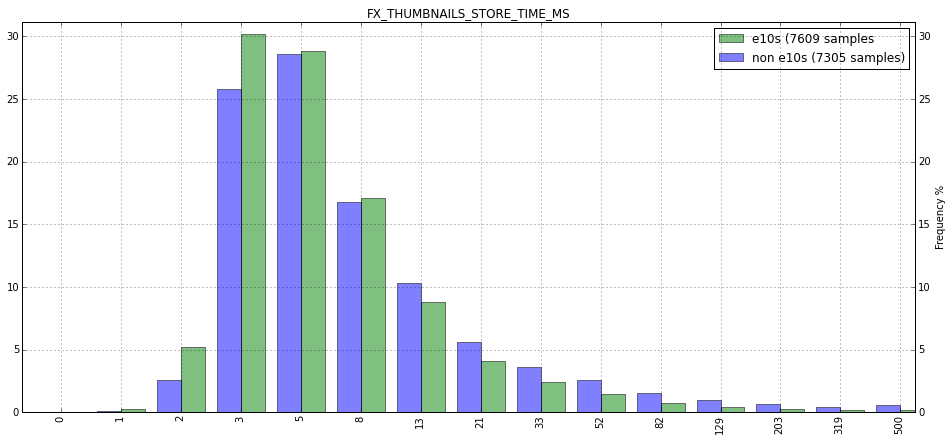

The chi2 distance for [[COUNT]]_JS_TELEMETRY_ADDON_EXCEPTIONS is 0.0163637246785


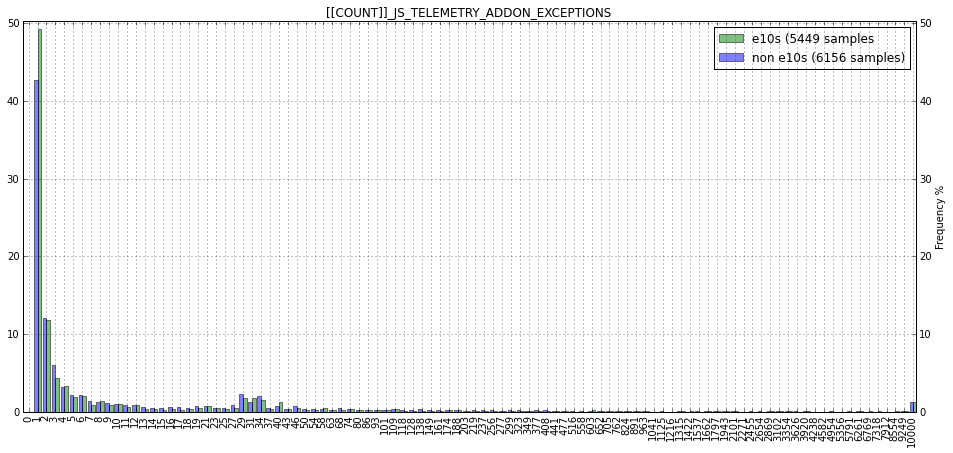

The chi2 distance for HTTP_PAGE_REVALIDATION is 0.0155896714531


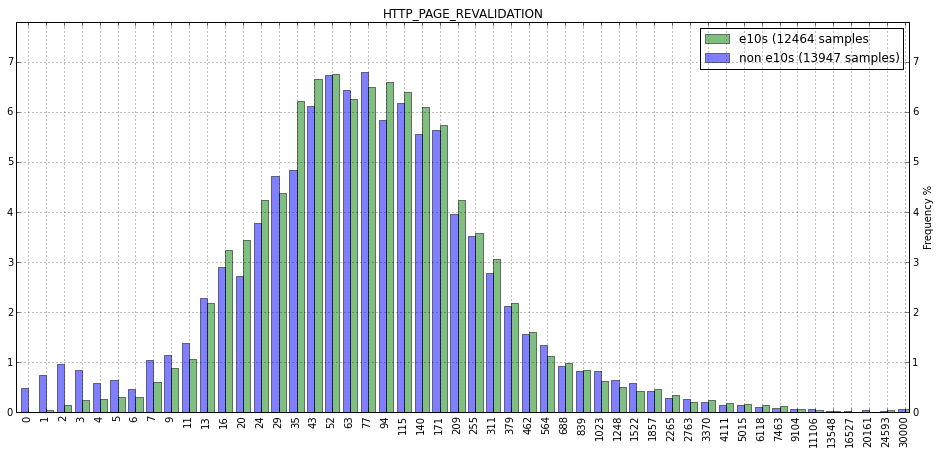

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_ACTION is 0.0153967724155


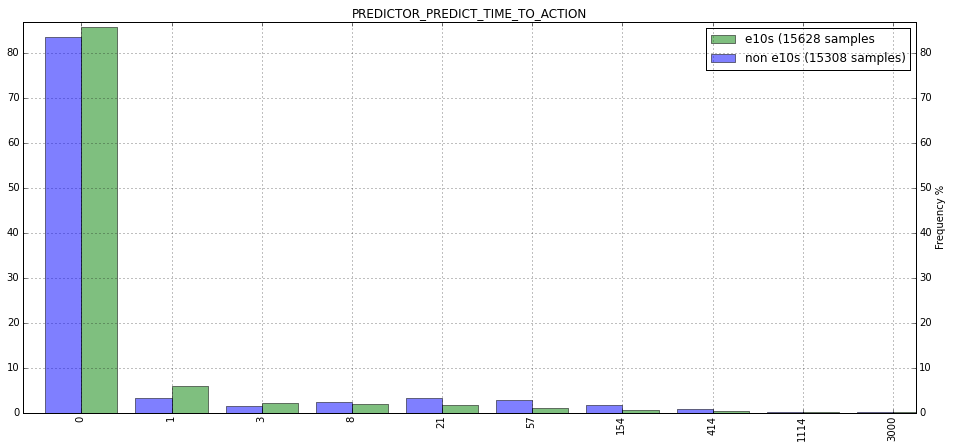

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS is 0.014529454555


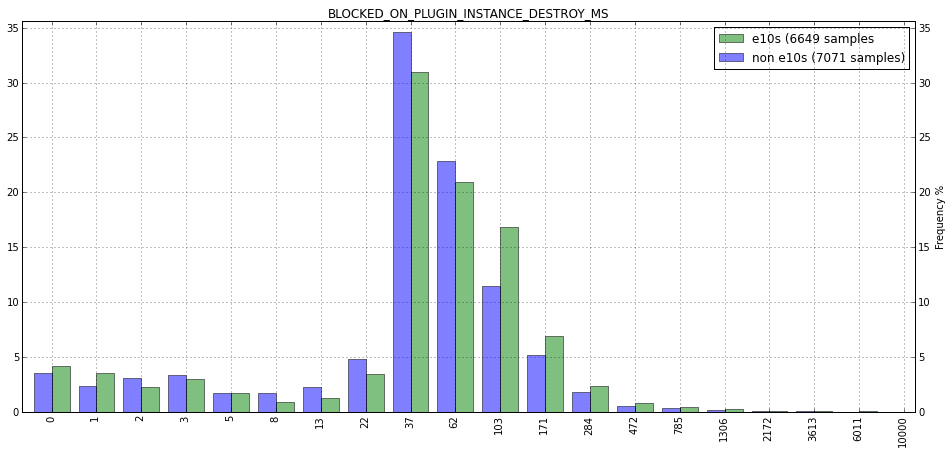

The chi2 distance for COOKIE_SCHEME_SECURITY is 0.0144051663177


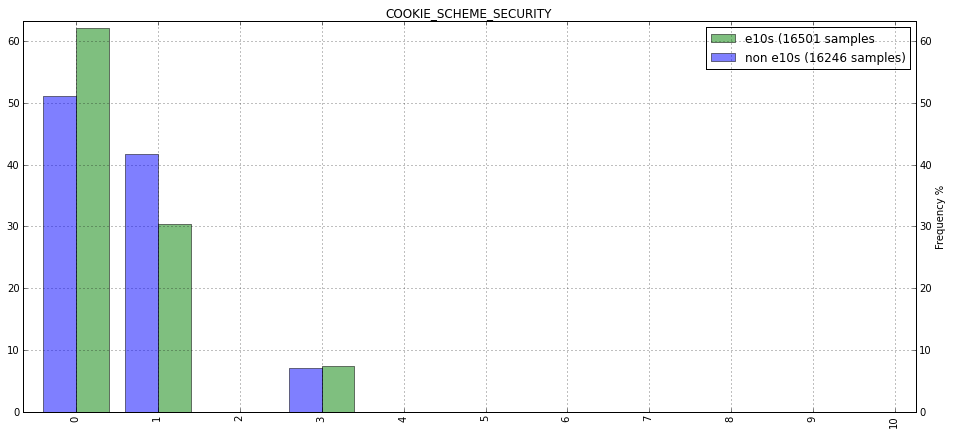

The chi2 distance for NEWTAB_PAGE_LIFE_SPAN is 0.014351205064


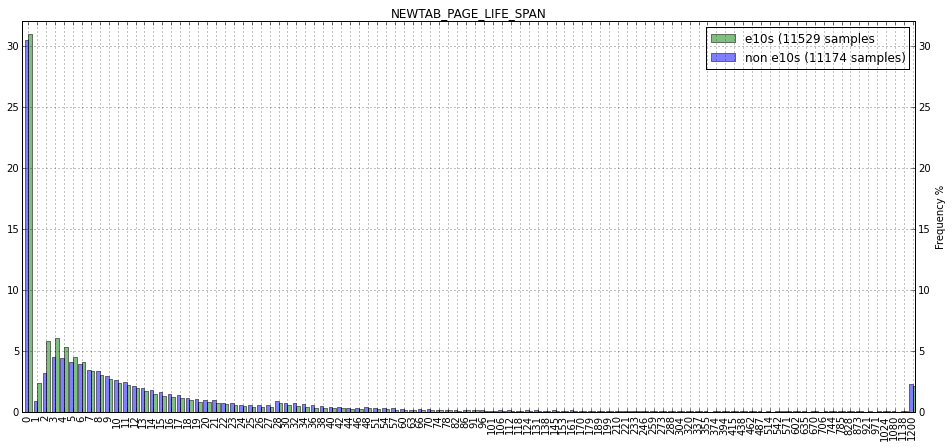

The chi2 distance for FORGET_SKIPPABLE_MAX is 0.0143458956572


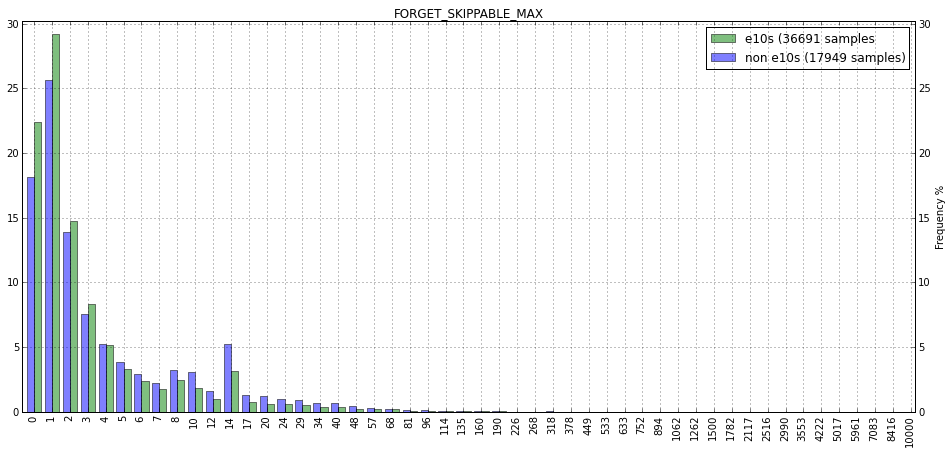

The chi2 distance for HTTP_REQUEST_PER_PAGE is 0.0142616468655


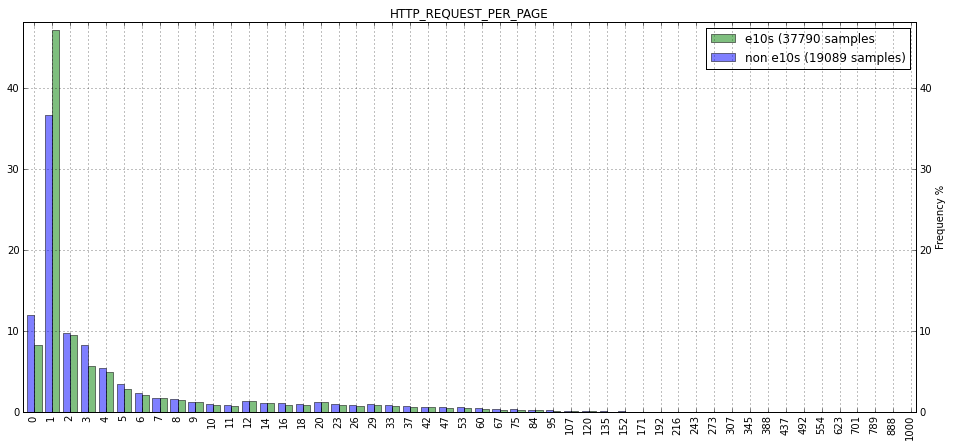

The chi2 distance for PREDICTOR_PREDICT_WORK_TIME is 0.014108823784


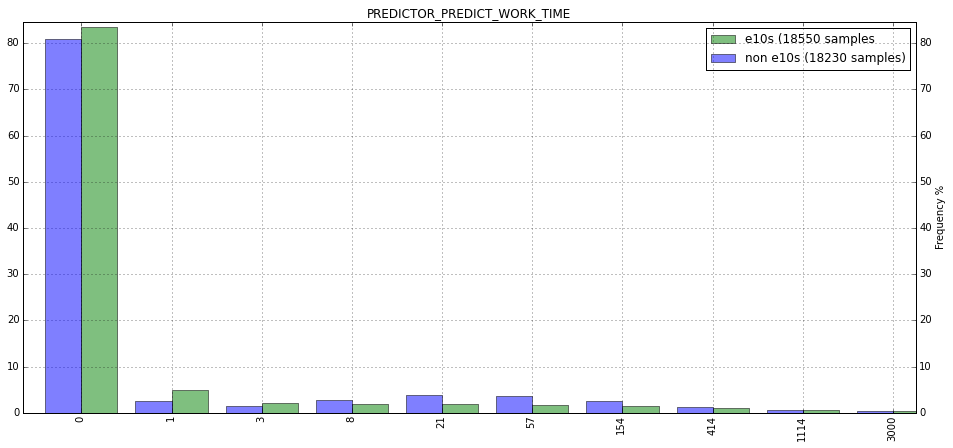

The chi2 distance for FXA_CONFIGURED is 0.0141025985755


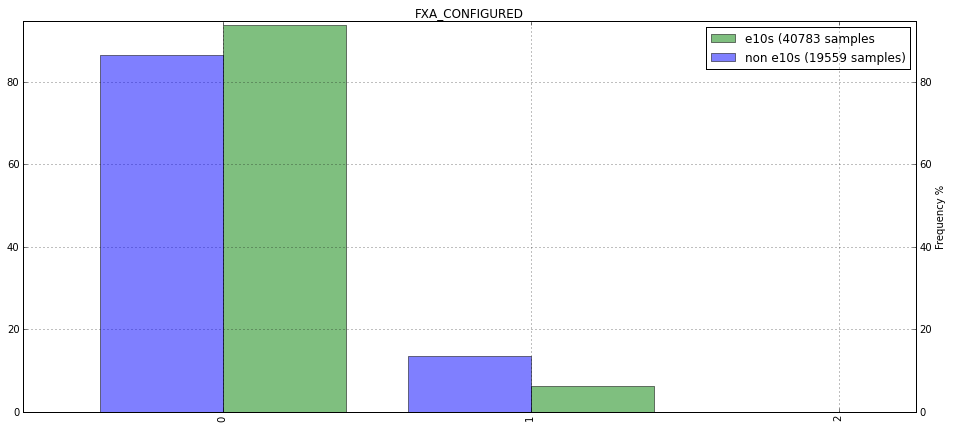

The chi2 distance for [[COUNT]]_CONTENT_DOCUMENTS_DESTROYED is 0.0140987044185


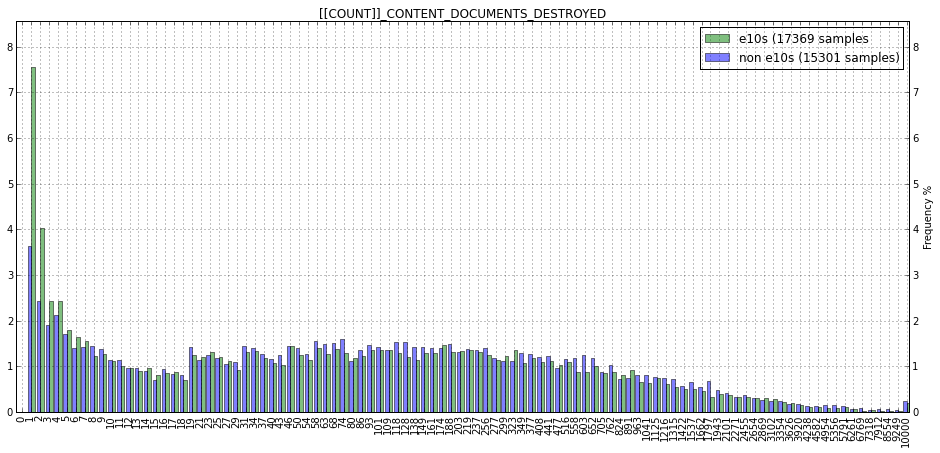

The chi2 distance for CYCLE_COLLECTOR_TIME_BETWEEN is 0.0136736471636


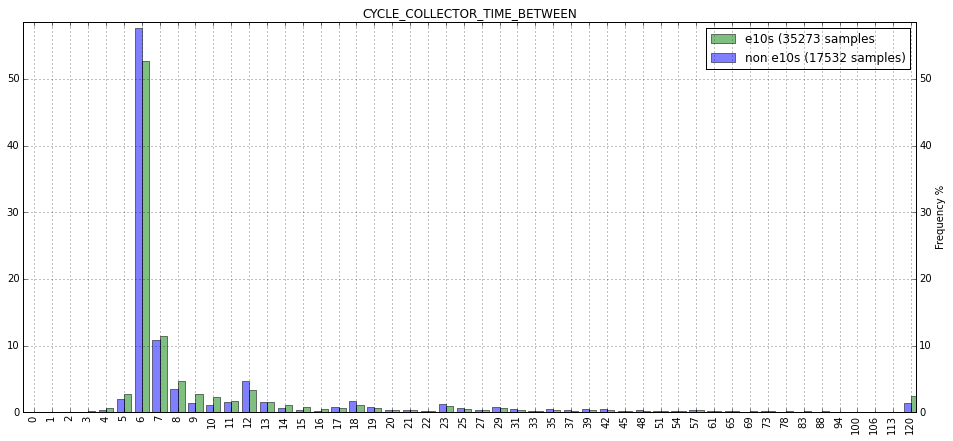

The chi2 distance for MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED is 0.0136279416278


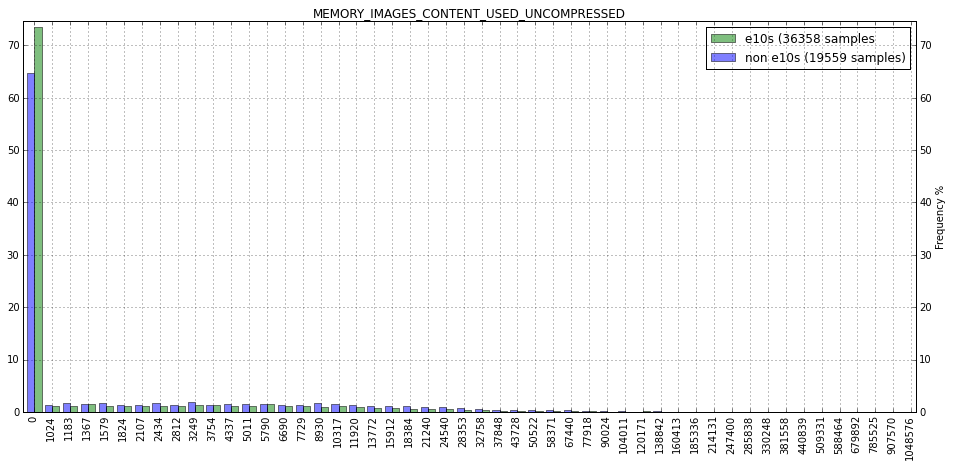

The chi2 distance for GDI_INITFONTLIST_TOTAL is 0.0133528590352


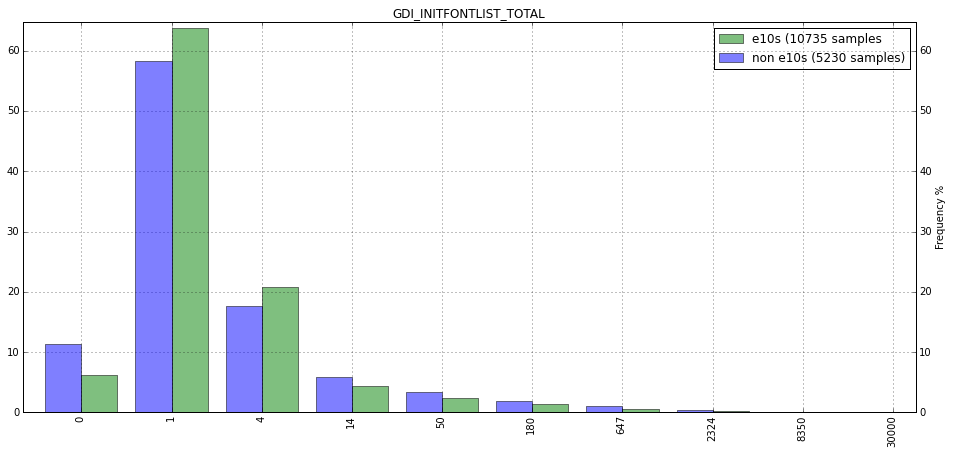

The chi2 distance for HTTP_CACHE_ENTRY_ALIVE_TIME is 0.0126464717718


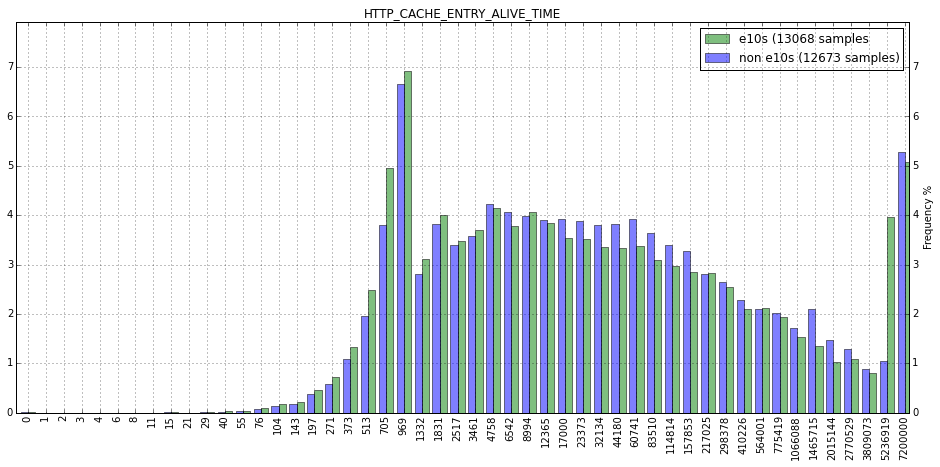

The chi2 distance for STARTUP_DNS_LOOKUP_METHOD2 is 0.0122461173156


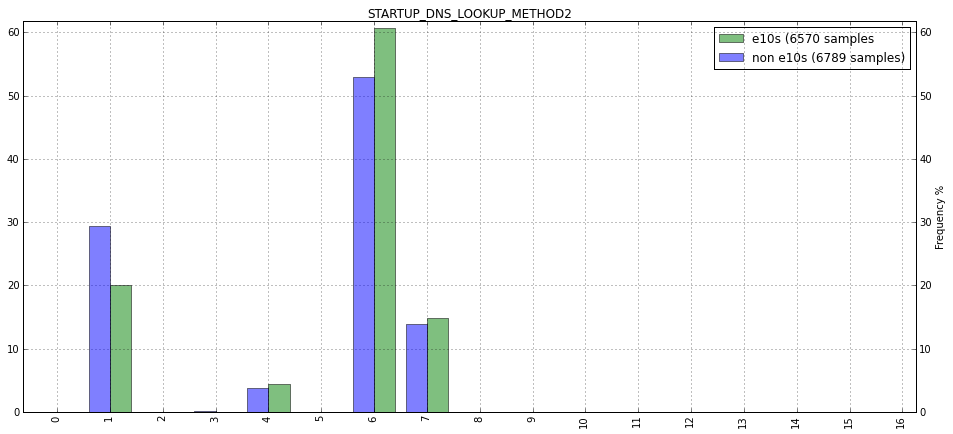

The chi2 distance for TELEMETRY_STRINGIFY is 0.0120807259331


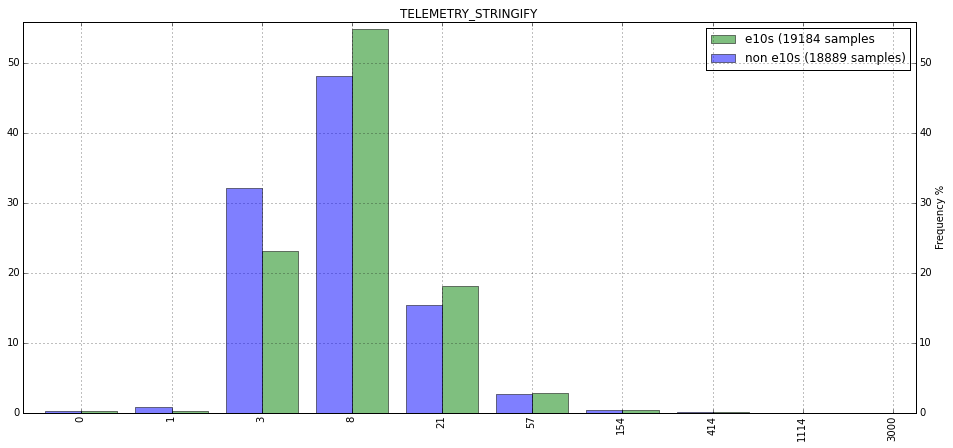

The chi2 distance for STS_POLL_BLOCK_TIME is 0.011905658832


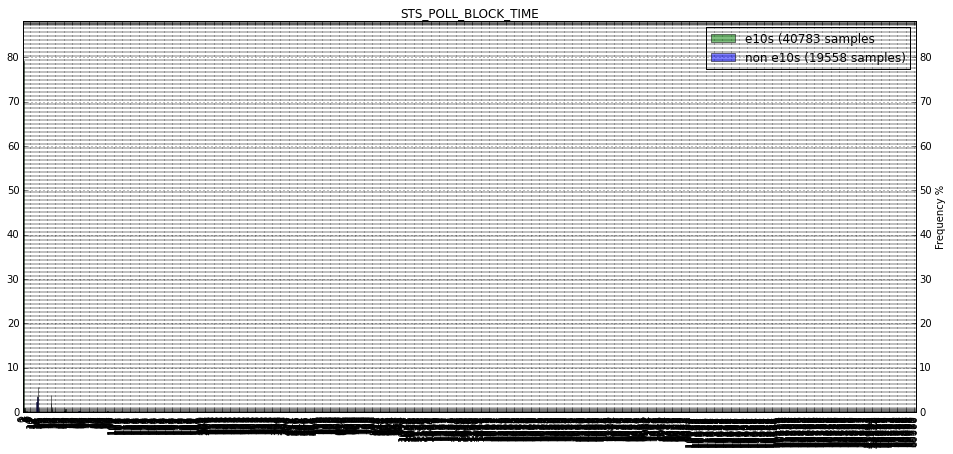

The chi2 distance for CYCLE_COLLECTOR_MAX_PAUSE is 0.011544005763


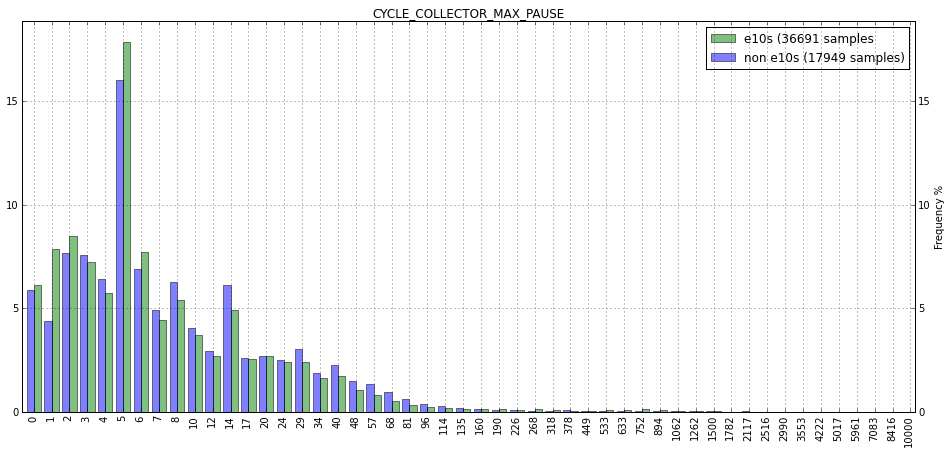

The chi2 distance for HEALTHREPORT_INIT_MS is 0.0114003202536


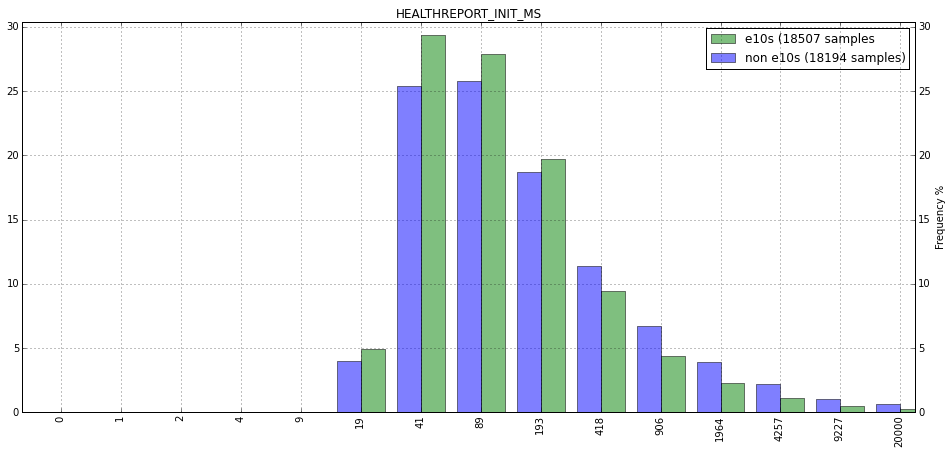

The chi2 distance for WORD_CACHE_HITS_CONTENT is 0.0112188225311


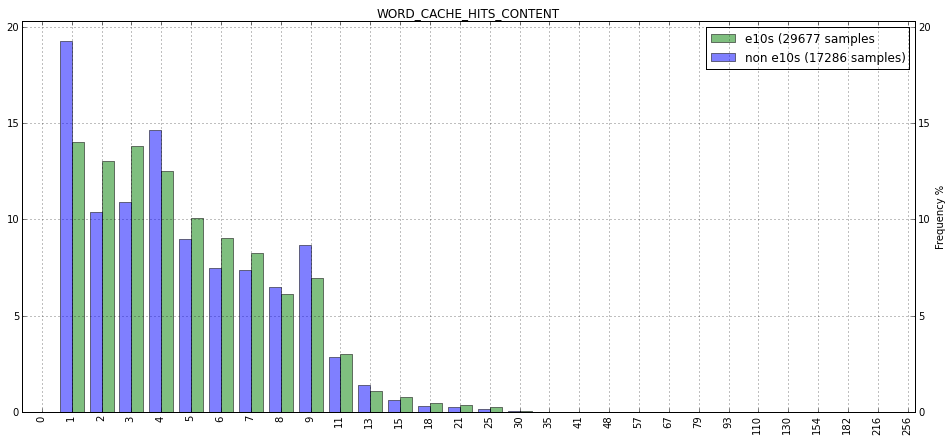

The chi2 distance for VIDEO_H264_SPS_MAX_NUM_REF_FRAMES is 0.0109730583547


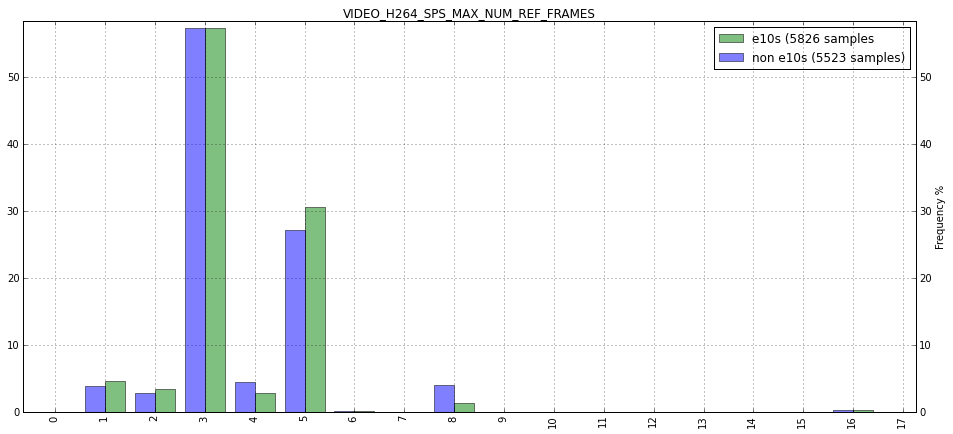

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_TOTAL is 0.0109469752034


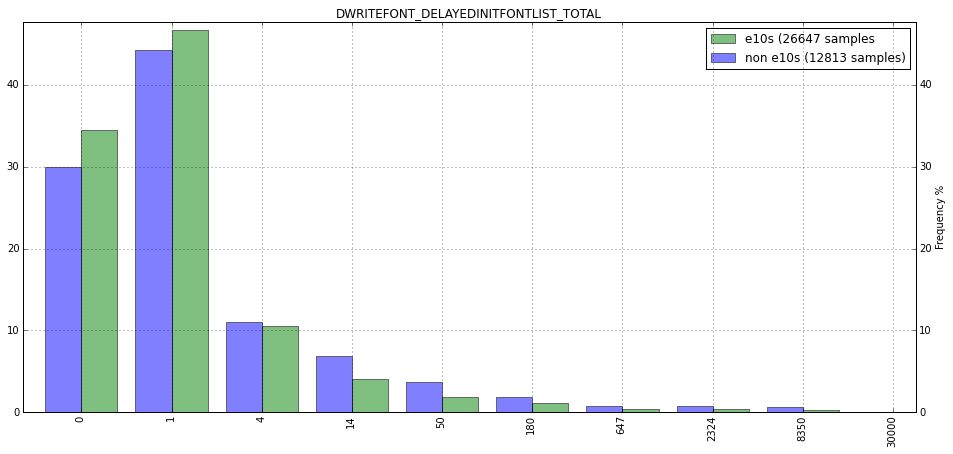

The chi2 distance for WEAVE_CAN_FETCH_KEYS is 0.0106238445892


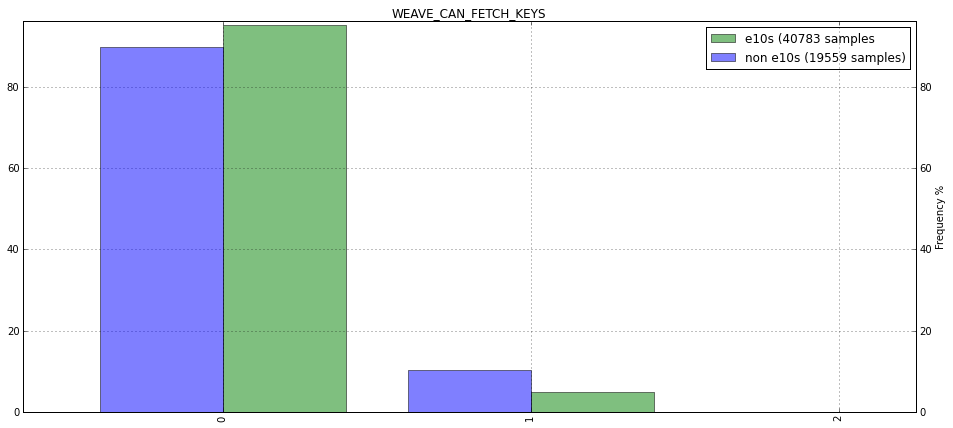

The chi2 distance for CRASH_STORE_COMPRESSED_BYTES is 0.0105797923824


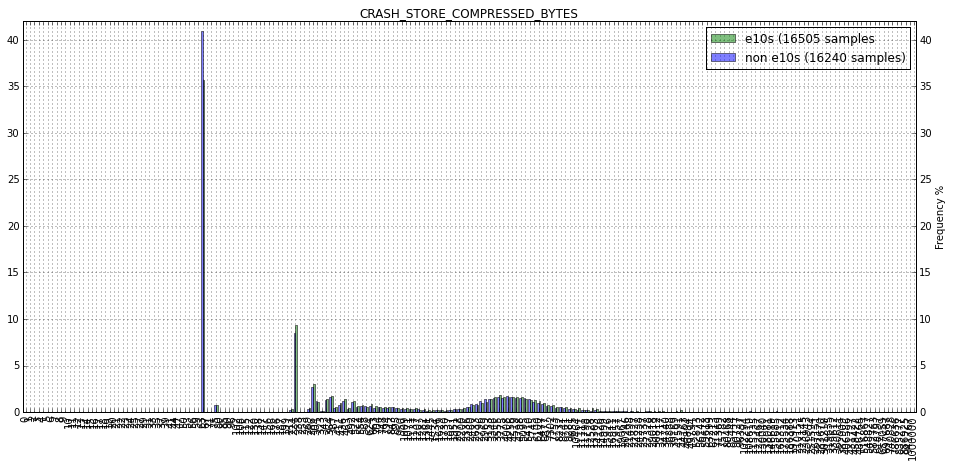

The chi2 distance for NETWORK_CACHE_HIT_MISS_STAT_PER_CACHE_SIZE is 0.0099215428553


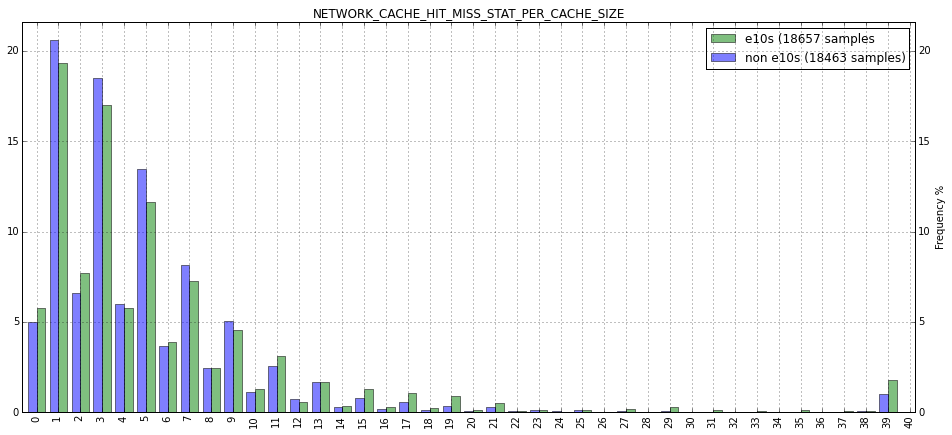

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_GCED is 0.00983171350165


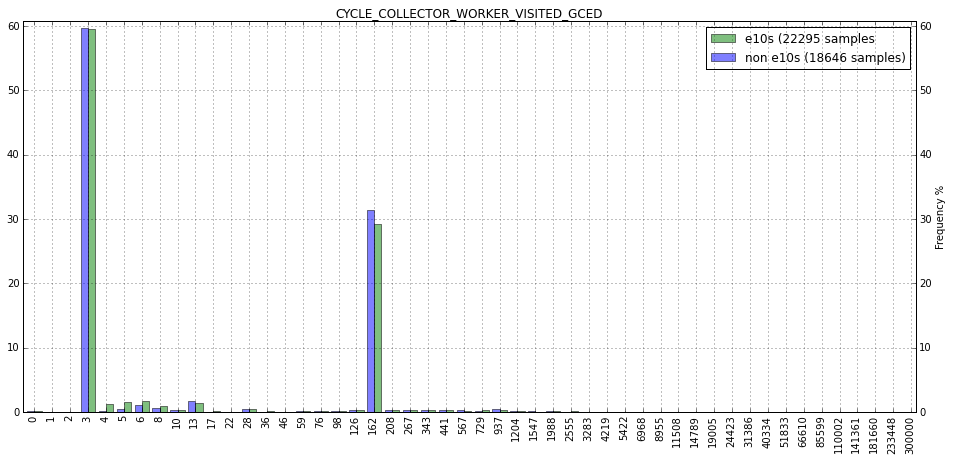

The chi2 distance for HTTP_SUB_CACHE_READ_TIME_V2 is 0.00981742019329


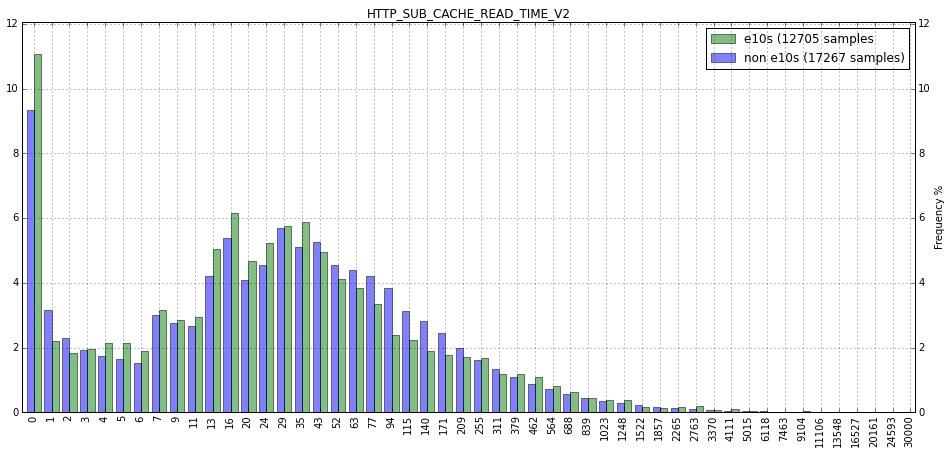

The chi2 distance for IDLE_NOTIFY_IDLE_MS is 0.00953248828661


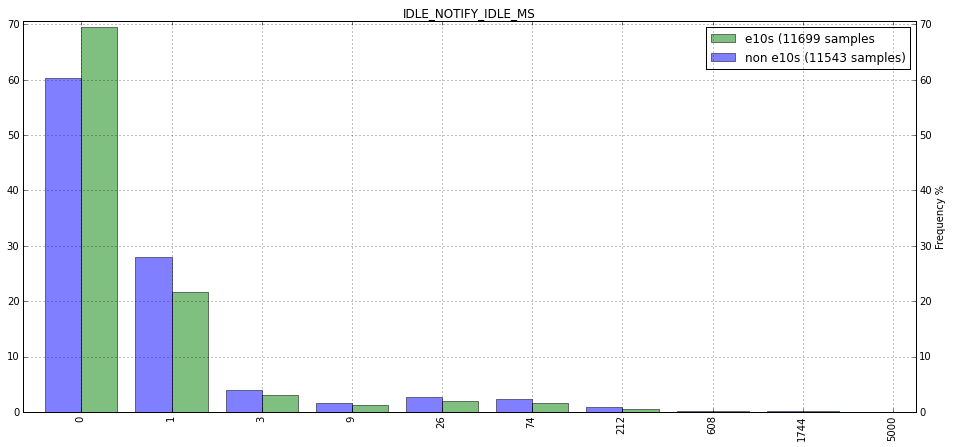

The chi2 distance for HTTP_SUB_FIRST_SENT_TO_LAST_RECEIVED is 0.00943272189089


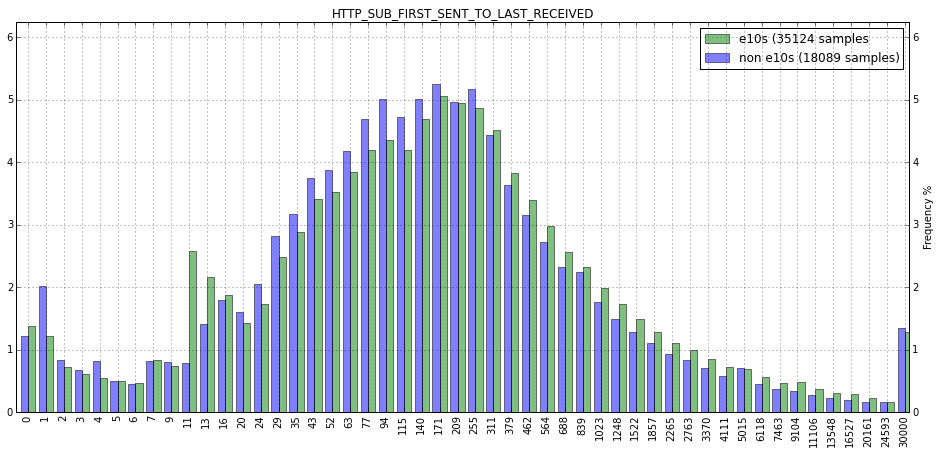

The chi2 distance for FX_SESSION_RESTORE_COLLECT_COOKIES_MS is 0.00939556225283


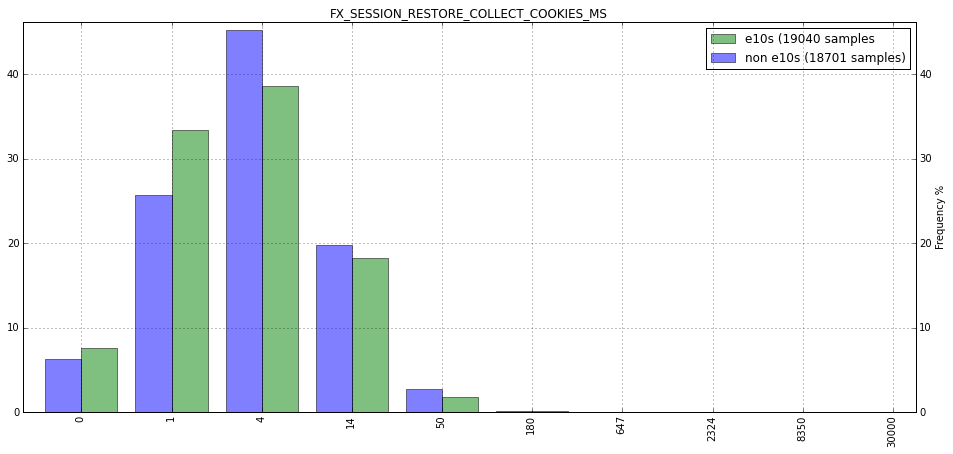

The chi2 distance for URL_PATH_CONTAINS_EXCLAMATION_SLASH is 0.00901703311792


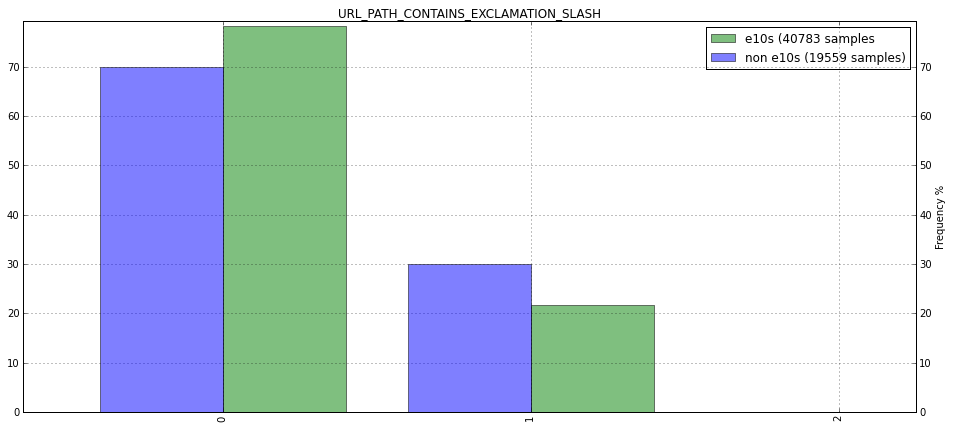

The chi2 distance for HTTP_SUBITEM_FIRST_BYTE_LATENCY_TIME is 0.00865504902503


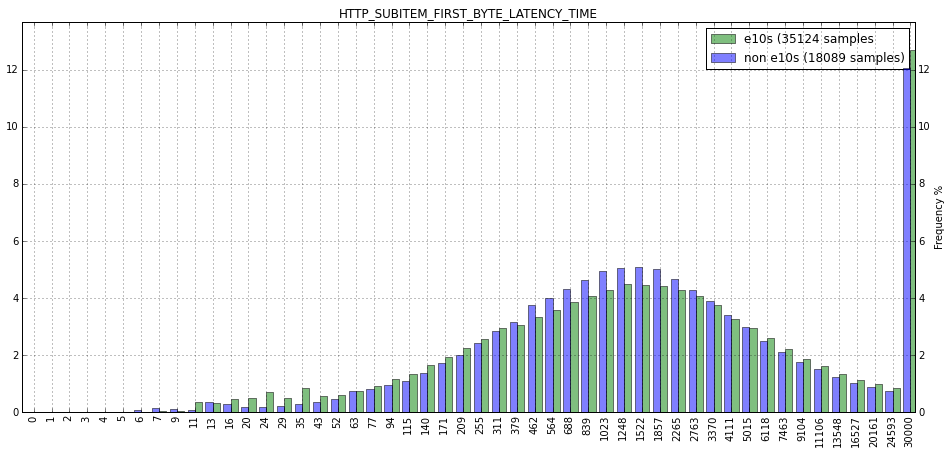

The chi2 distance for IPV4_AND_IPV6_ADDRESS_CONNECTIVITY is 0.00836239541567


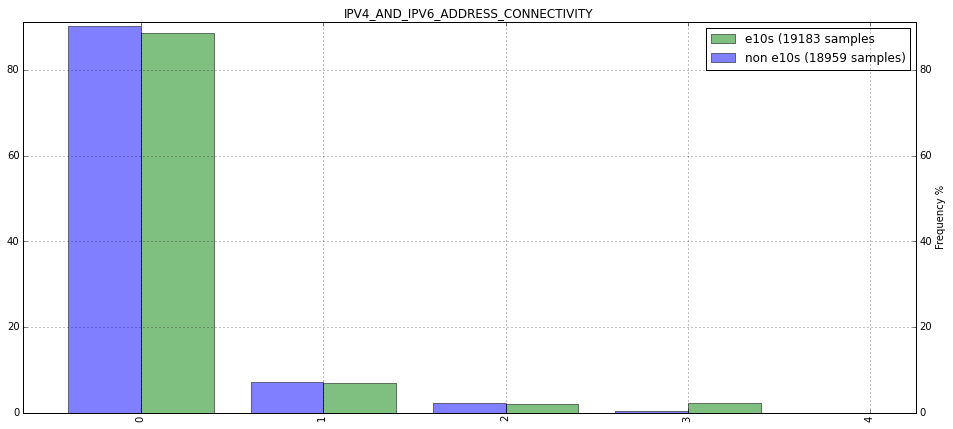

The chi2 distance for MOZ_SQLITE_OTHER_READ_B is 0.00833663157047


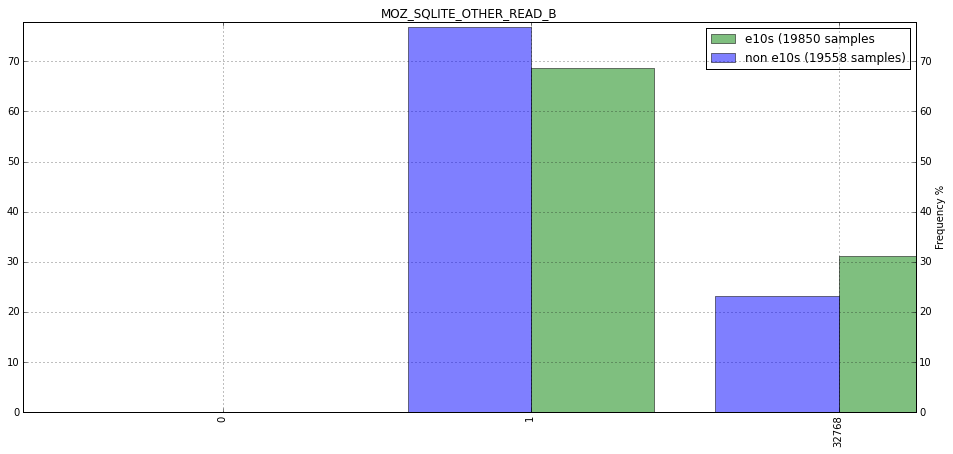

The chi2 distance for SSL_KEA_RSA_KEY_SIZE_FULL is 0.00832007923833


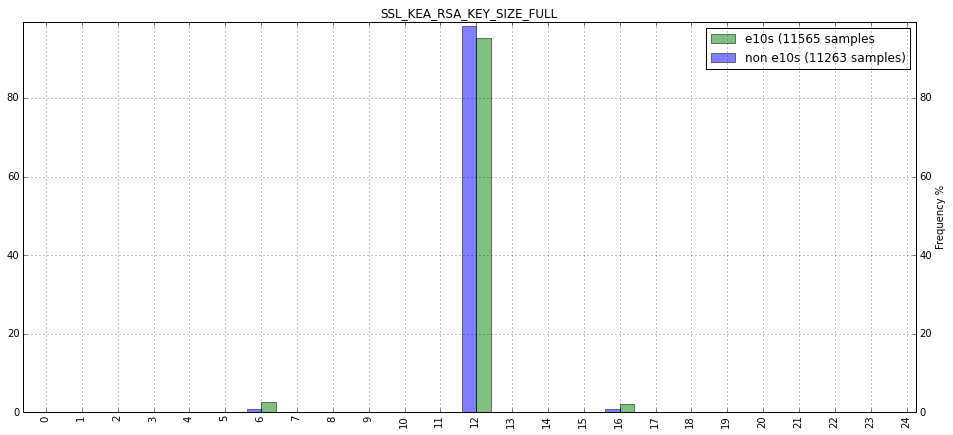

The chi2 distance for STARTUP_HTTP_SCHEME_UPGRADE is 0.00829315679943


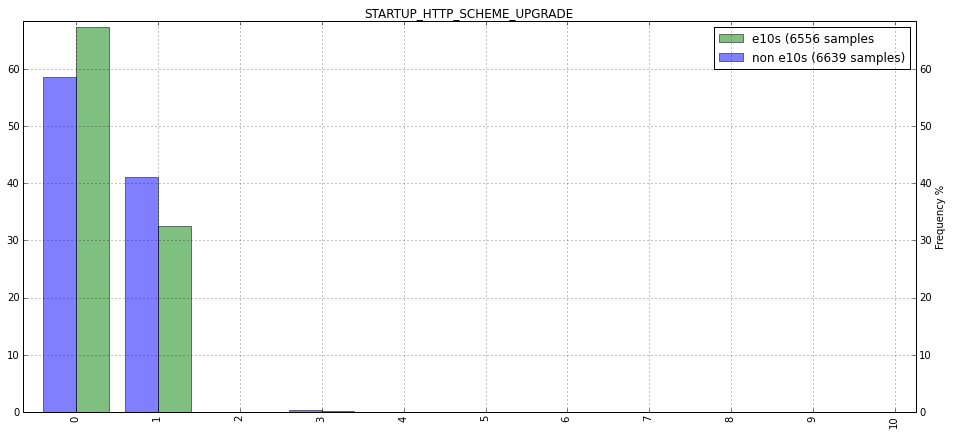

The chi2 distance for GC_SLOW_PHASE is 0.00810479590141


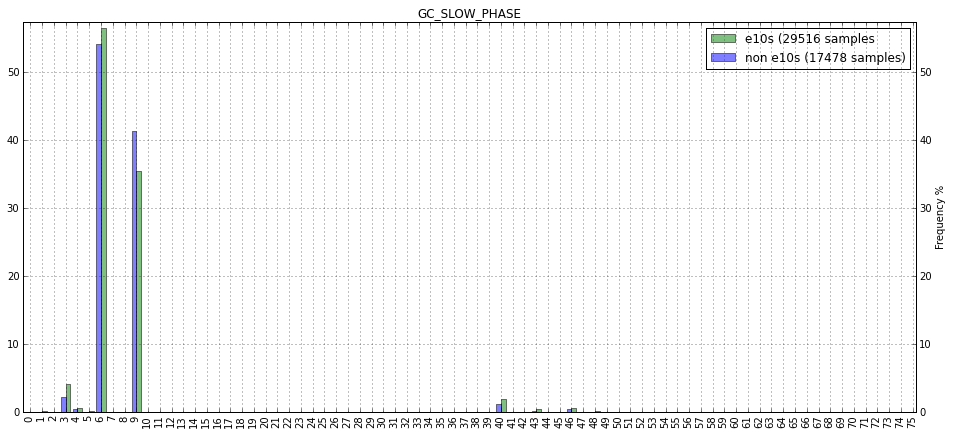

The chi2 distance for HEALTHREPORT_SHUTDOWN_MS is 0.00786932293313


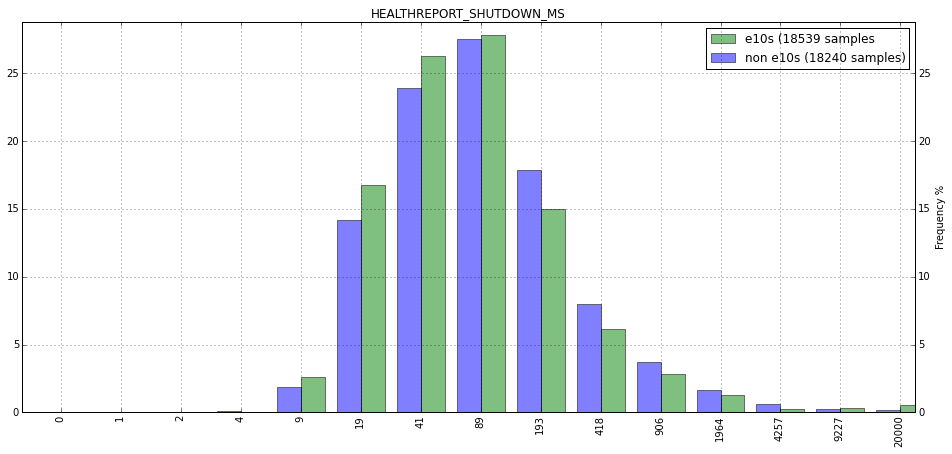

The chi2 distance for DEFERRED_FINALIZE_ASYNC is 0.00781549142887


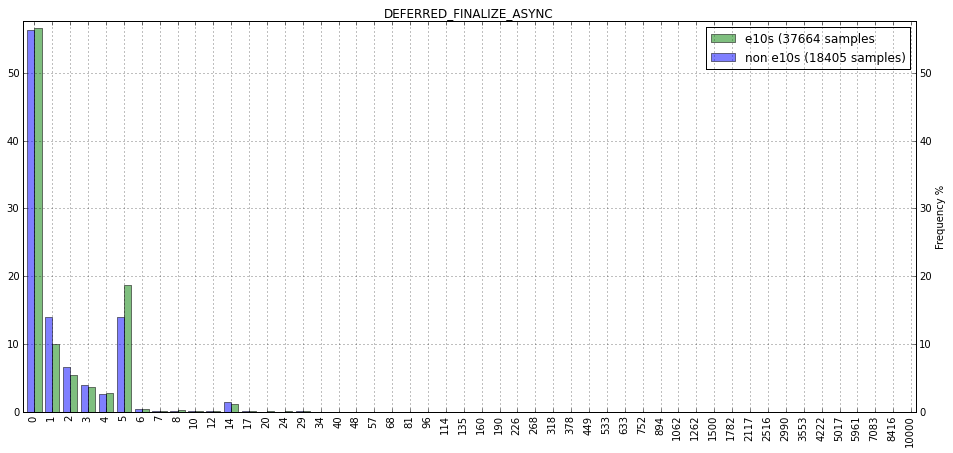

The chi2 distance for HEALTHREPORT_DB_OPEN_MS is 0.00779411914599


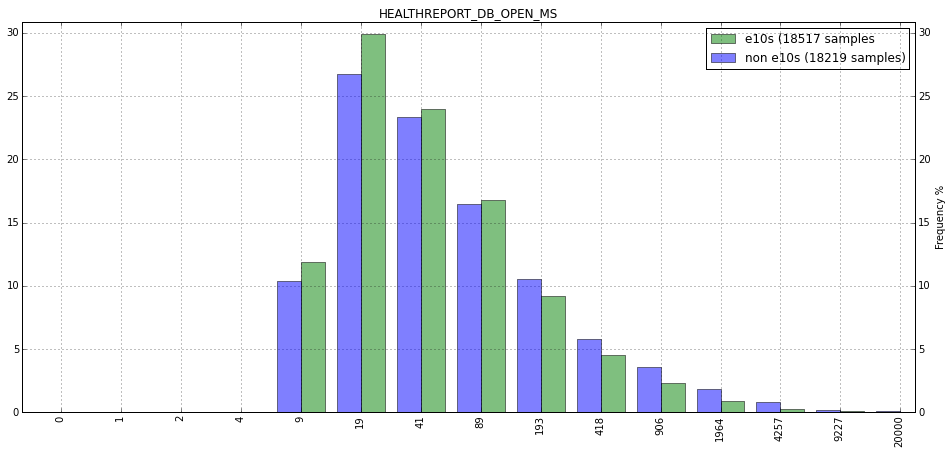

The chi2 distance for SIMPLE_MEASURES_STARTUPSESSIONRESTOREWRITEBYTES is 0.00762561684057


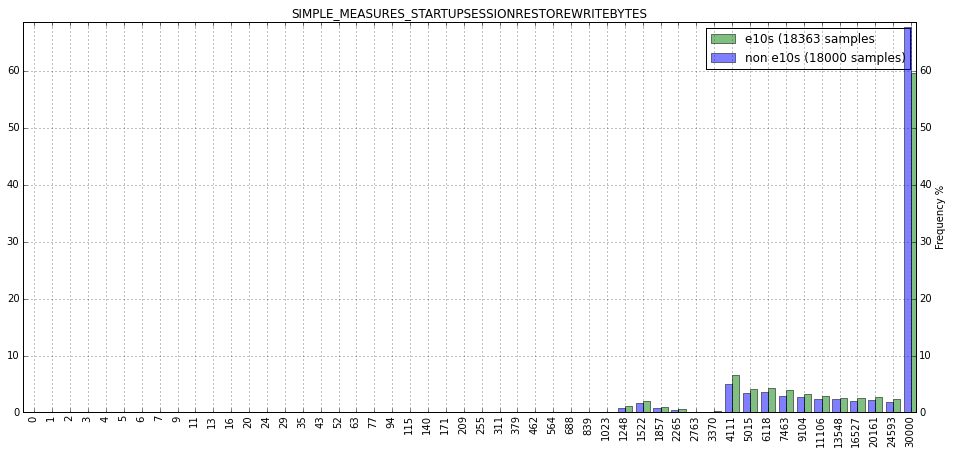

The chi2 distance for IMAGE_DECODE_SPEED_GIF is 0.00760926831071


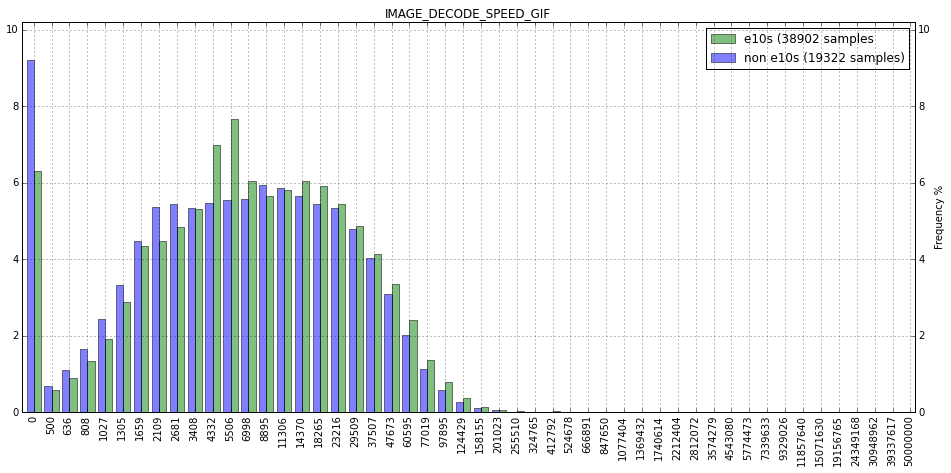

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_SUCCEEDED_TIME is 0.00739222977217


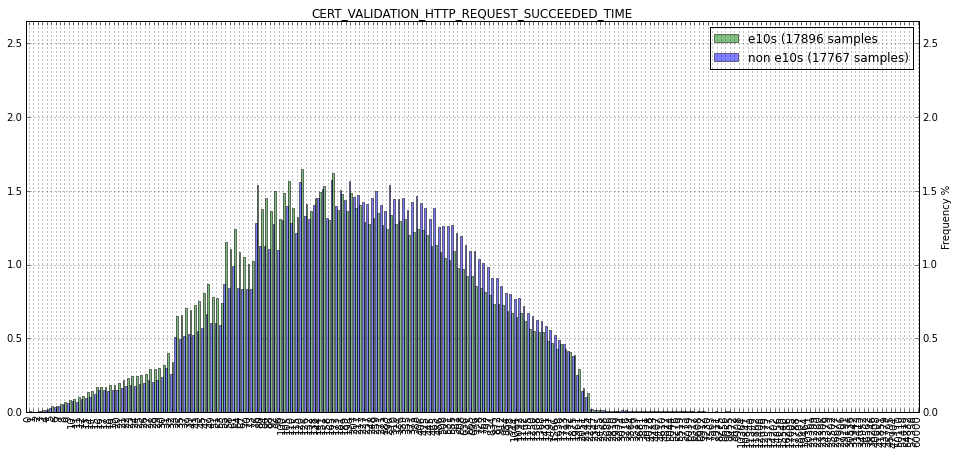

The chi2 distance for TELEMETRY_COMPRESS is 0.00726293281518


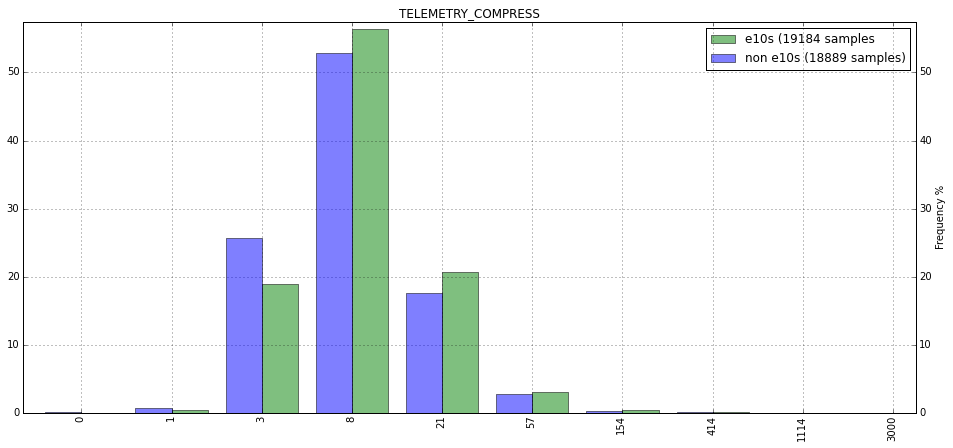

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS is 0.00720790660617


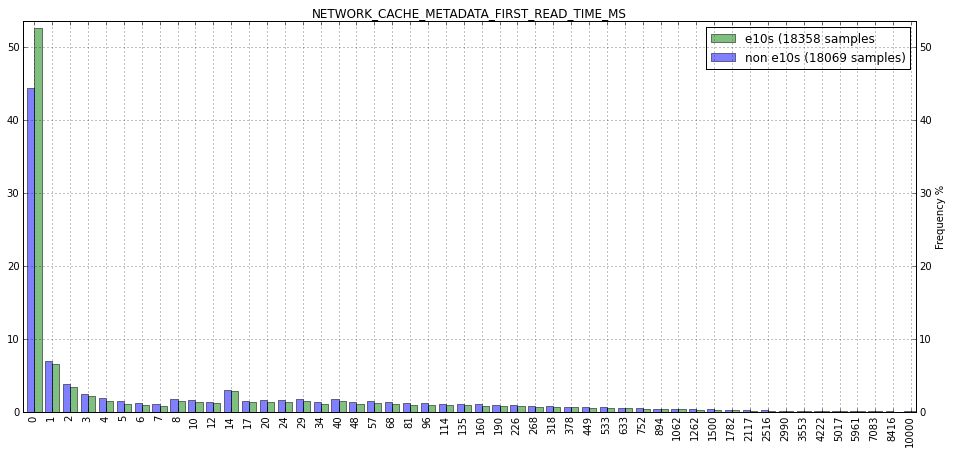

The chi2 distance for FX_SESSION_RESTORE_FILE_SIZE_BYTES is 0.00712859555892


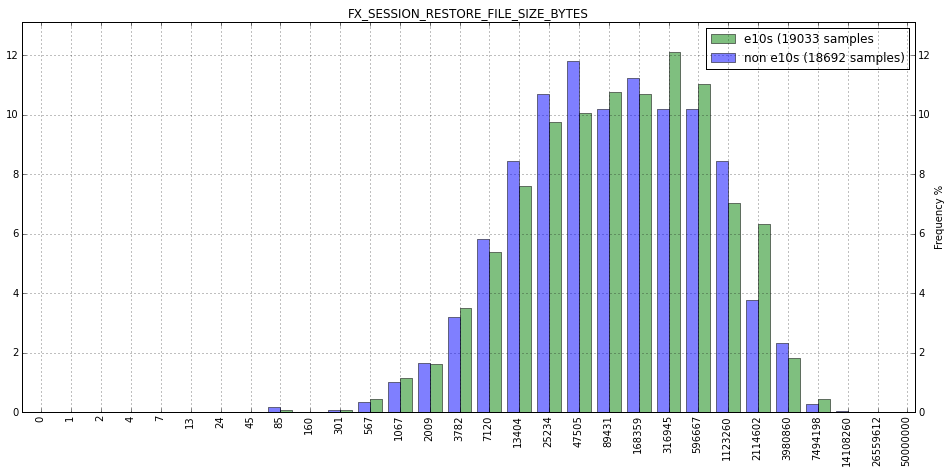

The chi2 distance for HEALTHREPORT_POST_COLLECT_CHECKPOINT_MS is 0.00705869827122


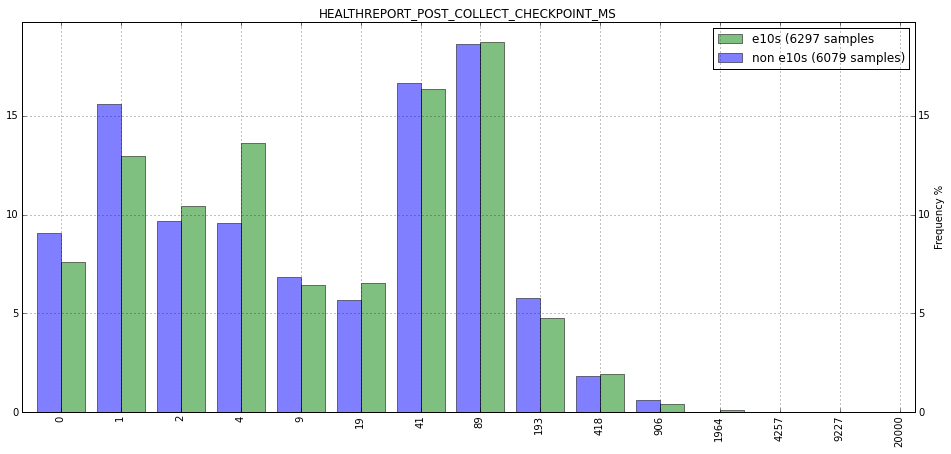

The chi2 distance for MEMORY_STORAGE_SQLITE is 0.00694278475712


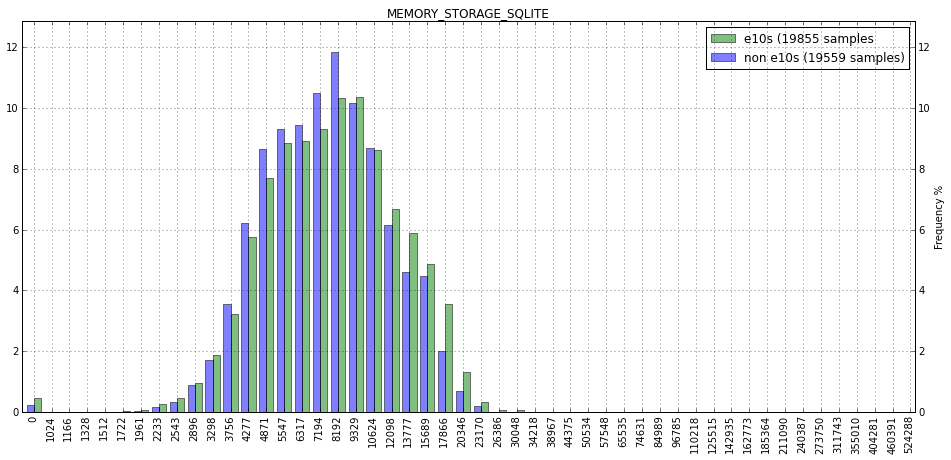

The chi2 distance for STS_POLL_AND_EVENT_THE_LAST_CYCLE is 0.00661600198751


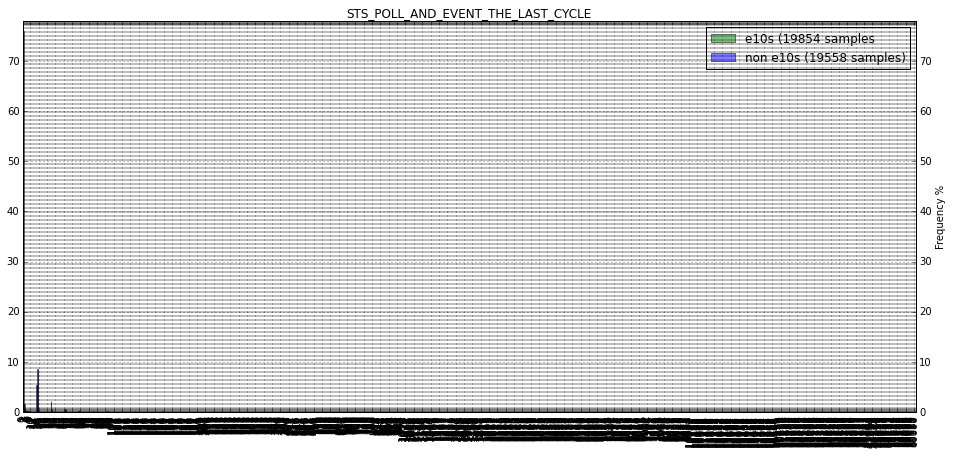

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_MS is 0.00658353924909


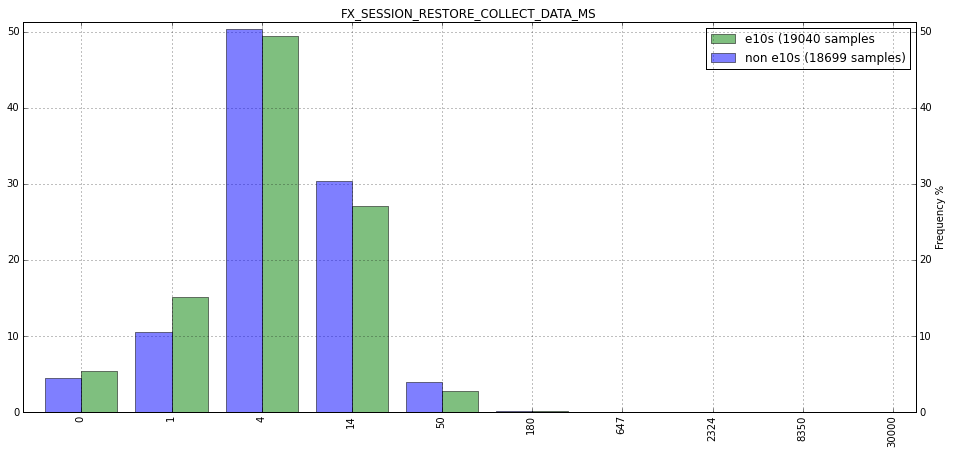

The chi2 distance for VIDEO_DECODED_H264_SPS_LEVEL is 0.00656777151846


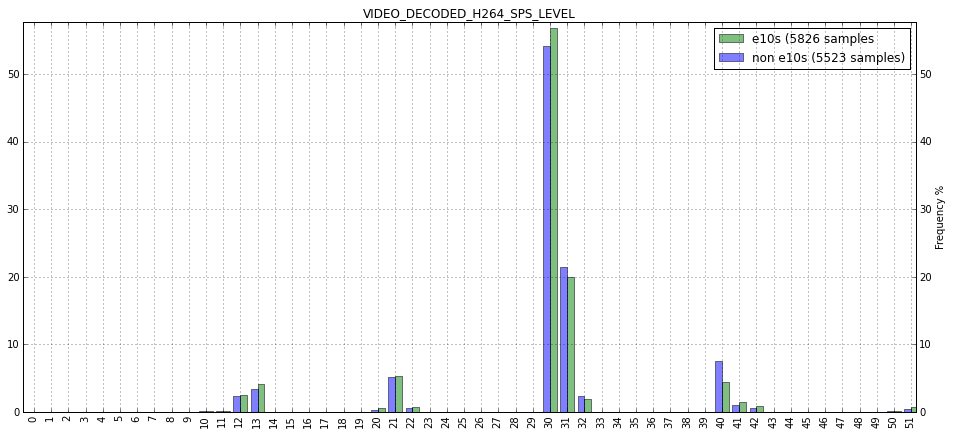

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_LONGEST_OP_MS is 0.00654751817479


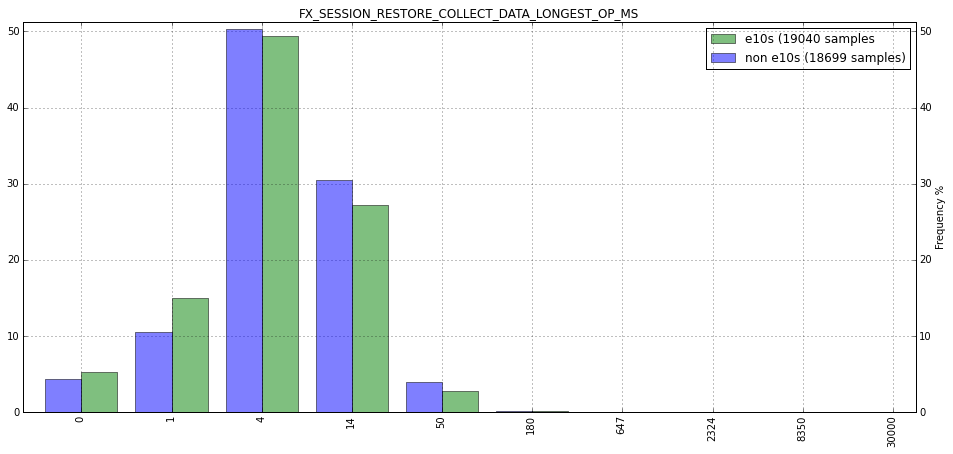

The chi2 distance for FLASH_PLUGIN_STATES is 0.0064604473937


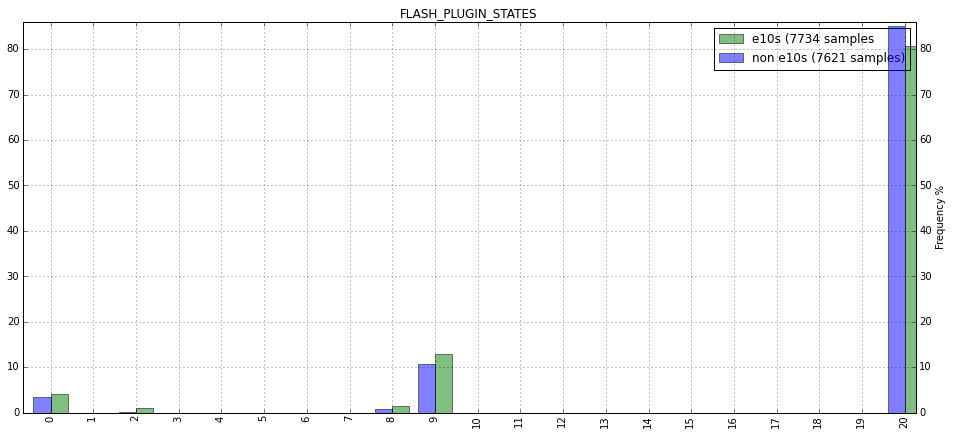

The chi2 distance for HTTP_PAGE_TCP_CONNECTION is 0.00628713941128


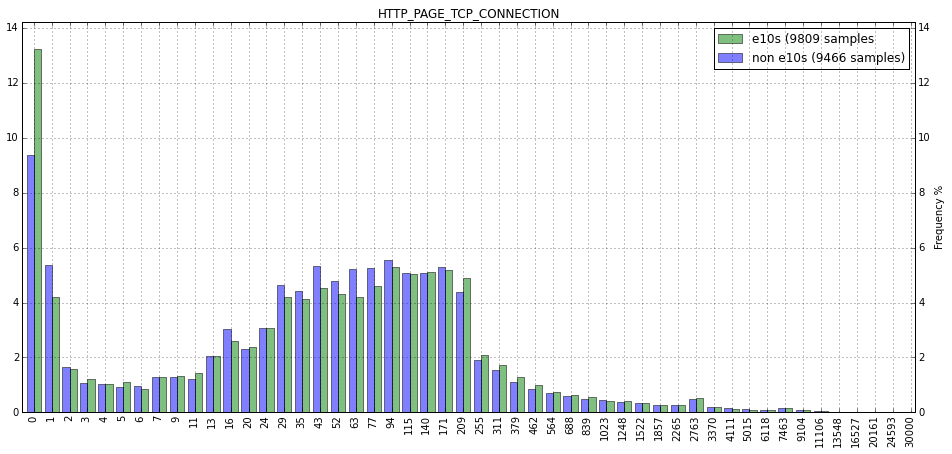

The chi2 distance for NETWORK_CACHE_V2_HIT_TIME_MS is 0.00598871593847


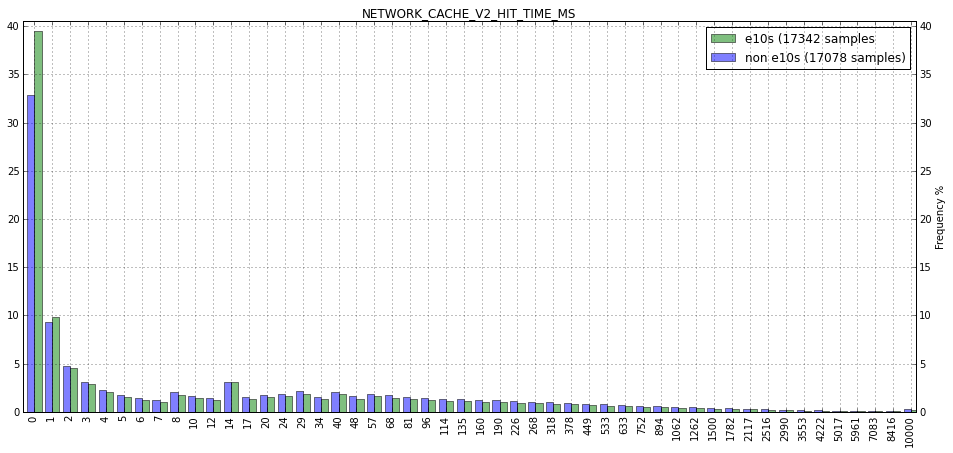

The chi2 distance for URLCLASSIFIER_LOOKUP_TIME is 0.00575266268344


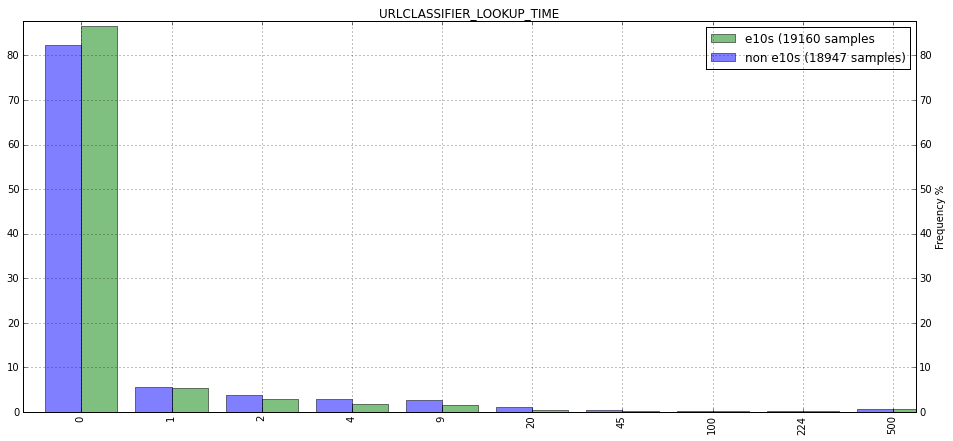

The chi2 distance for STS_POLL_AND_EVENTS_CYCLE is 0.00574035381521


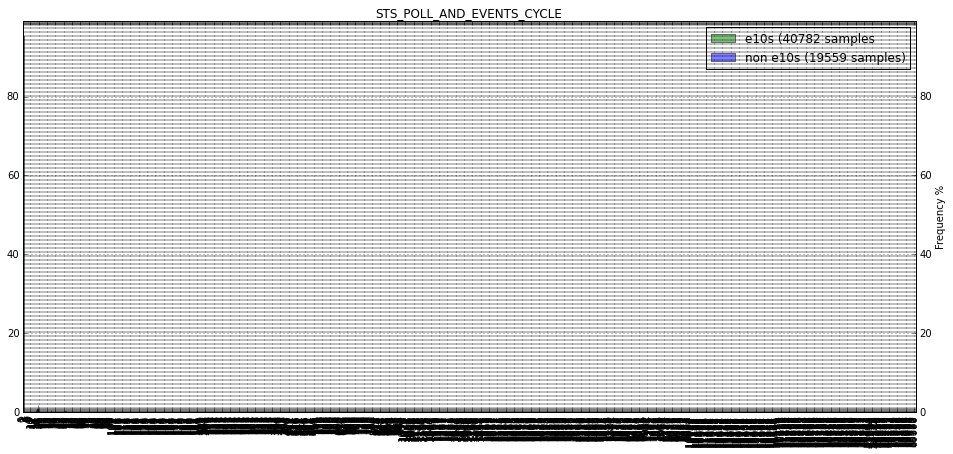

The chi2 distance for HTTP_CACHE_MISS_HALFLIFE_EXPERIMENT_2 is 0.00573125680244


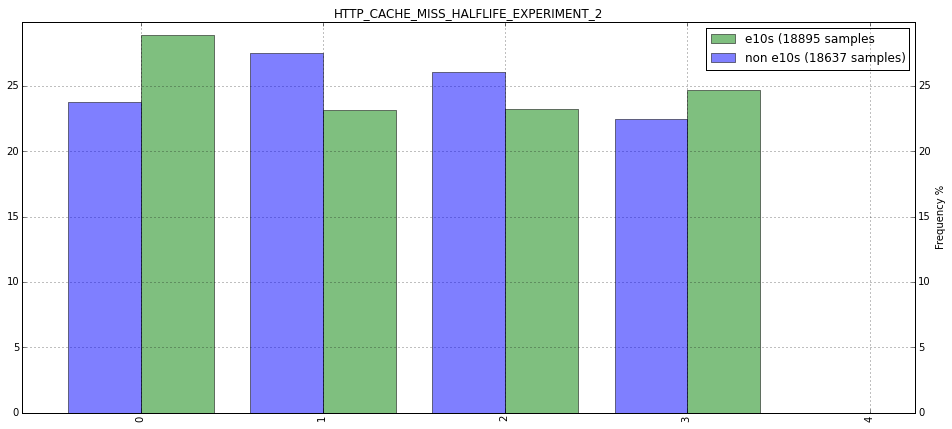

The chi2 distance for [[COUNT]]_PLUGIN_ACTIVATION_COUNT is 0.00546989423463


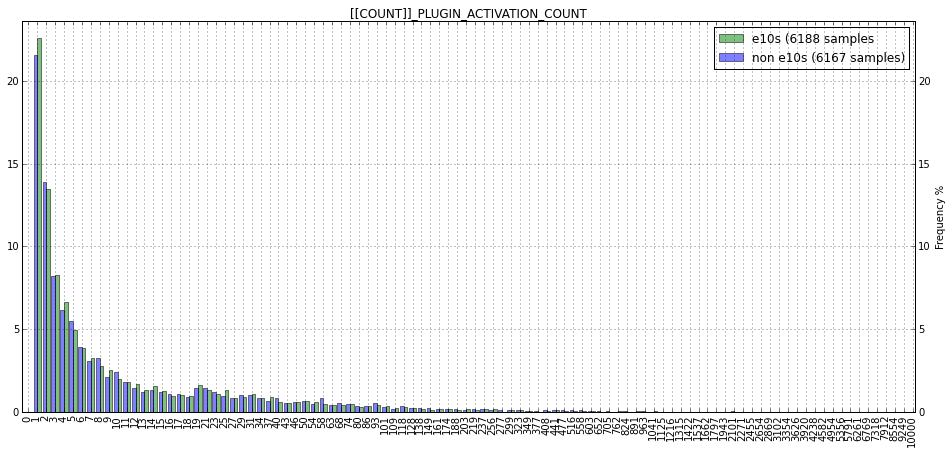

The chi2 distance for FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS is 0.00538809555217


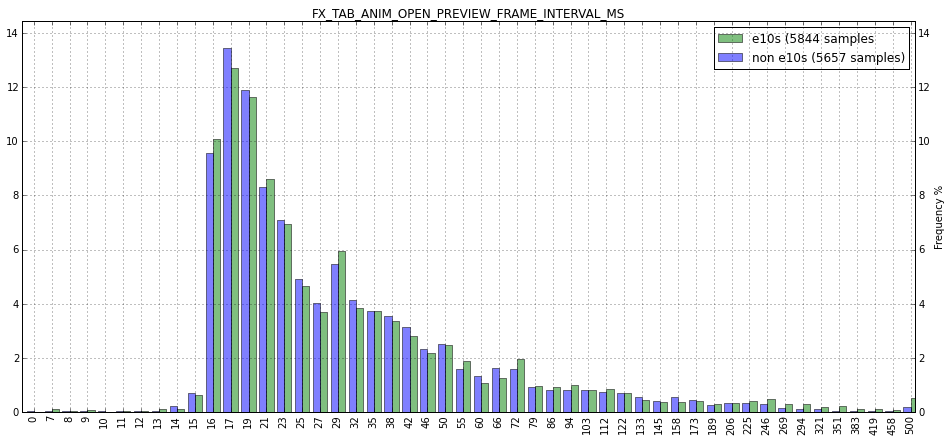

The chi2 distance for COMPOSITE_TIME is 0.00529801981566


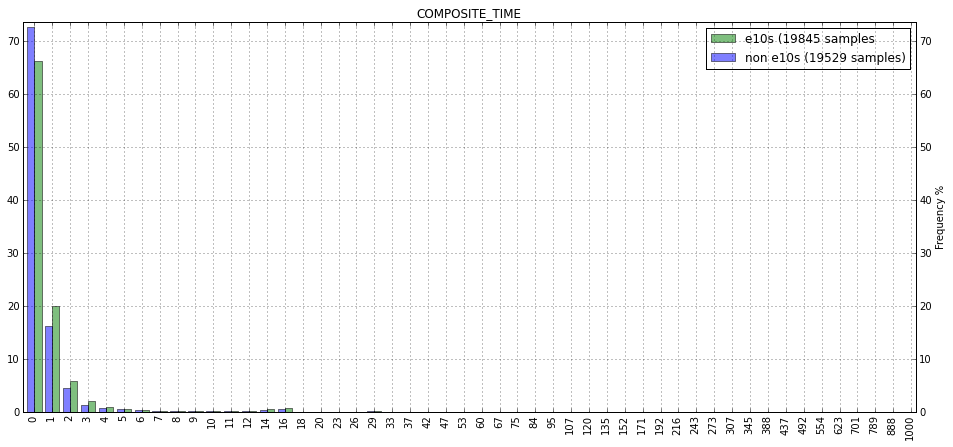

The chi2 distance for MOZ_SQLITE_OPEN_MS is 0.00523906170355


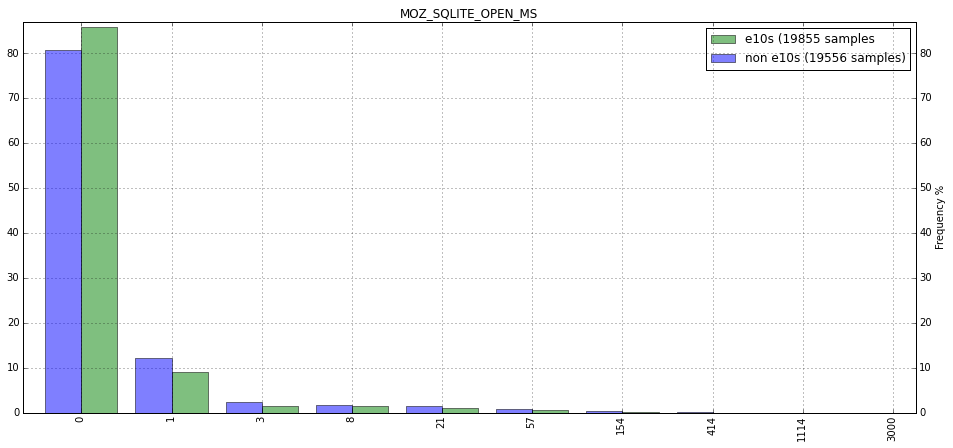

The chi2 distance for HTTP_SUB_TCP_CONNECTION is 0.00496989542894


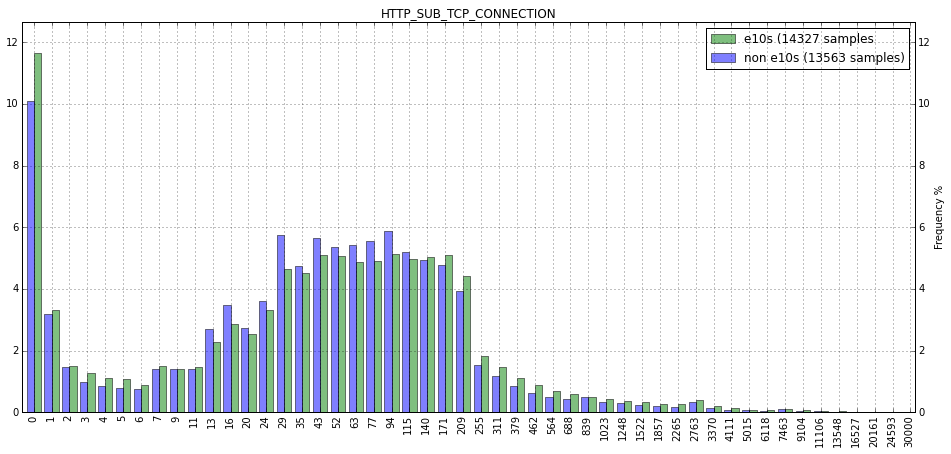

The chi2 distance for NETWORK_CACHE_METADATA_SIZE is 0.00492426864372


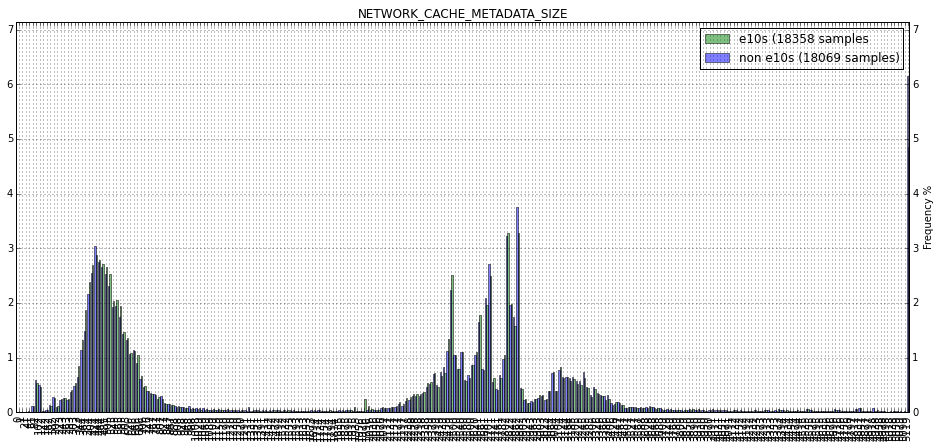

The chi2 distance for STARTUP_DNS_LOOKUP_TIME is 0.00464043813781


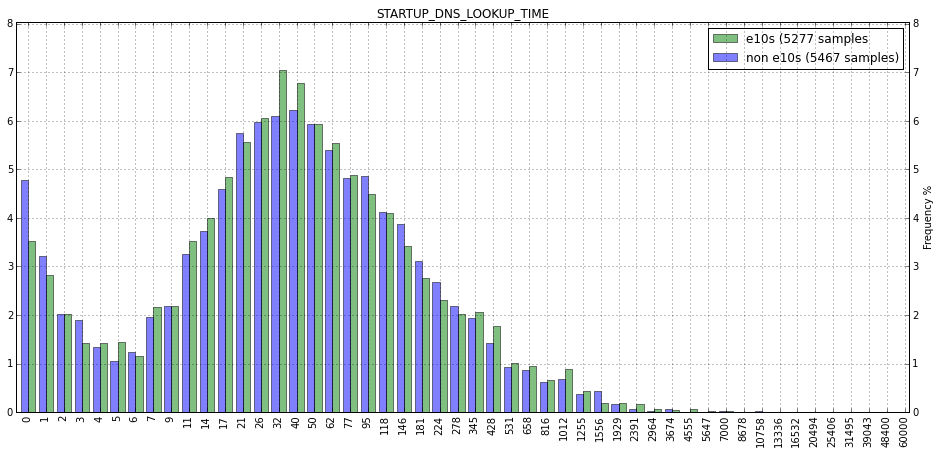

The chi2 distance for CERT_CHAIN_KEY_SIZE_STATUS is 0.00450073774565


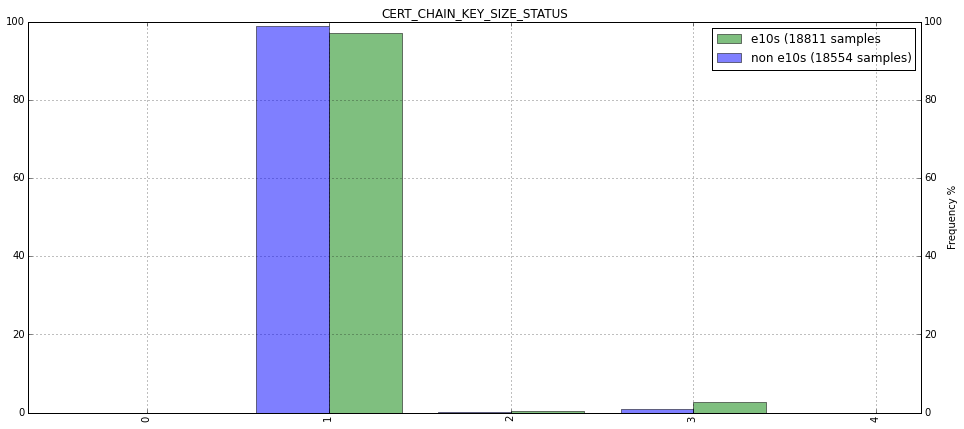

The chi2 distance for HTTP_KBREAD_PER_CONN is 0.00435499757765


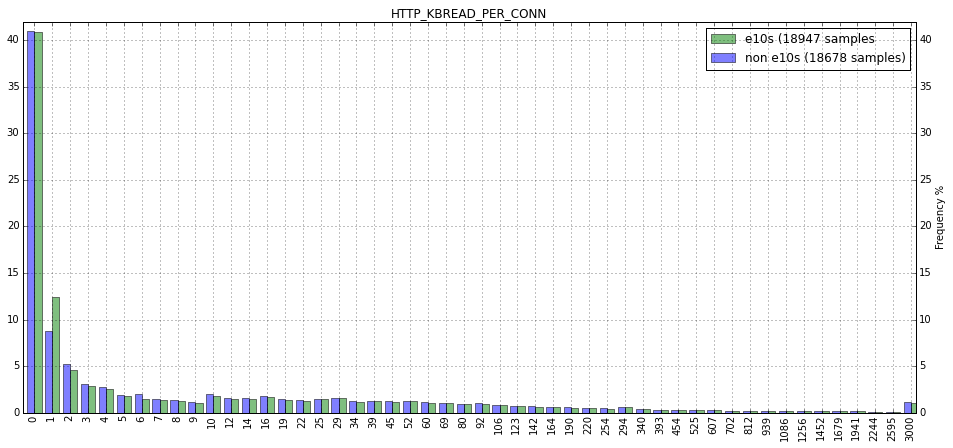

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS_IN_THE_LAST_CYCLE is 0.00433472718325


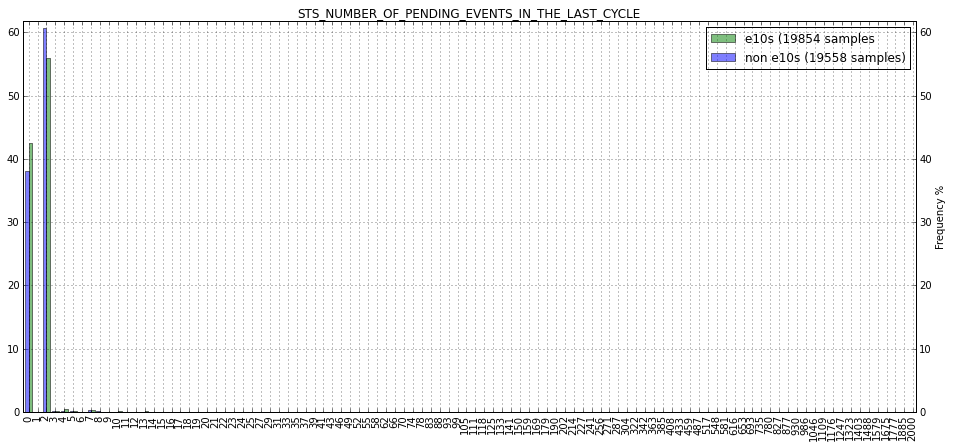

The chi2 distance for PWMGR_NUM_HTTPAUTH_PASSWORDS is 0.00411598706295


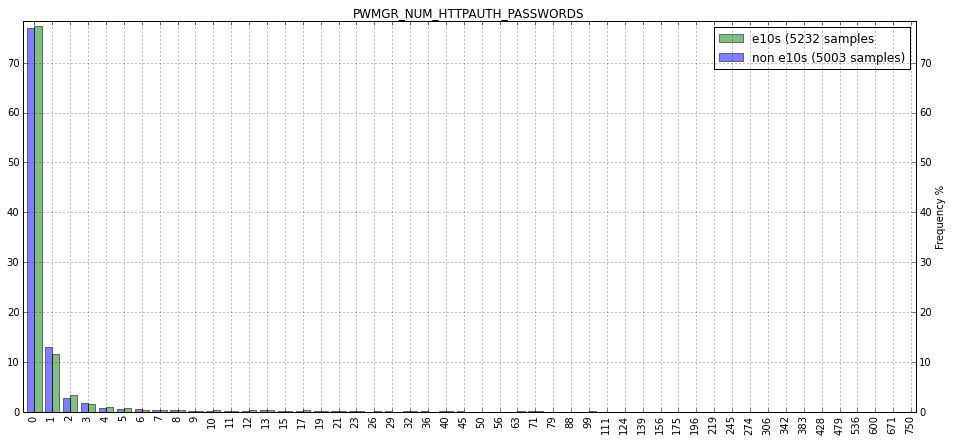

The chi2 distance for CERT_CHAIN_SIGNATURE_DIGEST_STATUS is 0.00407192756475


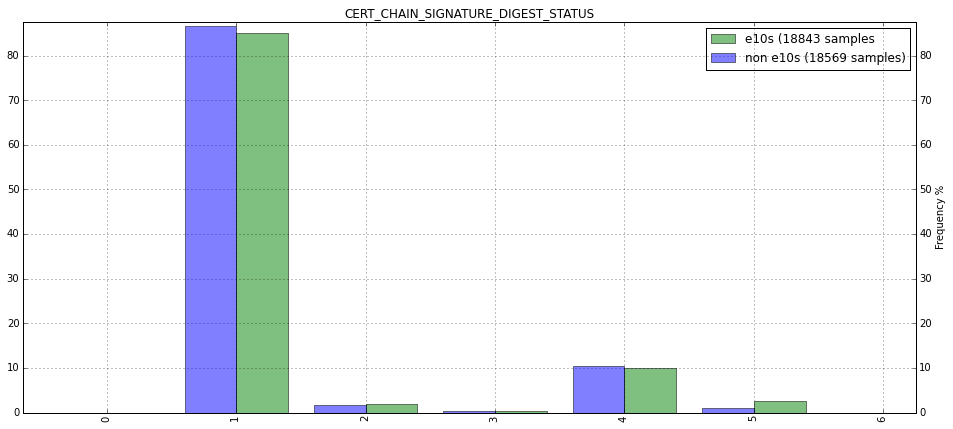

The chi2 distance for GC_NON_INCREMENTAL is 0.00405743634809


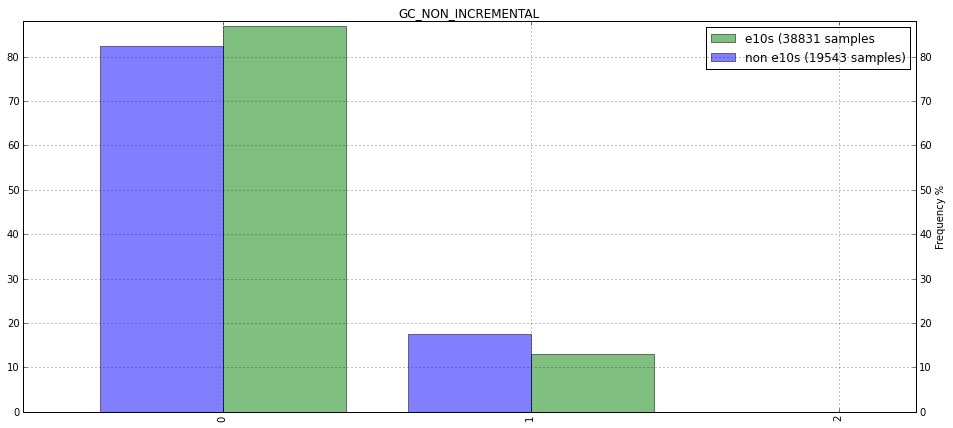

The chi2 distance for PWMGR_NUM_SAVED_PASSWORDS is 0.0039057469681


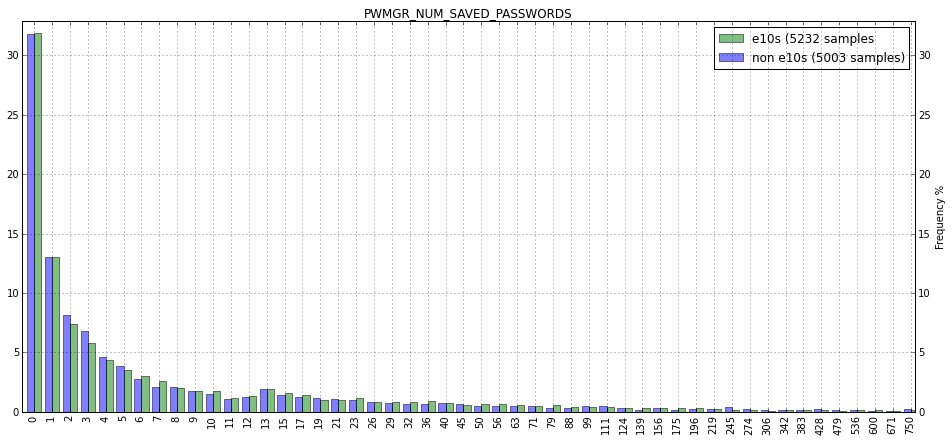

The chi2 distance for STARTUP_MOZ_SQLITE_COOKIES_OPEN_READAHEAD_MS is 0.00371760569336


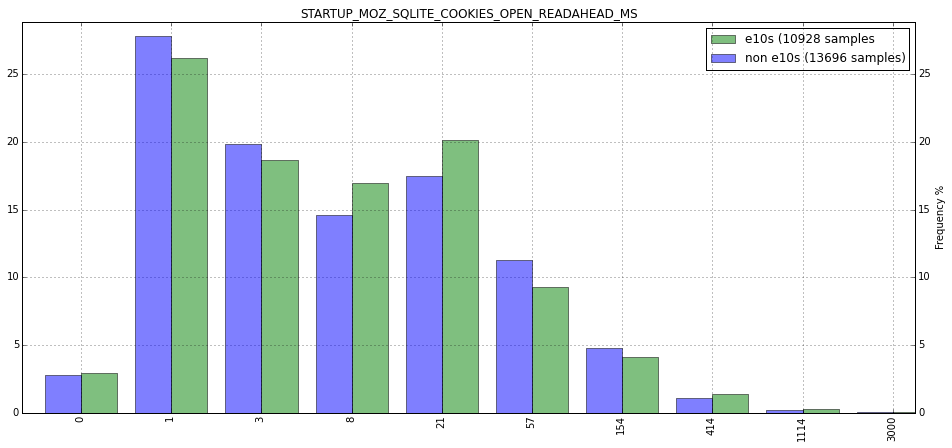

The chi2 distance for GHOST_WINDOWS is 0.0036900650791


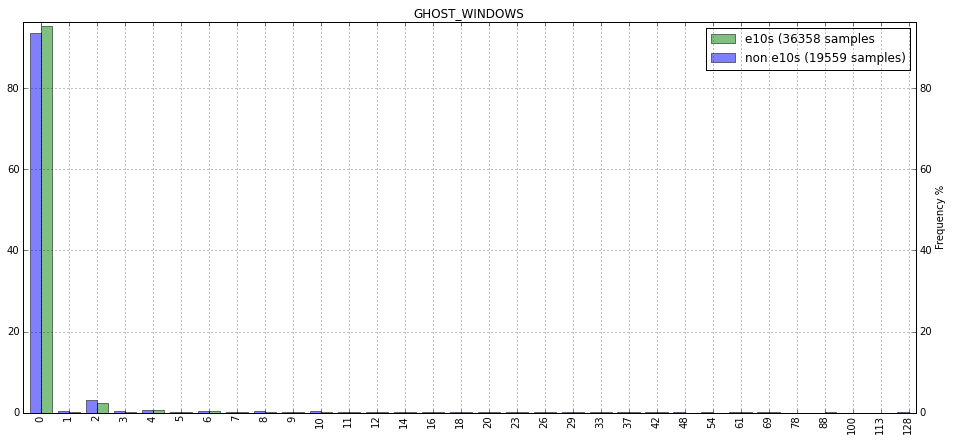

The chi2 distance for [[COUNT]]_TOP_LEVEL_CONTENT_DOCUMENTS_DESTROYED is 0.00357891255377


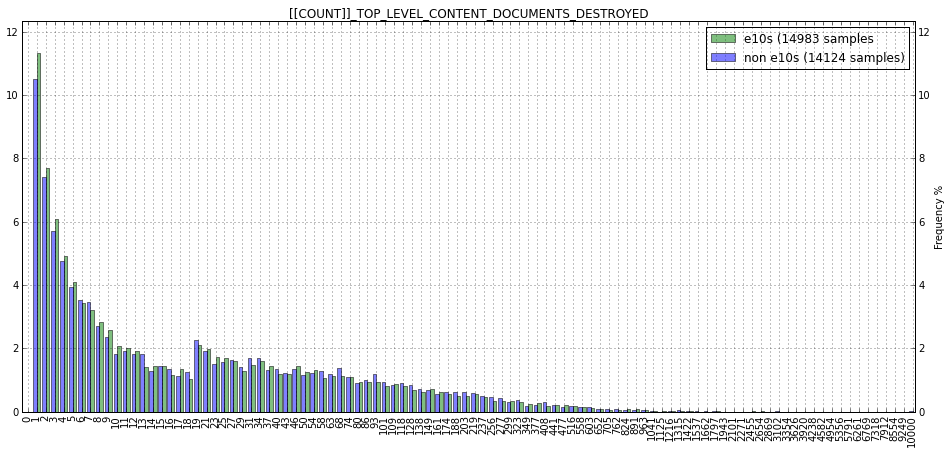

The chi2 distance for NETWORK_CACHE_METADATA_SECOND_READ_TIME_MS is 0.00353497528386


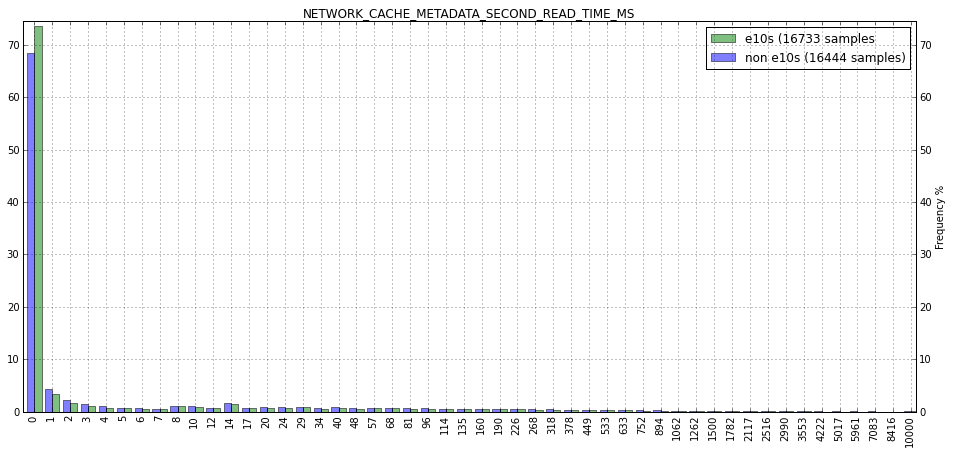

The chi2 distance for PWMGR_FORM_AUTOFILL_RESULT is 0.00349141944842


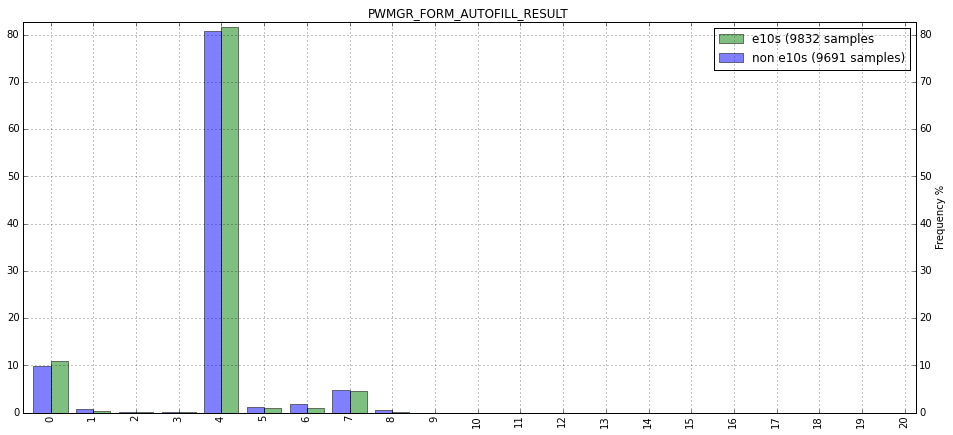

The chi2 distance for HTTP_PAGELOAD_IS_SSL is 0.00344616428482


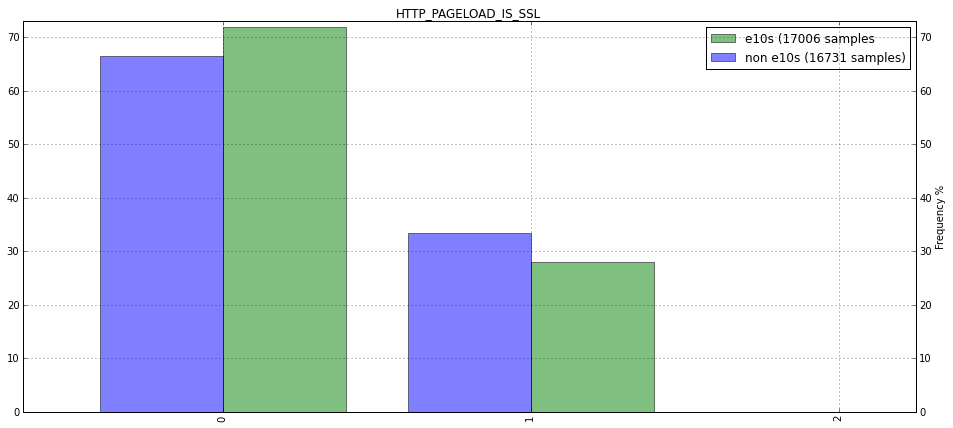

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COLLECT is 0.00339483298818


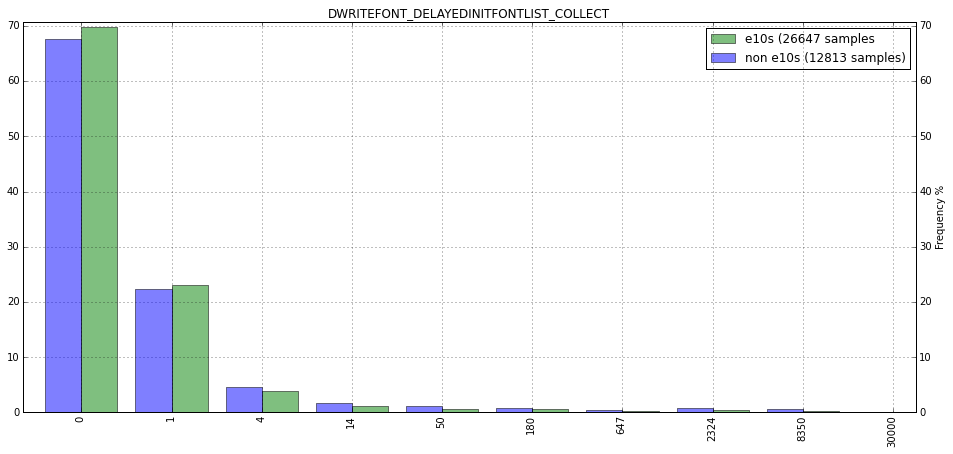

The chi2 distance for PWMGR_LOGIN_PAGE_SAFETY is 0.00311767445461


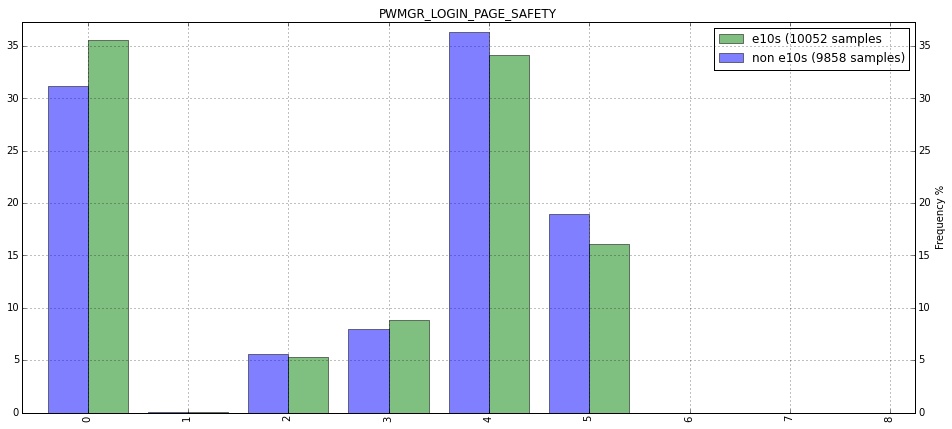

The chi2 distance for FX_SESSION_RESTORE_COLLECT_ALL_WINDOWS_DATA_MS is 0.00311510846976


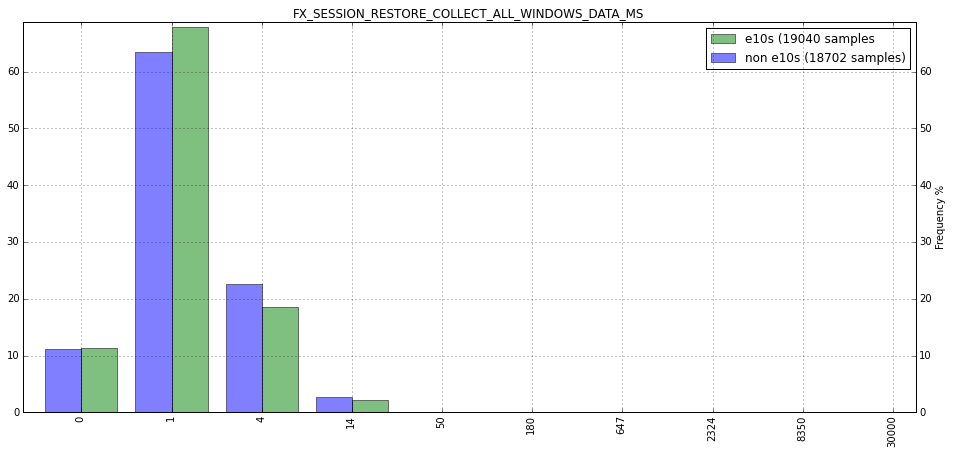

The chi2 distance for PREDICTOR_WAIT_TIME is 0.0029447223294


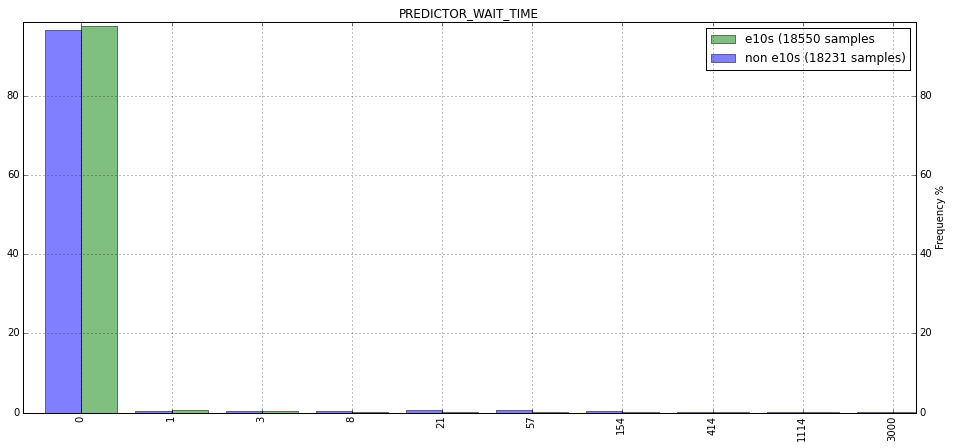

The chi2 distance for FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS is 0.00289558940742


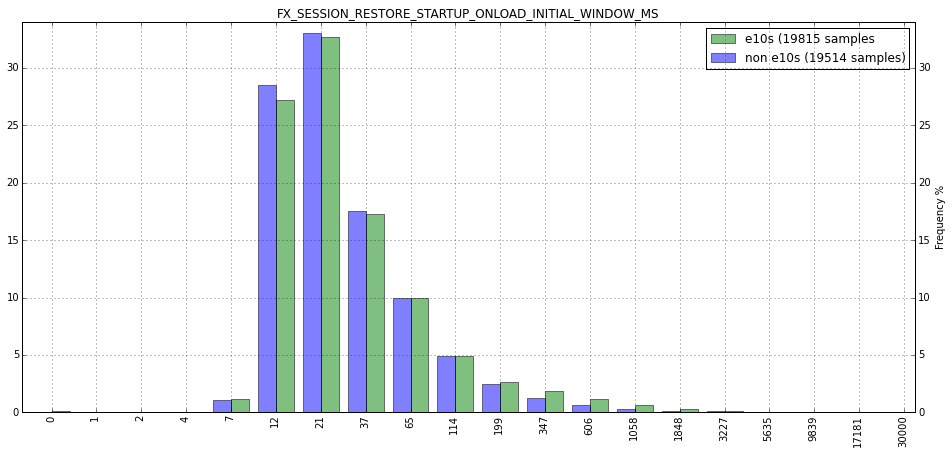

The chi2 distance for BLOCKED_ON_PLUGIN_STREAM_INIT_MS is 0.00289269705226


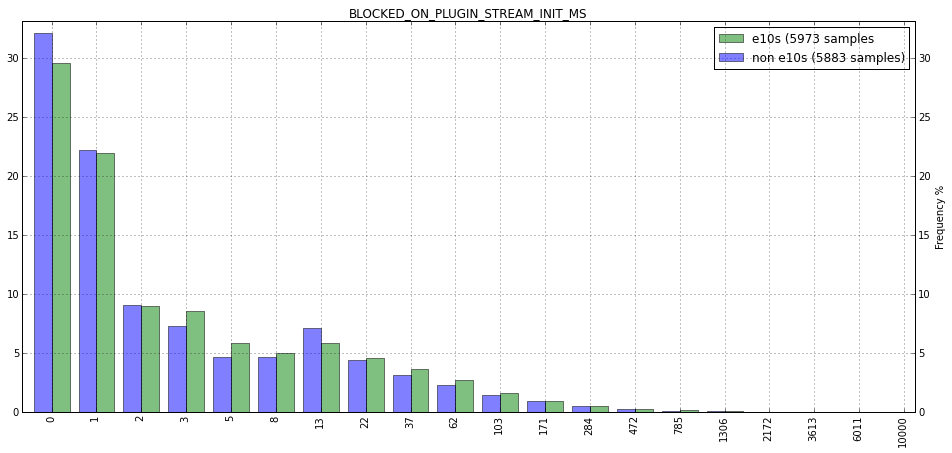

The chi2 distance for SSL_TIME_UNTIL_READY is 0.00288514413883


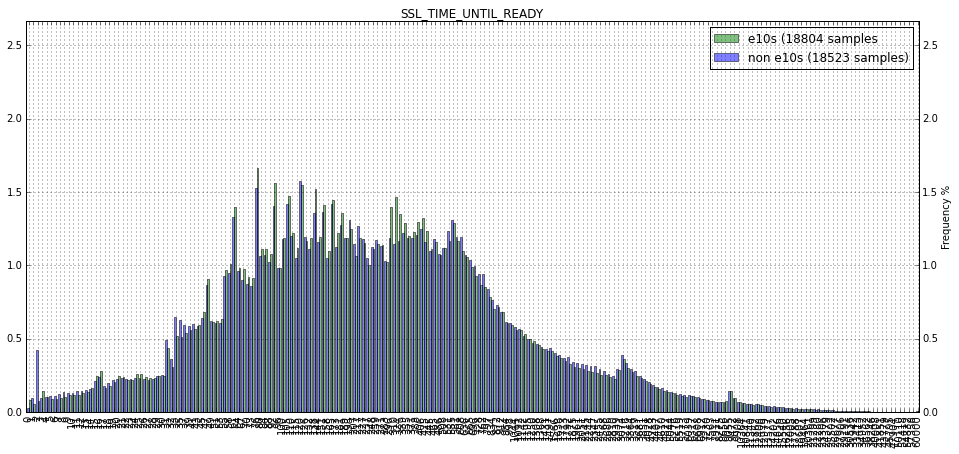

The chi2 distance for SSL_TIME_UNTIL_HANDSHAKE_FINISHED is 0.00281133863782


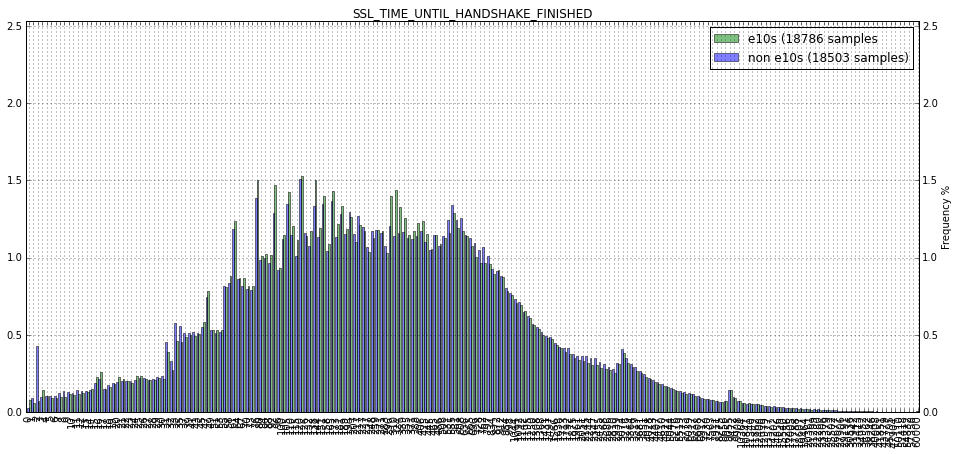

The chi2 distance for REFRESH_DRIVER_TICK is 0.00278743840326


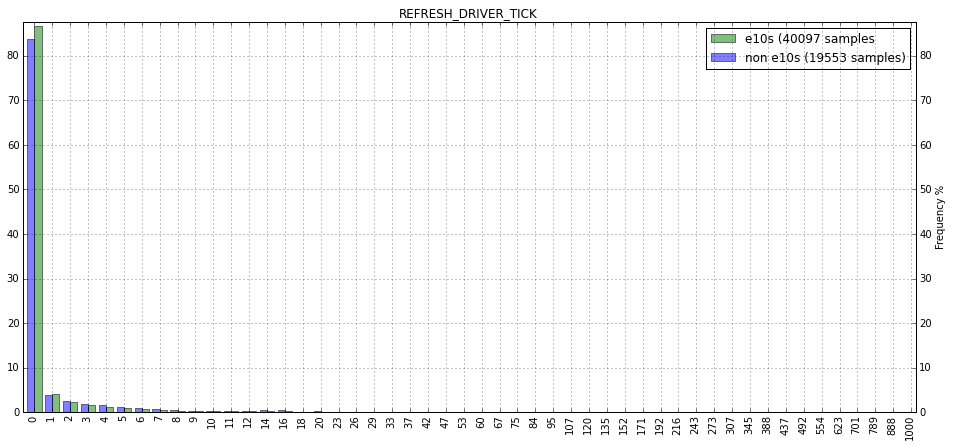

The chi2 distance for COMPONENTS_SHIM_ACCESSED_BY_CONTENT is 0.00278640518776


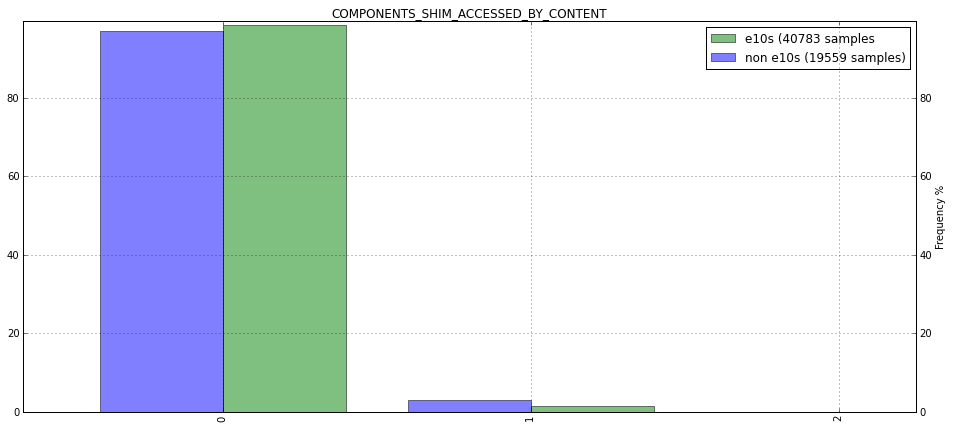

The chi2 distance for SSL_SUCCESFUL_CERT_VALIDATION_TIME_MOZILLAPKIX is 0.00276282806638


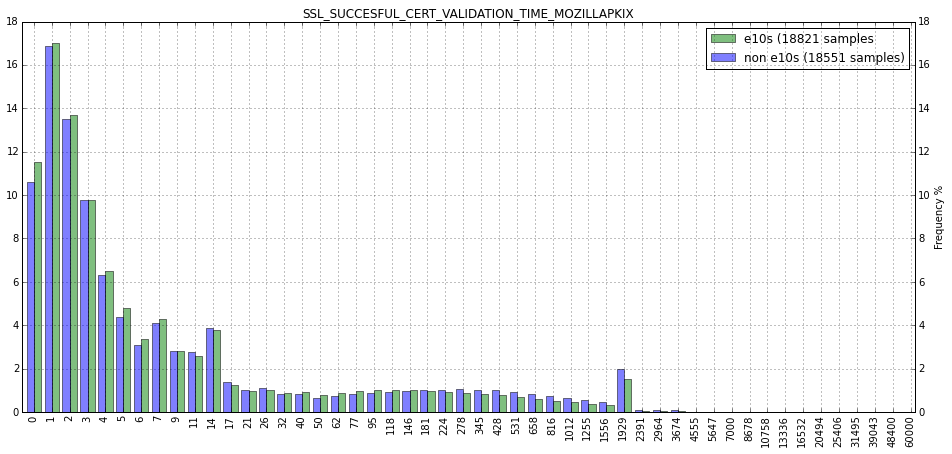

The chi2 distance for PLACES_ANNOS_PAGES_COUNT is 0.00270741220566


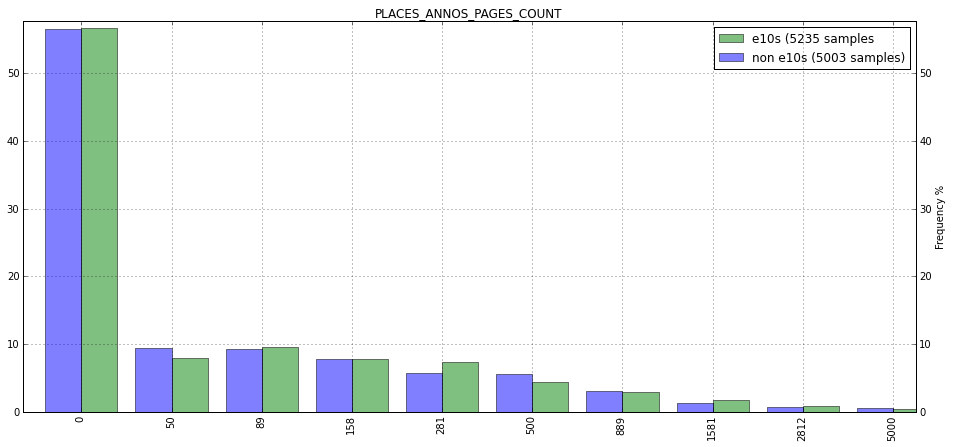

The chi2 distance for TRANSACTION_WAIT_TIME_HTTP is 0.00268290105409


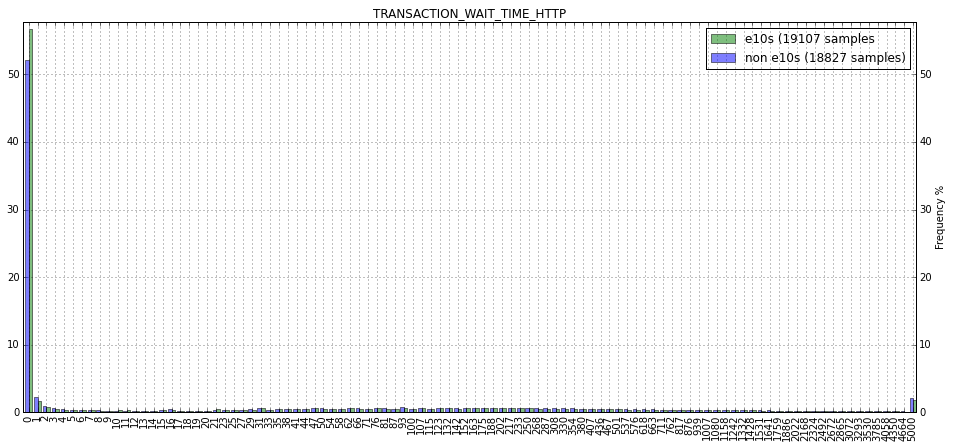

The chi2 distance for HEALTHREPORT_GENERATE_JSON_PAYLOAD_MS is 0.0025614695095


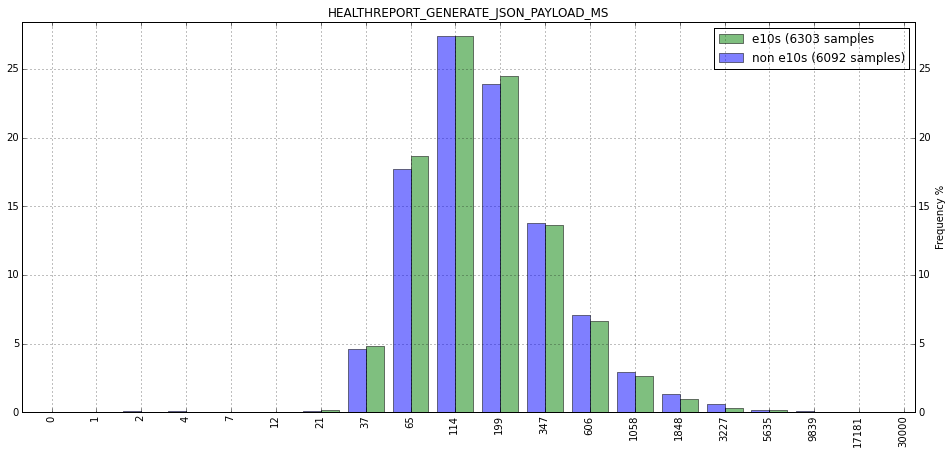

The chi2 distance for SIMPLE_MEASURES_ADDONMANAGER_XPIDB_SYNCREAD_MS is 0.00253013518639


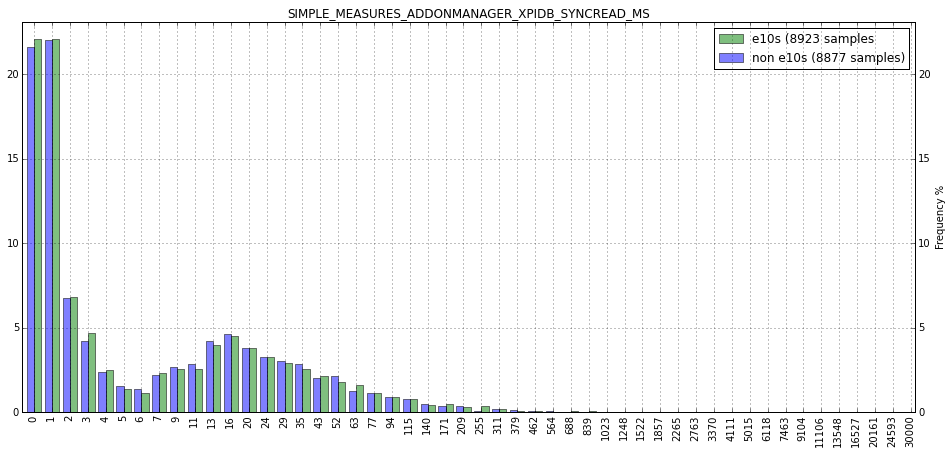

The chi2 distance for TELEMETRY_PENDING_CHECKING_OVER_QUOTA_MS is 0.00248190499722


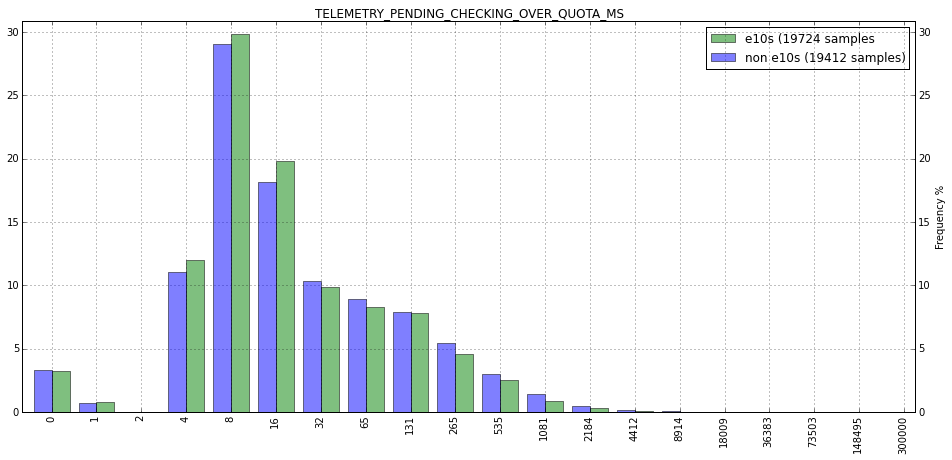

The chi2 distance for SSL_OBSERVED_END_ENTITY_CERTIFICATE_LIFETIME is 0.00242871812478


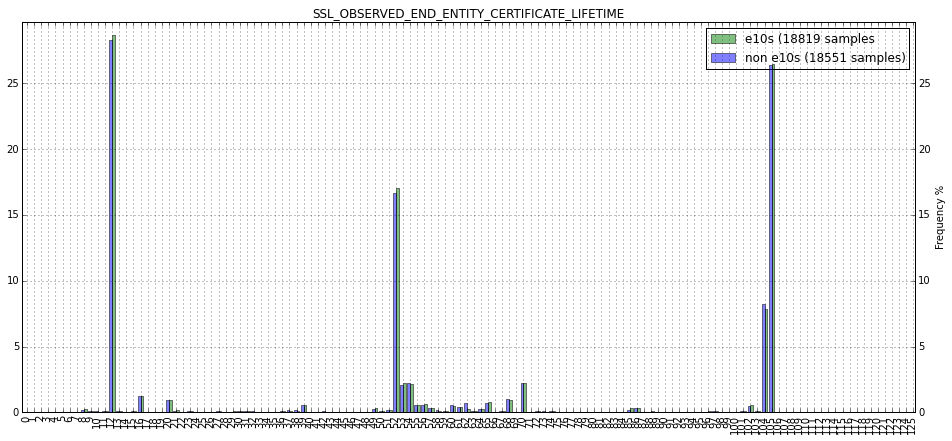

The chi2 distance for SYSTEM_FONT_FALLBACK_FIRST is 0.00237138070464


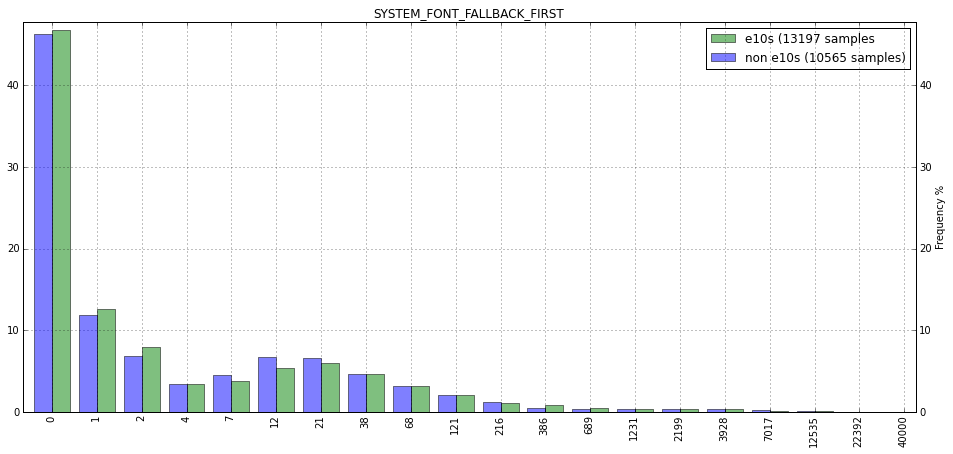

The chi2 distance for TELEMETRY_PENDING_PINGS_AGE is 0.00235447438071


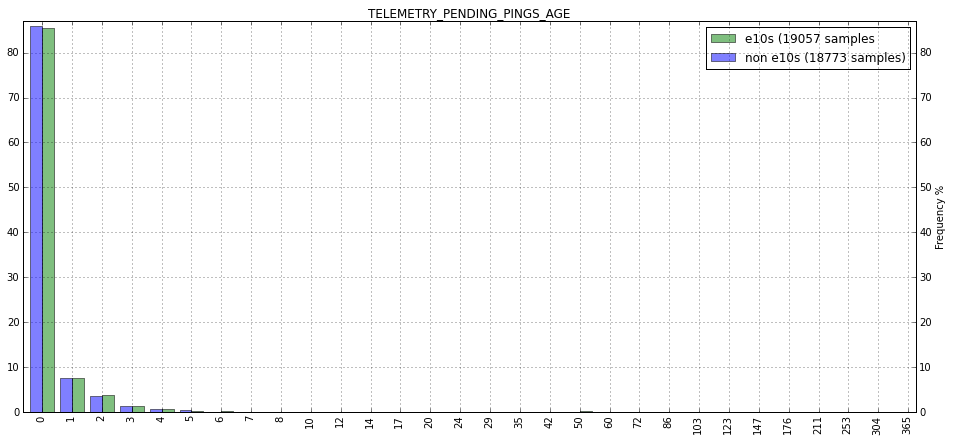

The chi2 distance for HTTP_CACHE_ENTRY_RELOAD_TIME is 0.00232392726794


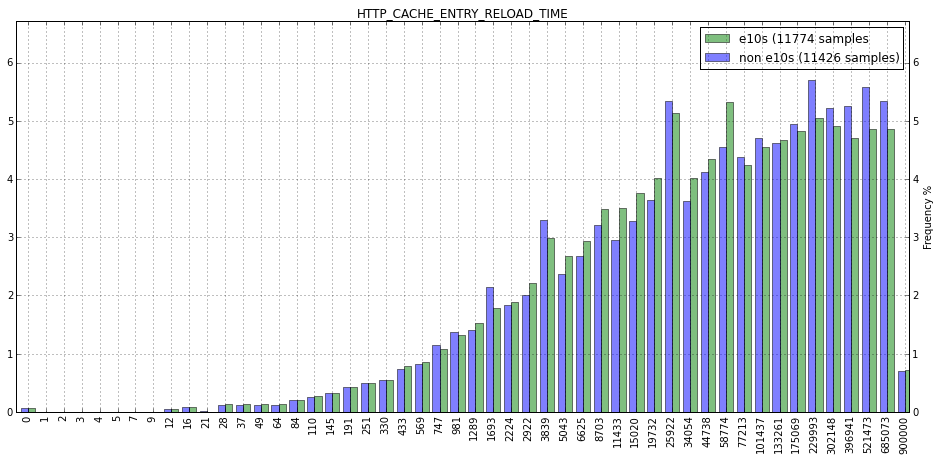

The chi2 distance for TELEMETRY_ARCHIVE_CHECKING_OVER_QUOTA_MS is 0.00231430347078


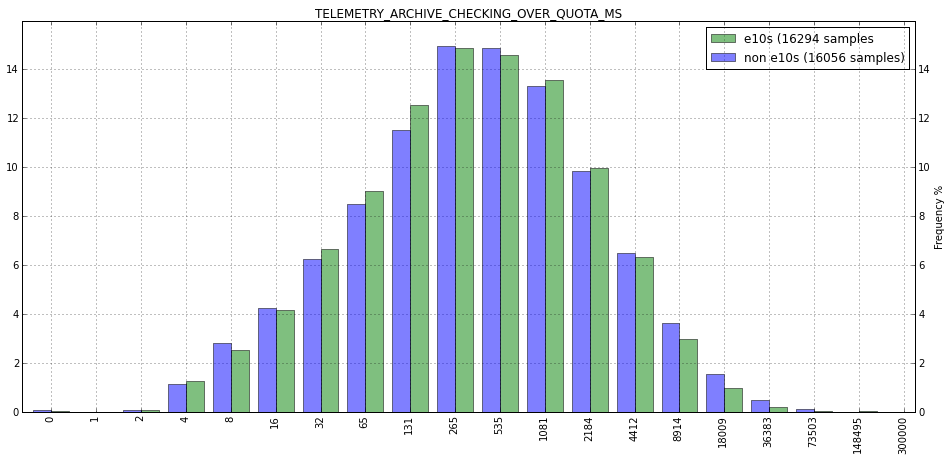

The chi2 distance for PREDICTOR_LEARN_WORK_TIME is 0.00228061715716


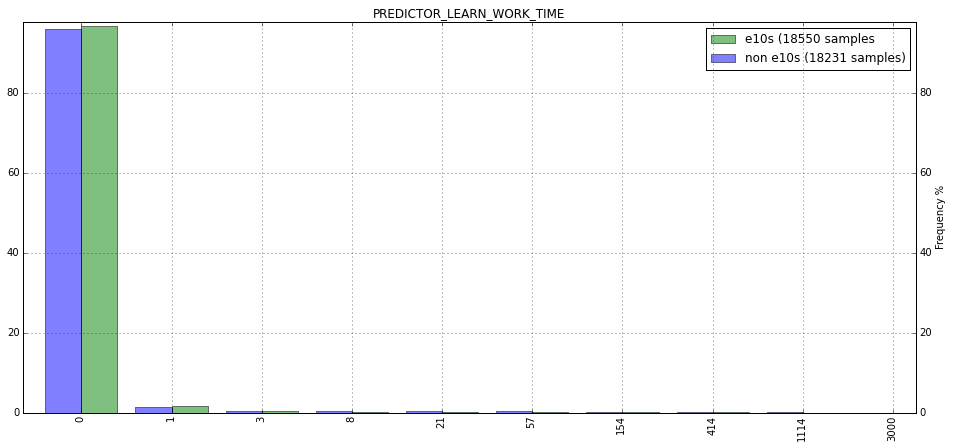

The chi2 distance for DEVTOOLS_TABS_OPEN_AVERAGE_LINEAR is 0.00223774383675


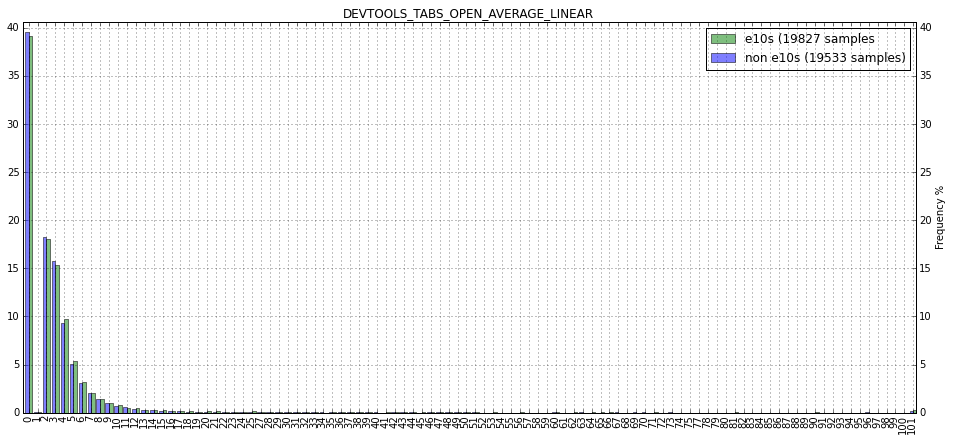

The chi2 distance for PREDICTOR_TOTAL_PREDICTIONS is 0.00222529567555


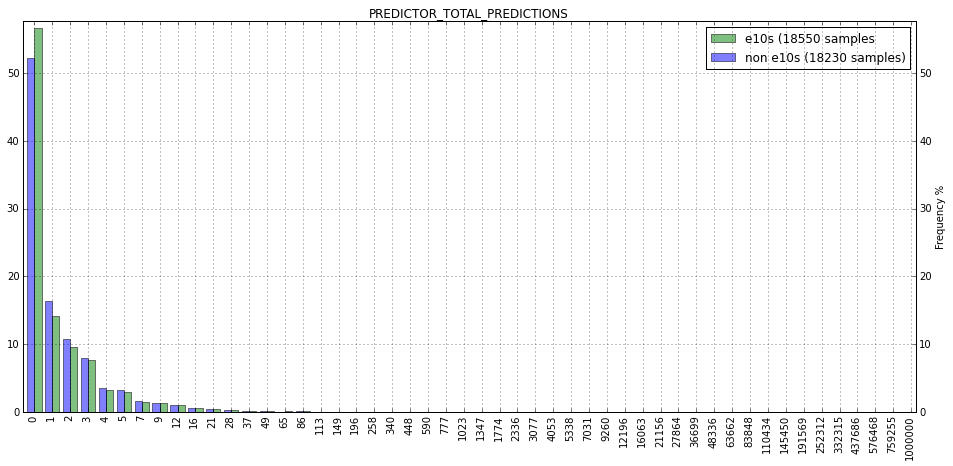

The chi2 distance for HTTP_CACHE_DISPOSITION_2_V2 is 0.00219368105742


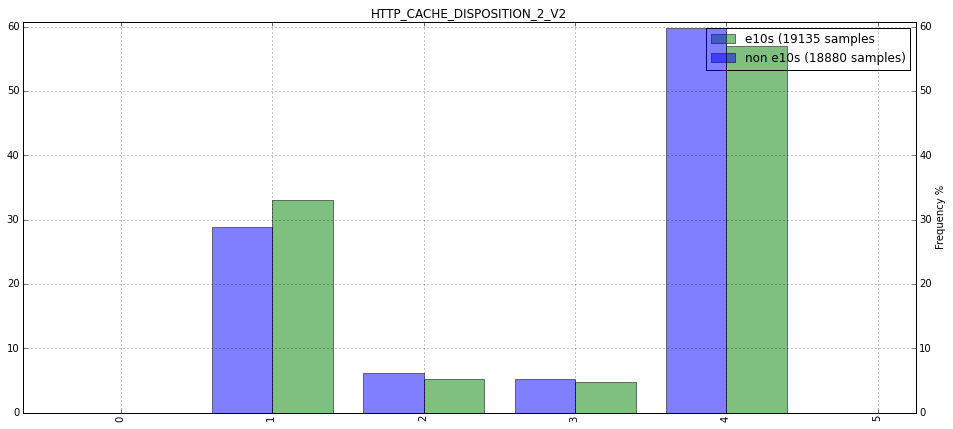

The chi2 distance for LOCALDOMSTORAGE_PRELOAD_PENDING_ON_FIRST_ACCESS is 0.0021477879362


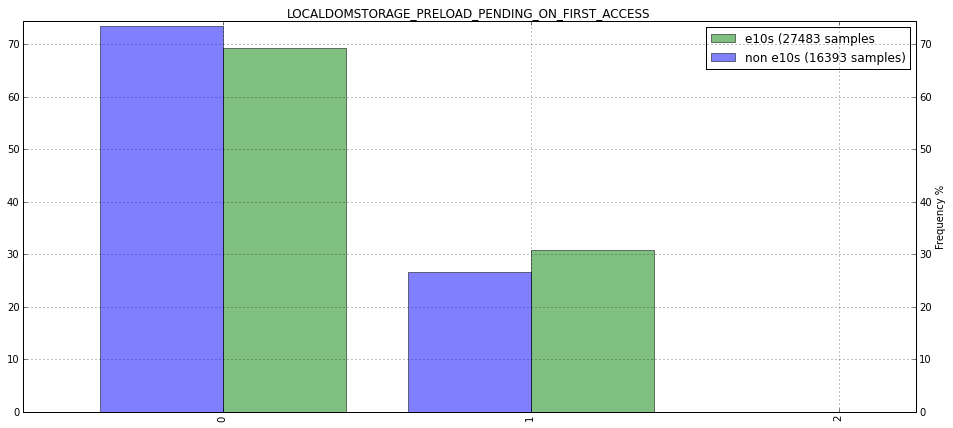

The chi2 distance for IMAGE_DECODE_COUNT is 0.0021441766205


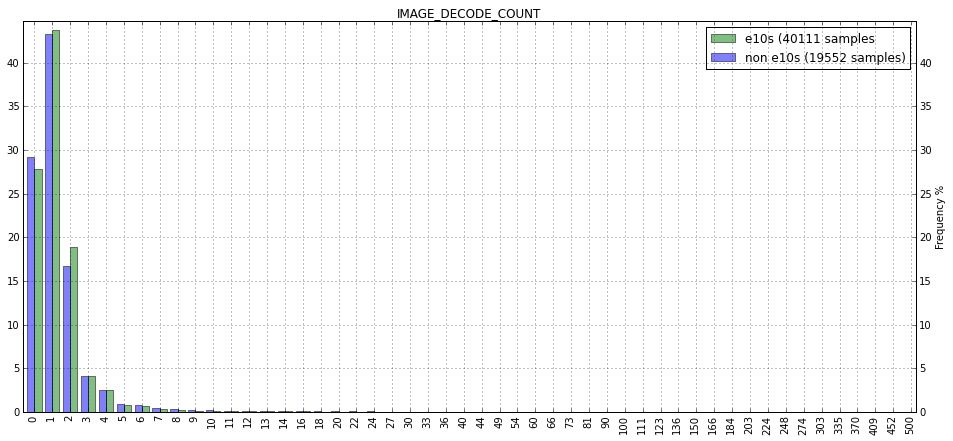

The chi2 distance for NEWTAB_PAGE_BLOCKED_SITES_COUNT is 0.00213646101486


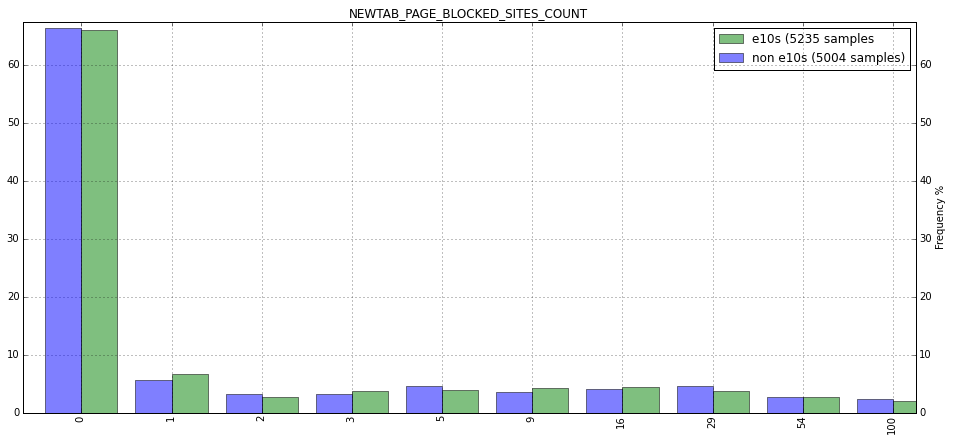

The chi2 distance for DEVTOOLS_TABS_OPEN_PEAK_LINEAR is 0.00211216698213


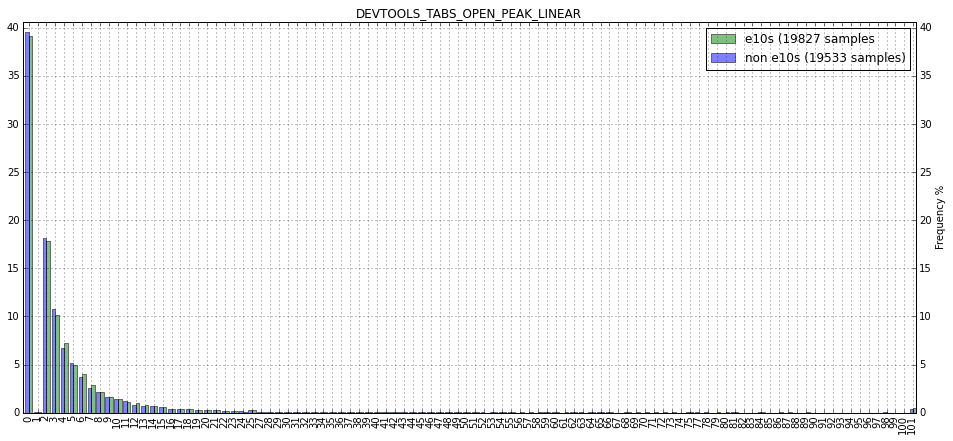

The chi2 distance for IMAGE_DECODE_SPEED_PNG is 0.00196128348911


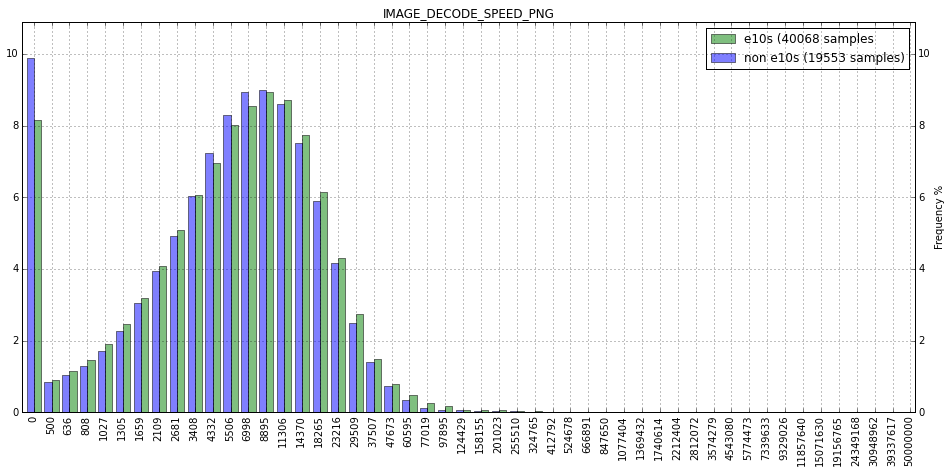

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_RESULT is 0.00193269299659


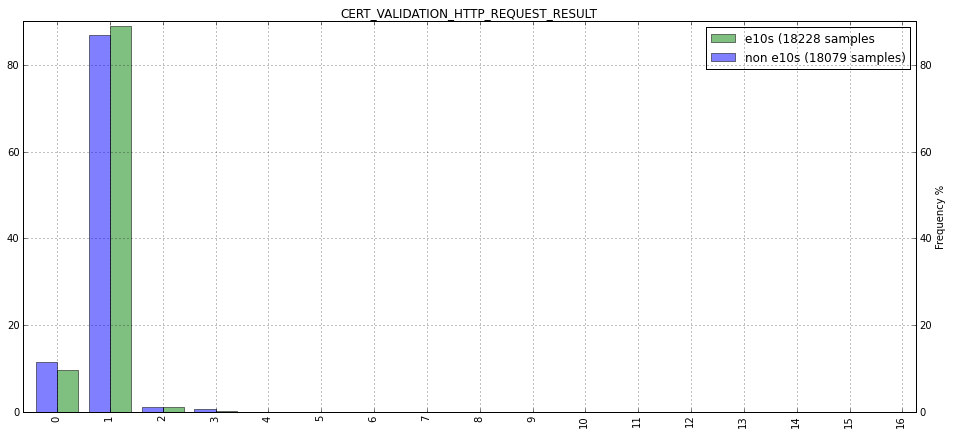

The chi2 distance for NEWTAB_PAGE_PINNED_SITES_COUNT is 0.00192802350937


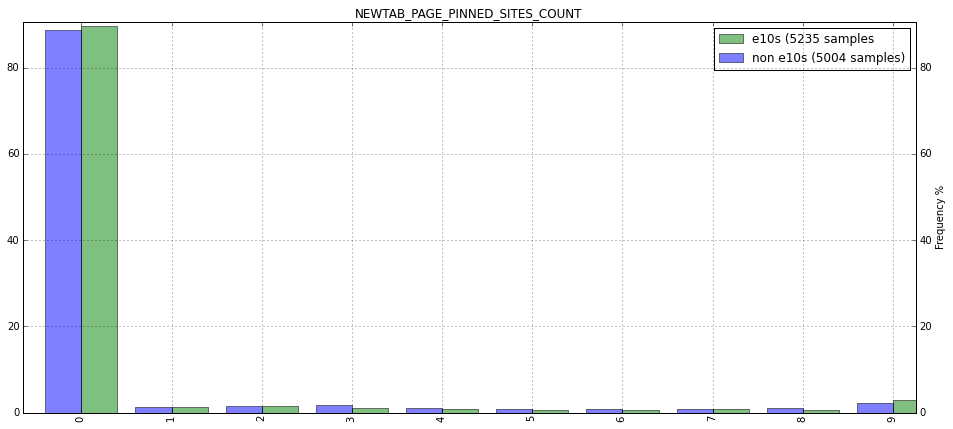

The chi2 distance for IMAGE_DECODE_SPEED_JPEG is 0.00190660178965


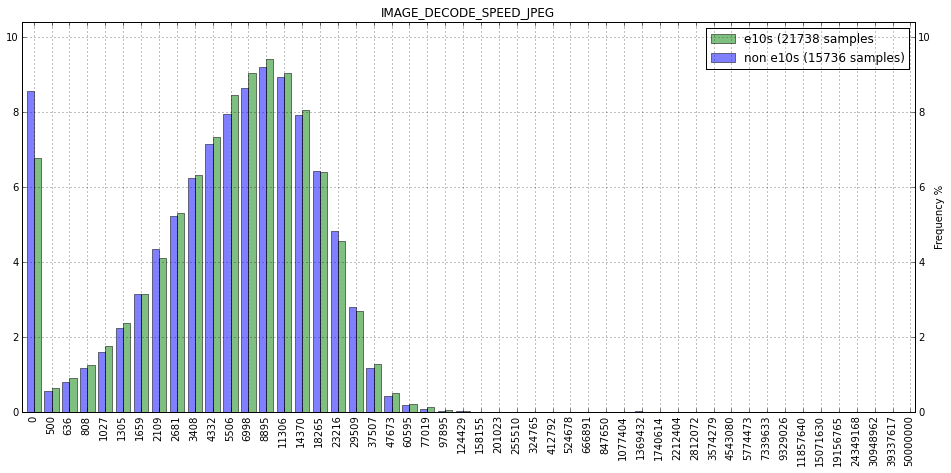

The chi2 distance for TELEMETRY_ARCHIVE_SCAN_PING_COUNT is 0.00187798229627


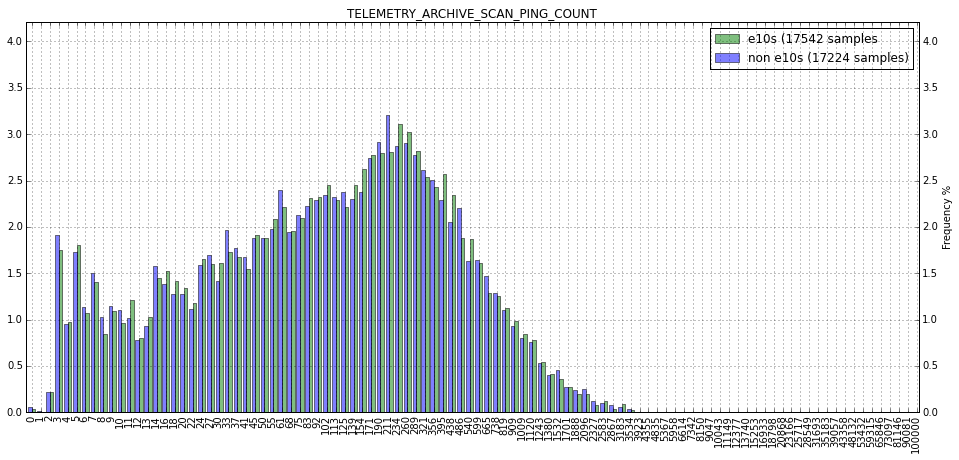

The chi2 distance for A11Y_ISIMPLEDOM_USAGE_FLAG is 0.00187470634229


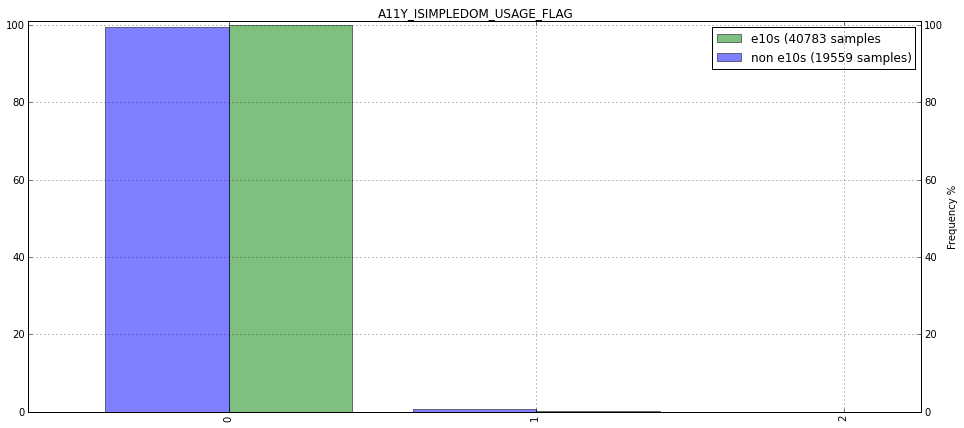

The chi2 distance for IMAGE_DECODE_CHUNKS is 0.00180805747038


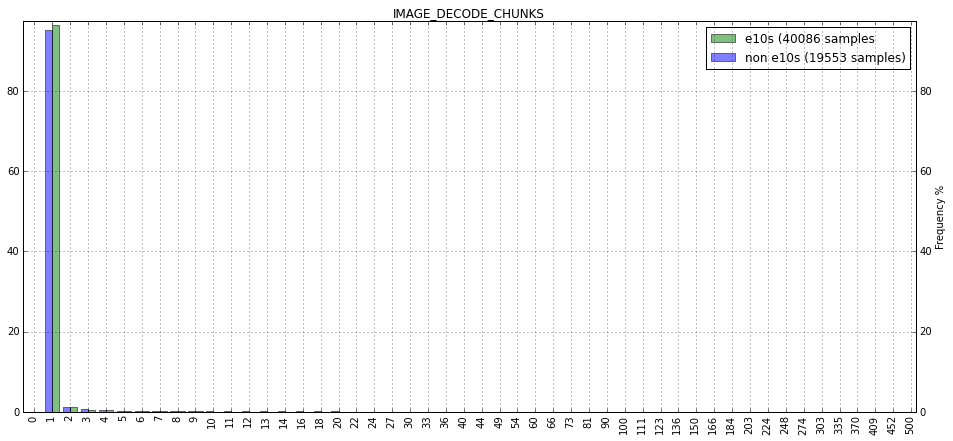

The chi2 distance for PLACES_BOOKMARKS_COUNT is 0.00179648088372


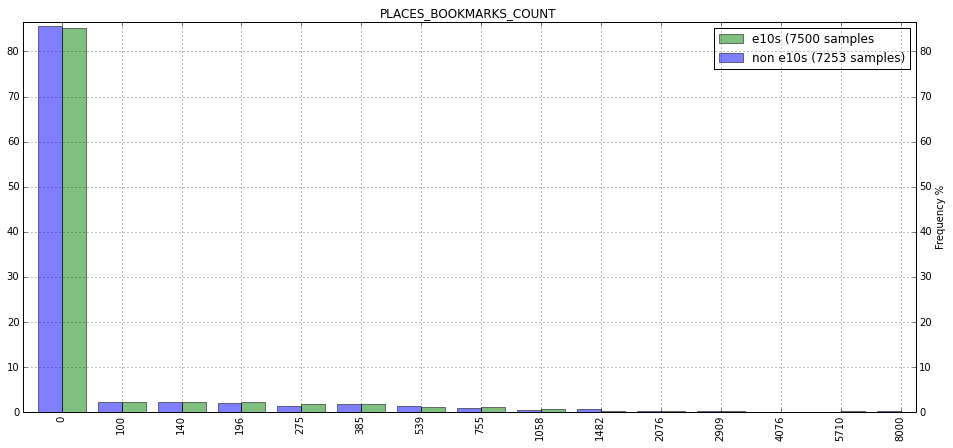

The chi2 distance for [[COUNT]]_SEARCH_COUNTS is 0.00178920978976


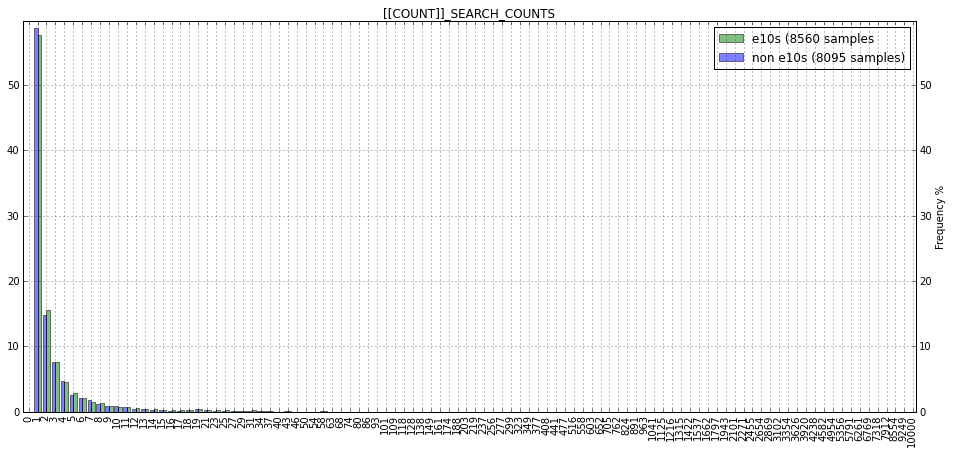

The chi2 distance for PLACES_PAGES_COUNT is 0.00174924293059


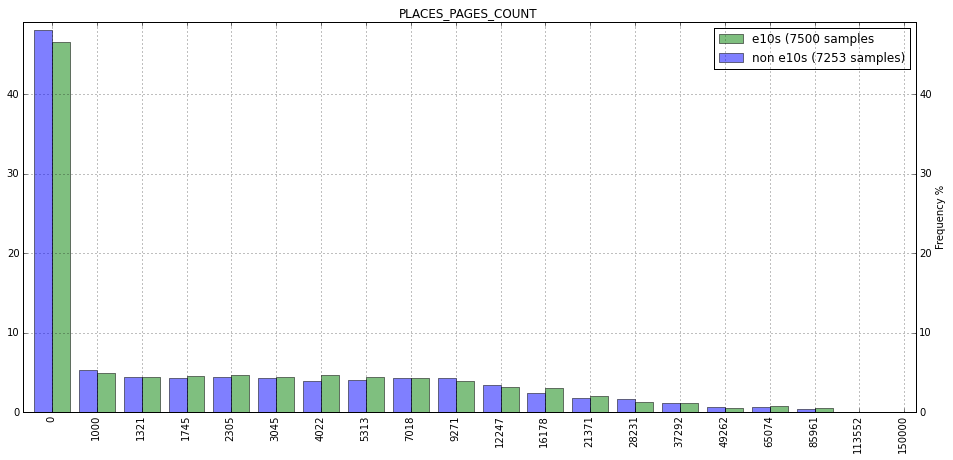

The chi2 distance for STARTUP_CRASH_DETECTED is 0.00172705863408


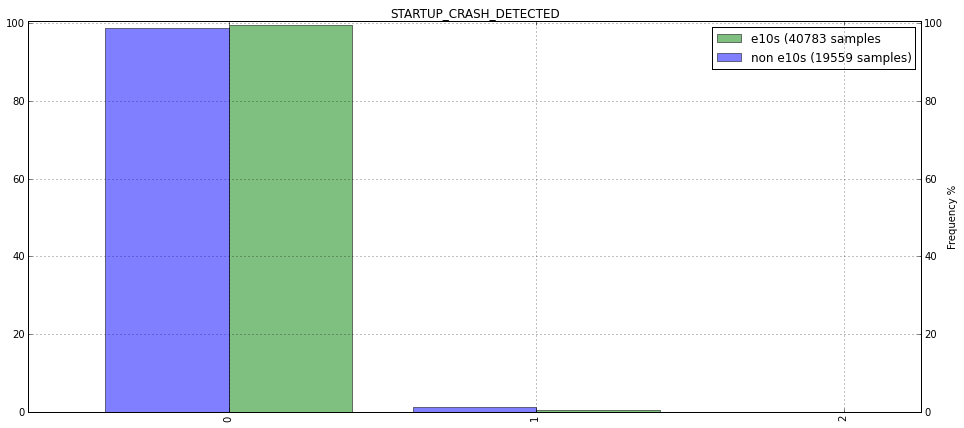

The chi2 distance for SPDY_CHUNK_RECVD is 0.00170895049228


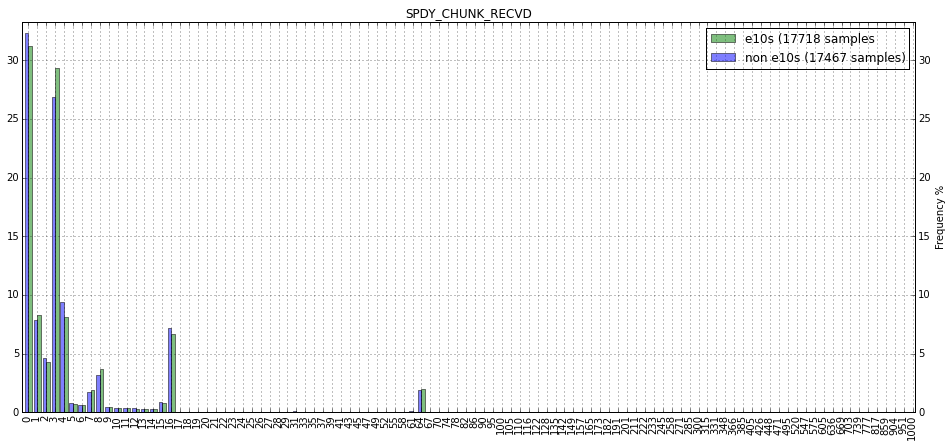

The chi2 distance for CACHE_SERVICE_LOCK_WAIT_2 is 0.00168321791343


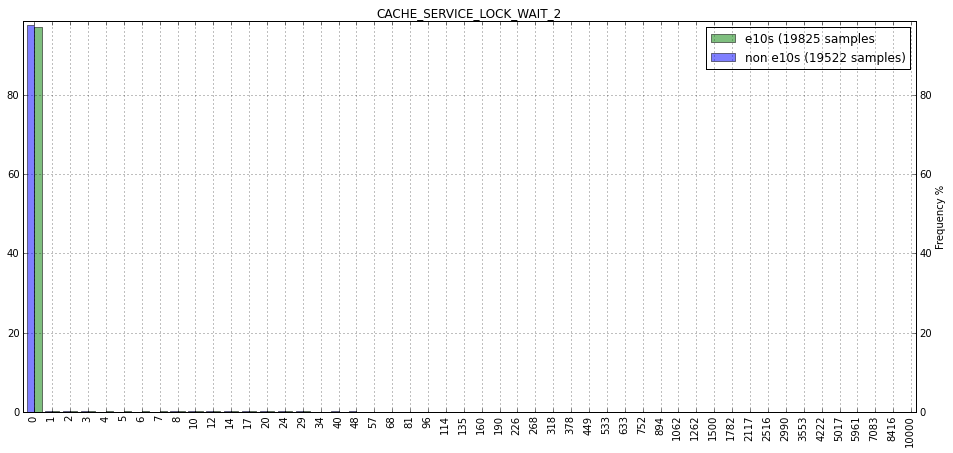

The chi2 distance for SEARCH_SERVICE_INIT_SYNC is 0.00166972519004


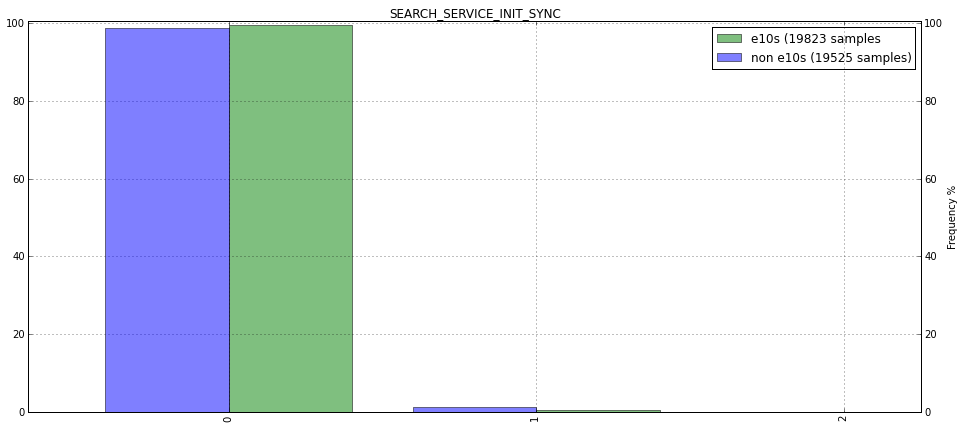

The chi2 distance for PLACES_DATABASE_FILESIZE_MB is 0.00164032534551


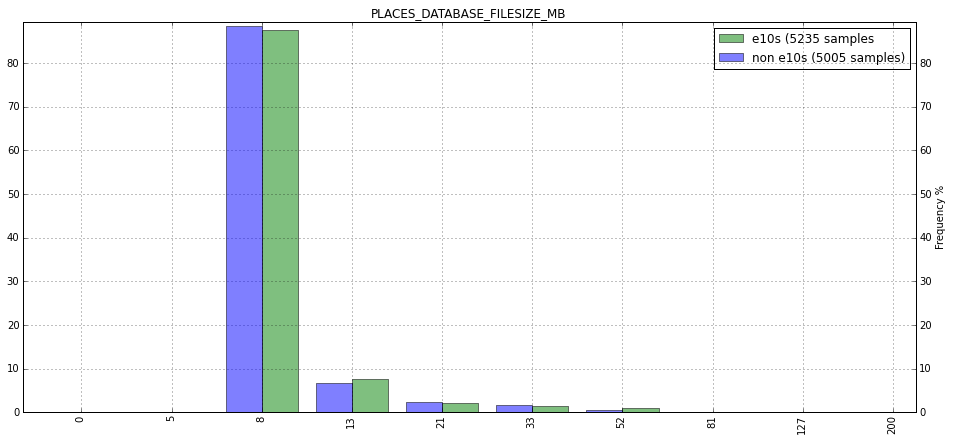

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_REF_COUNTED is 0.00161487775273


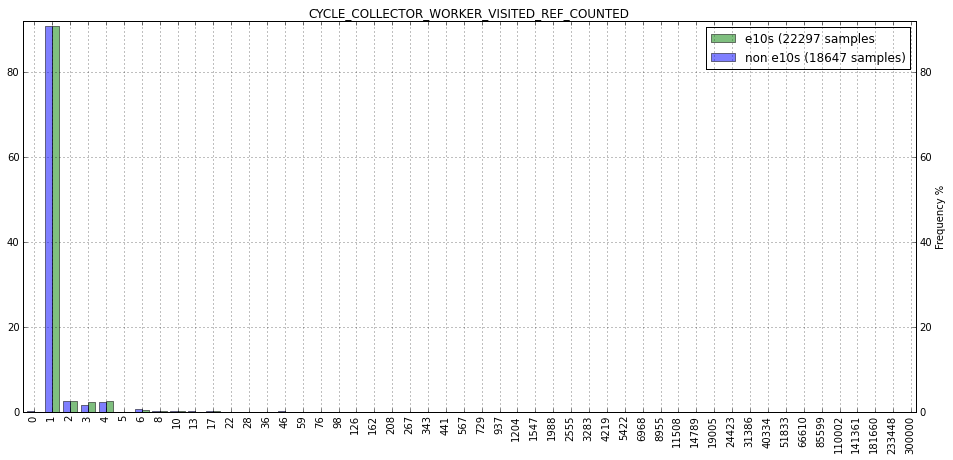

The chi2 distance for TELEMETRY_ARCHIVE_EVICTING_DIRS_MS is 0.00161452924099


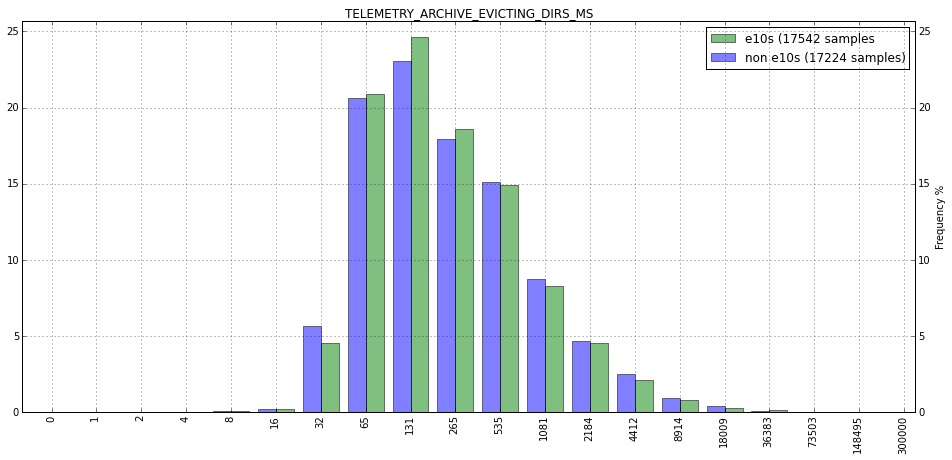

The chi2 distance for YOUTUBE_EMBED_SEEN is 0.00160841653006


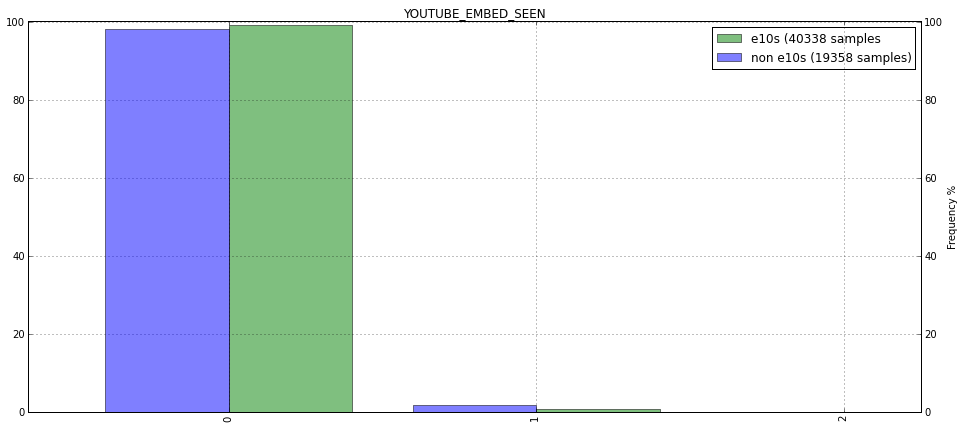

The chi2 distance for HTML_FOREGROUND_REFLOW_MS_2 is 0.00159786284337


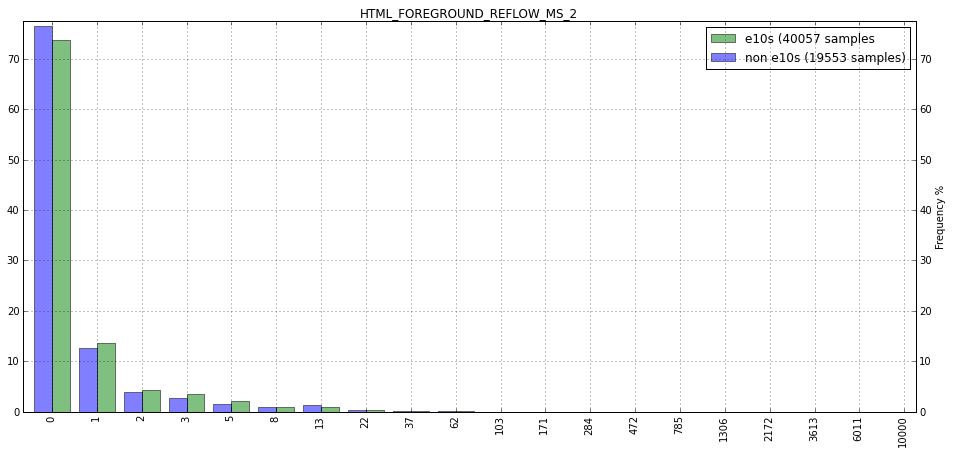

The chi2 distance for PREDICTOR_TOTAL_PRERESOLVES is 0.00159065538176


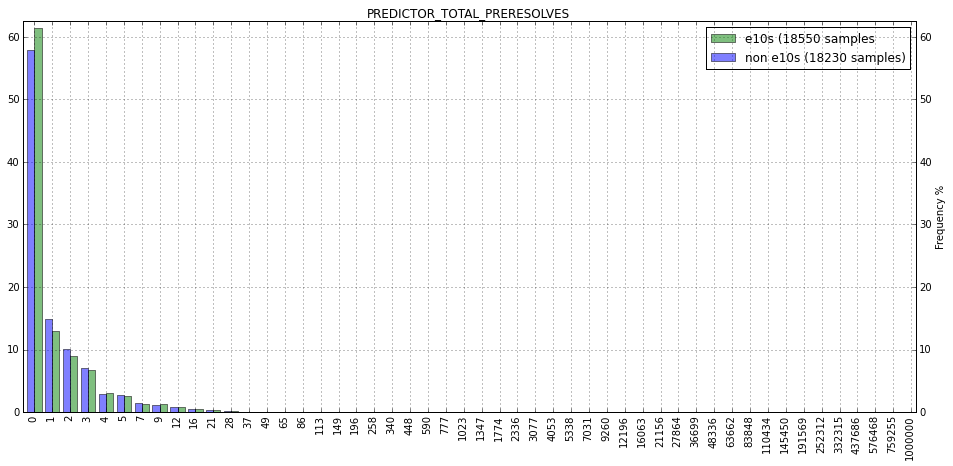

The chi2 distance for DNS_RENEWAL_TIME is 0.00157233499185


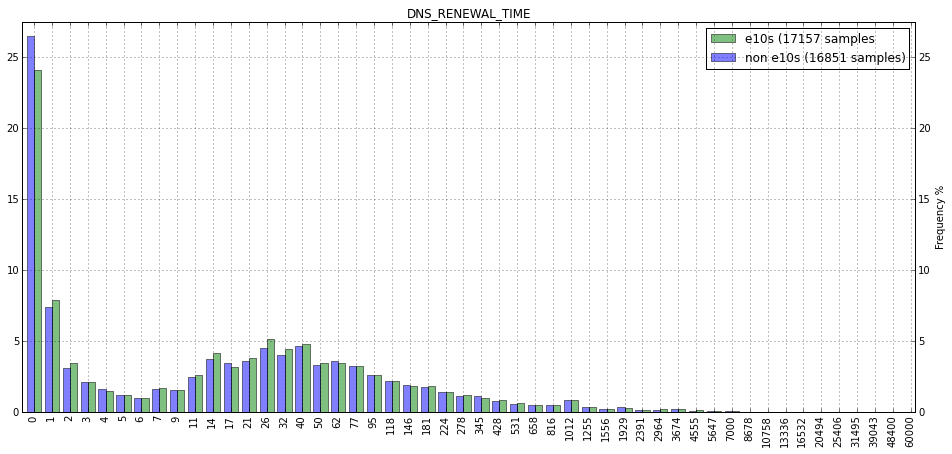

The chi2 distance for SHUTDOWN_PHASE_DURATION_TICKS_PROFILE_CHANGE_TEARDOWN is 0.00156412880151


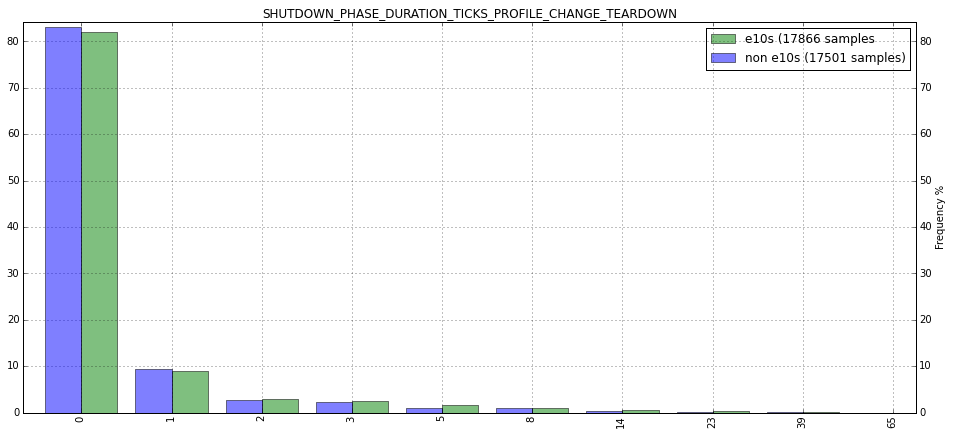

The chi2 distance for UPDATE_LAST_NOTIFY_INTERVAL_DAYS_EXTERNAL is 0.00154141880842


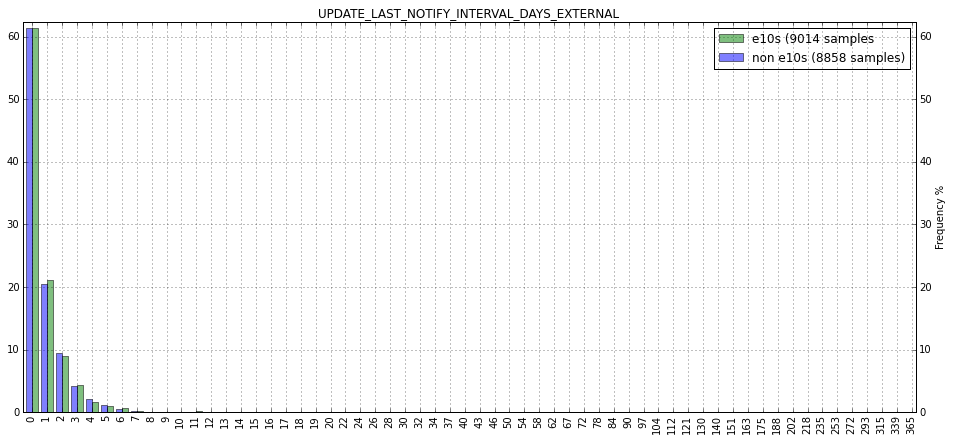

The chi2 distance for IMAGE_DECODE_TIME is 0.001501556487


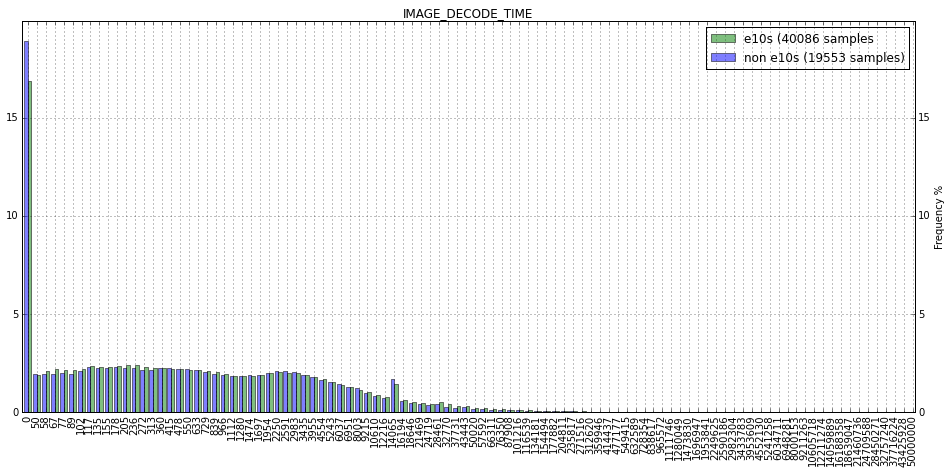

The chi2 distance for SSL_CIPHER_SUITE_RESUMED is 0.00148797410293


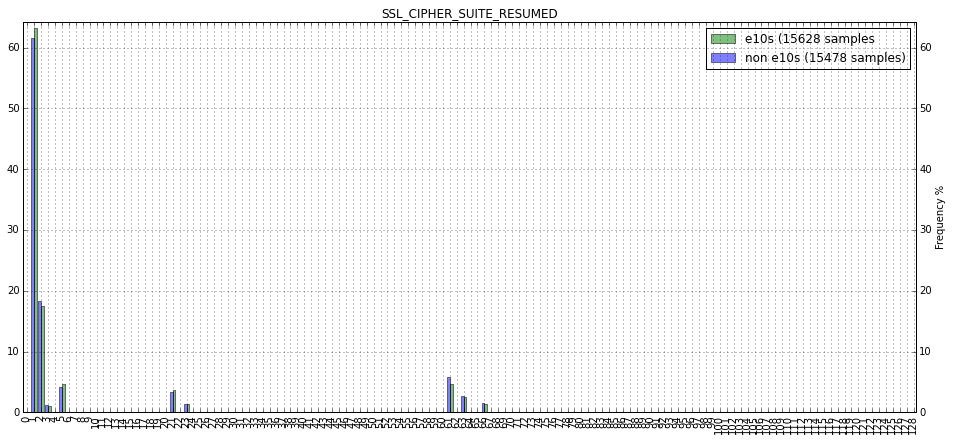

The chi2 distance for WORD_CACHE_HITS_CHROME is 0.0014749971529


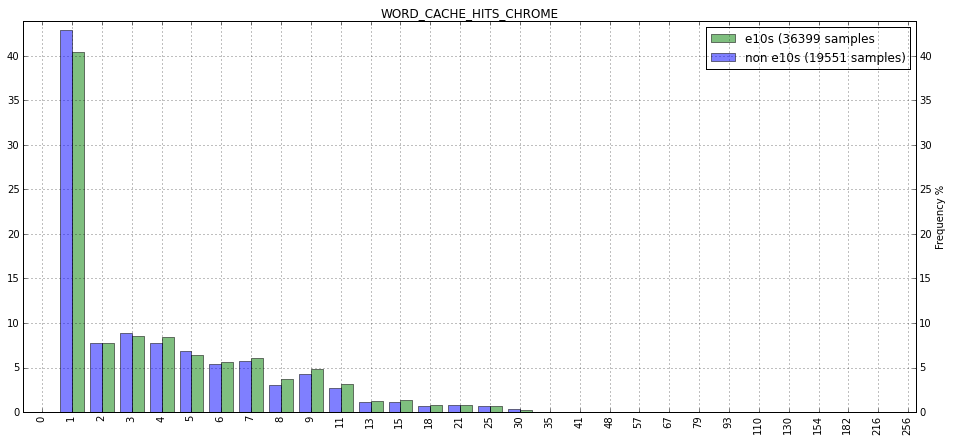

The chi2 distance for CYCLE_COLLECTOR_WORKER is 0.00147395769615


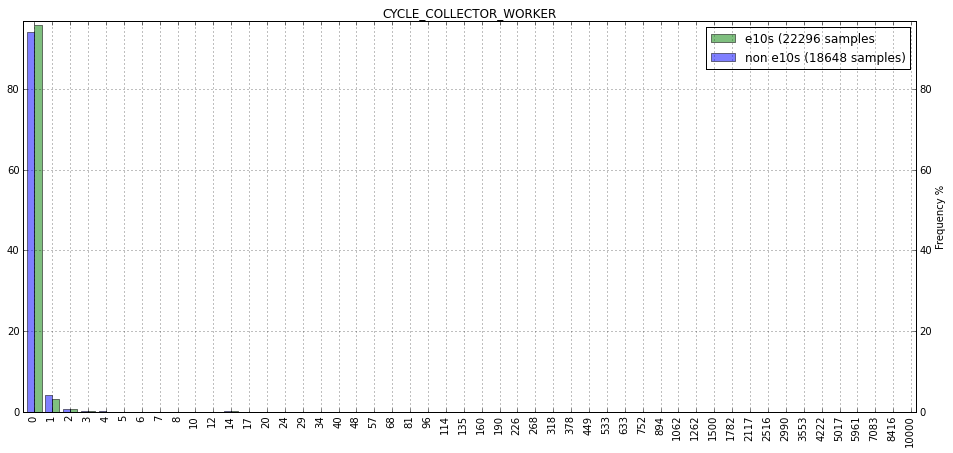

The chi2 distance for OSFILE_WRITEATOMIC_JANK_MS is 0.00141582572983


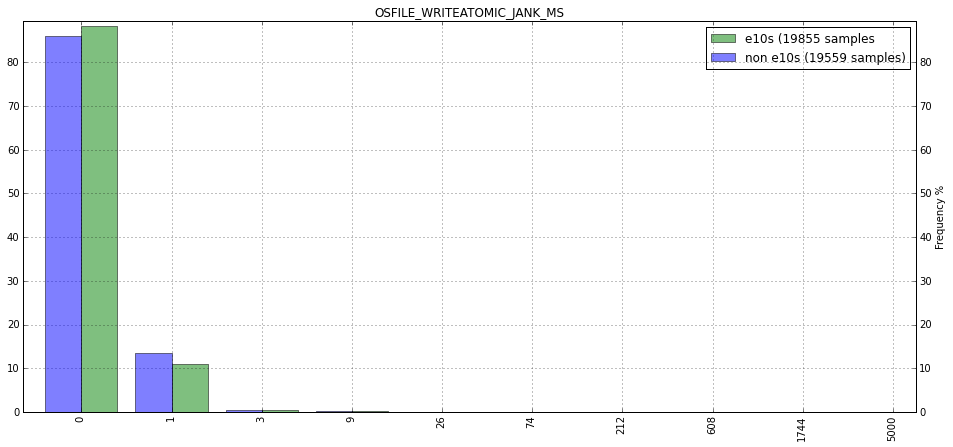

The chi2 distance for MOZ_SQLITE_WEBAPPS_SYNC_MS is 0.0013989326805


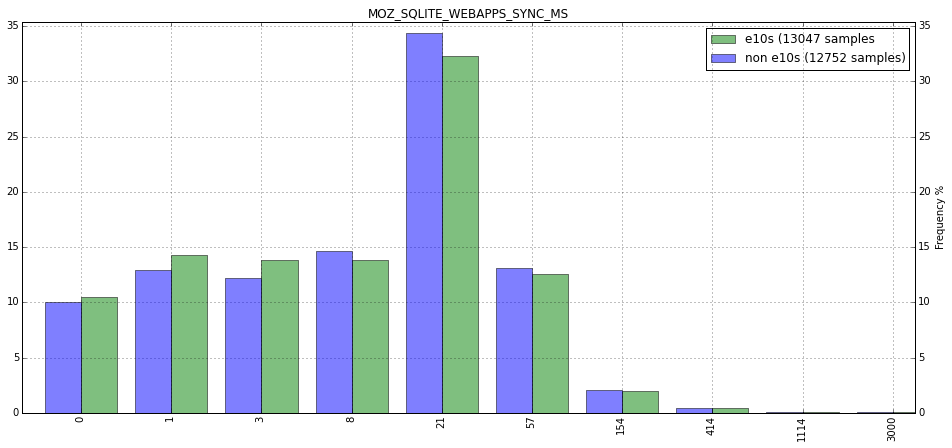

The chi2 distance for LOCALDOMSTORAGE_SHUTDOWN_DATABASE_MS is 0.00139344327534


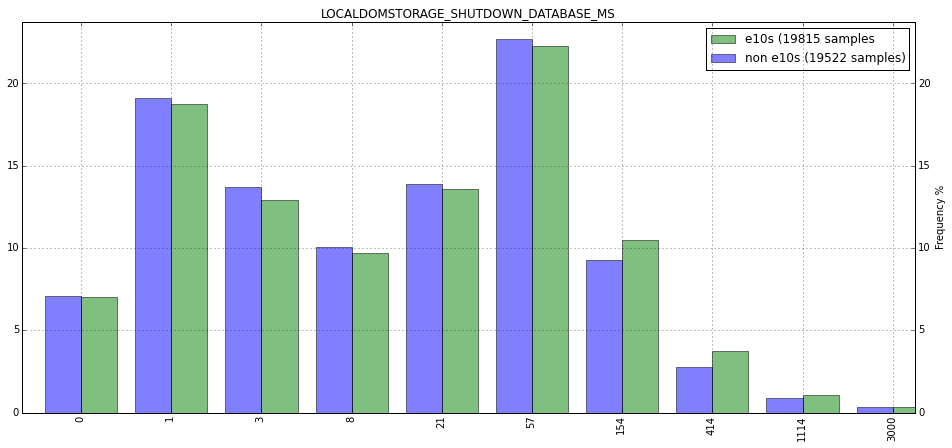

The chi2 distance for DECODER_INSTANTIATED_KOI8R is 0.00139026226412


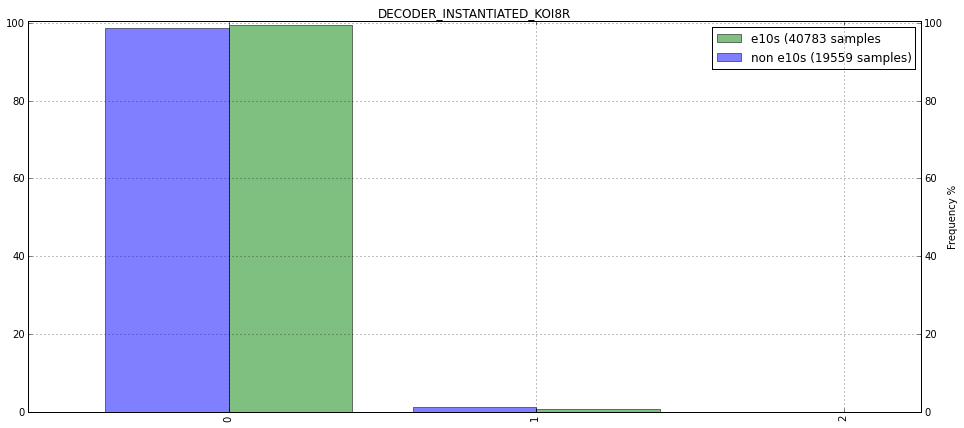

The chi2 distance for SIMPLE_MEASURES_ACTIVETICKS is 0.00138470312245


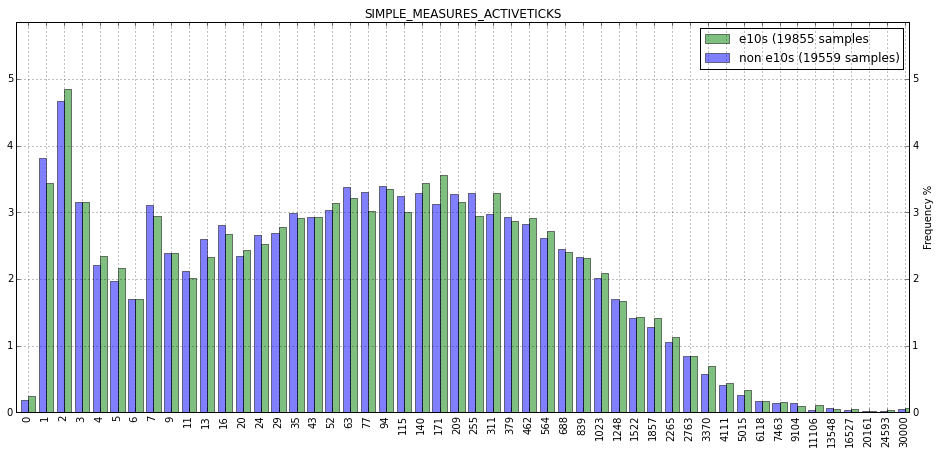

The chi2 distance for STARTUP_WORD_CACHE_HITS_CHROME is 0.00134438695915


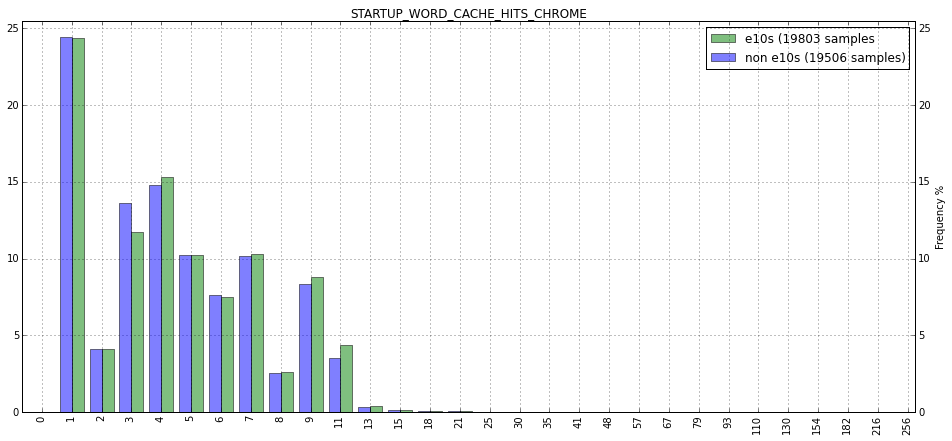

The chi2 distance for SIMPLE_MEASURES_AFTERPROFILELOCKED is 0.00132356780377


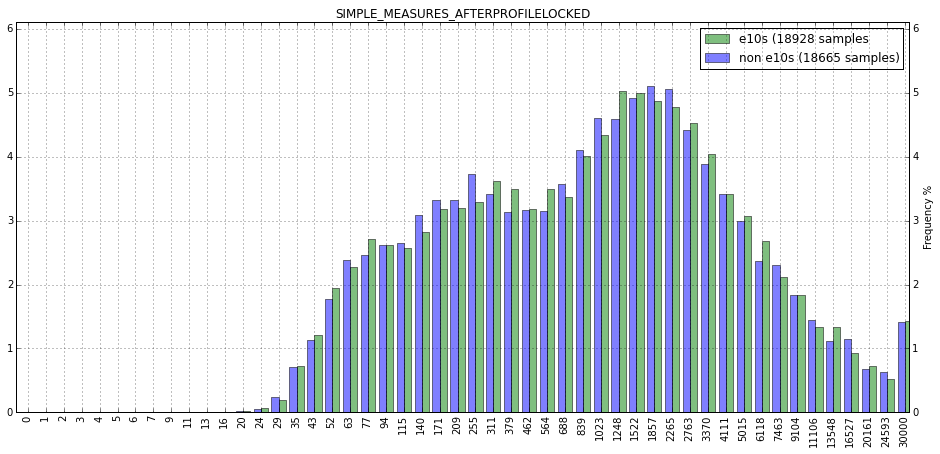

The chi2 distance for SIMPLE_MEASURES_MAIN is 0.00132016475579


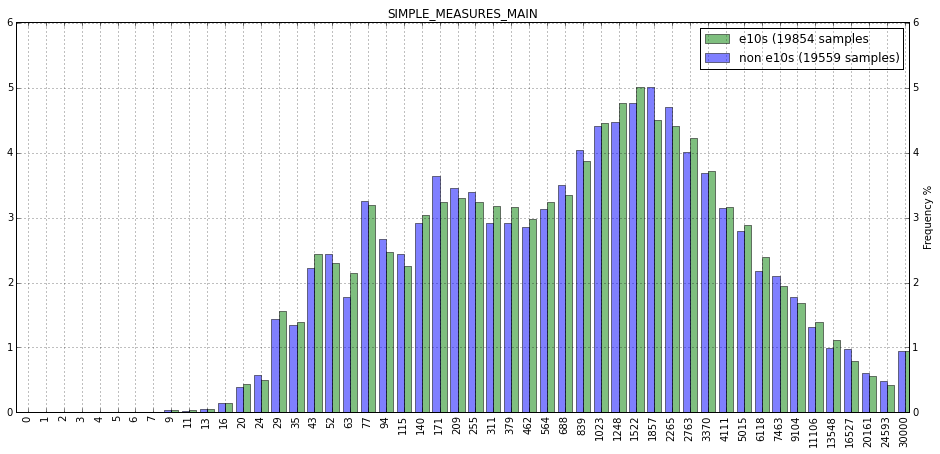

The chi2 distance for HEALTHREPORT_UPLOAD_MS is 0.00131033912322


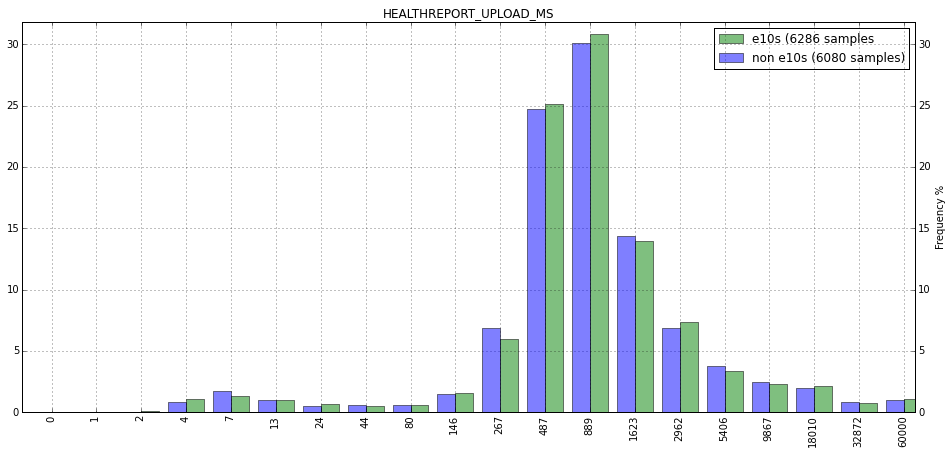

The chi2 distance for VIDEO_DECODED_H264_SPS_PROFILE is 0.00129922065703


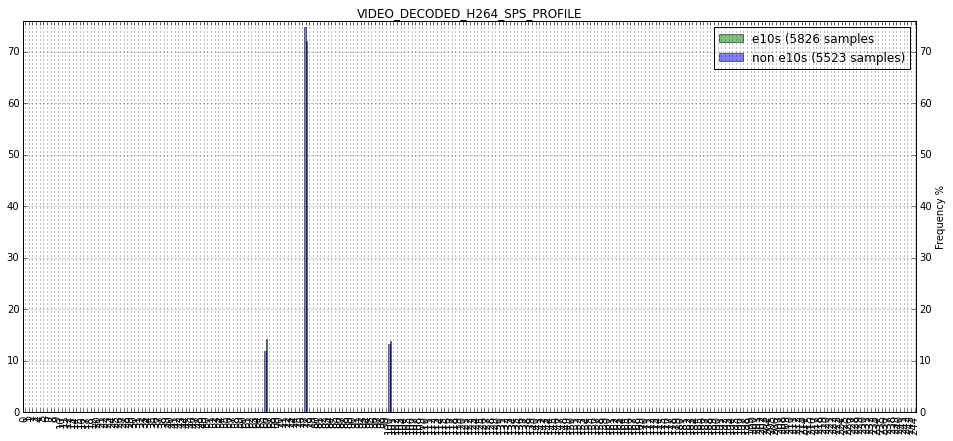

The chi2 distance for HEALTHREPORT_COLLECT_DAILY_MS is 0.00126868725336


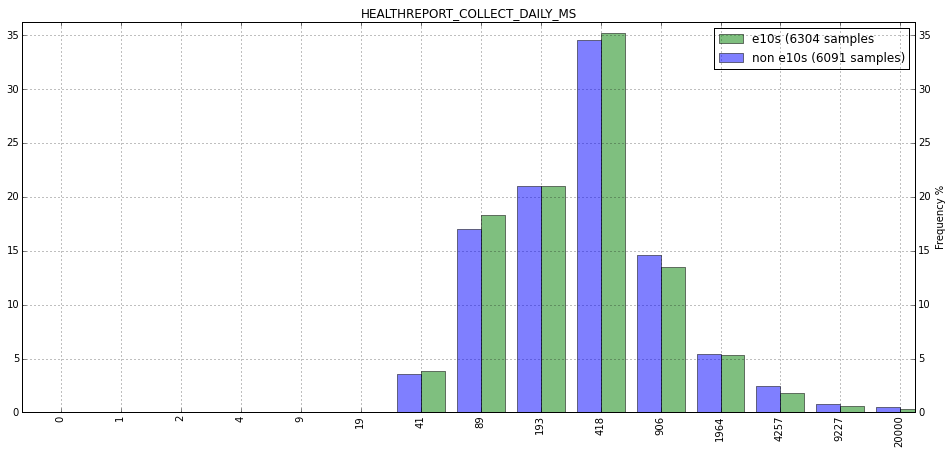

The chi2 distance for HEALTHREPORT_PAYLOAD_UNCOMPRESSED_BYTES is 0.00125803143715


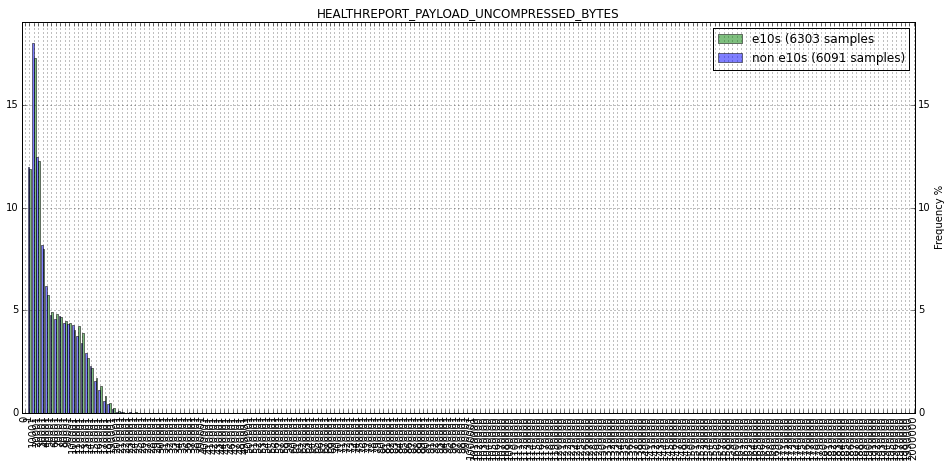

The chi2 distance for VIDEO_DECODED_H264_SPS_CONSTRAINT_SET_FLAG is 0.00122285546111


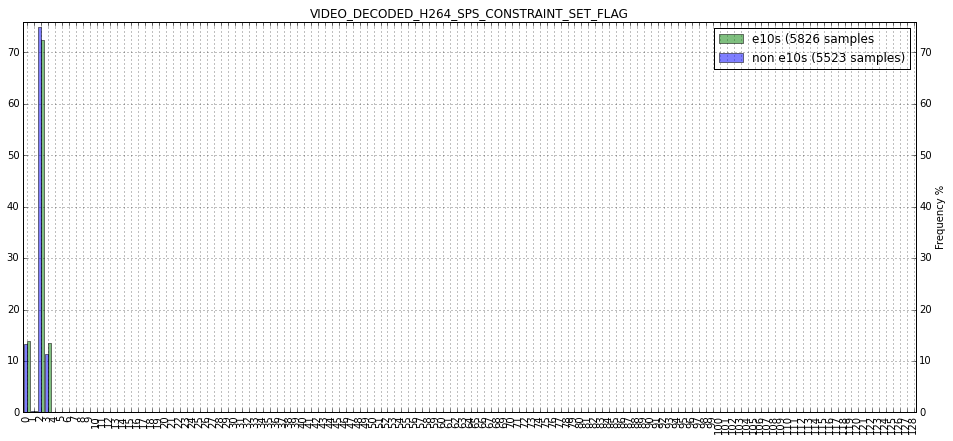

The chi2 distance for SIMPLE_MEASURES_TOTALTIME is 0.00122145819445


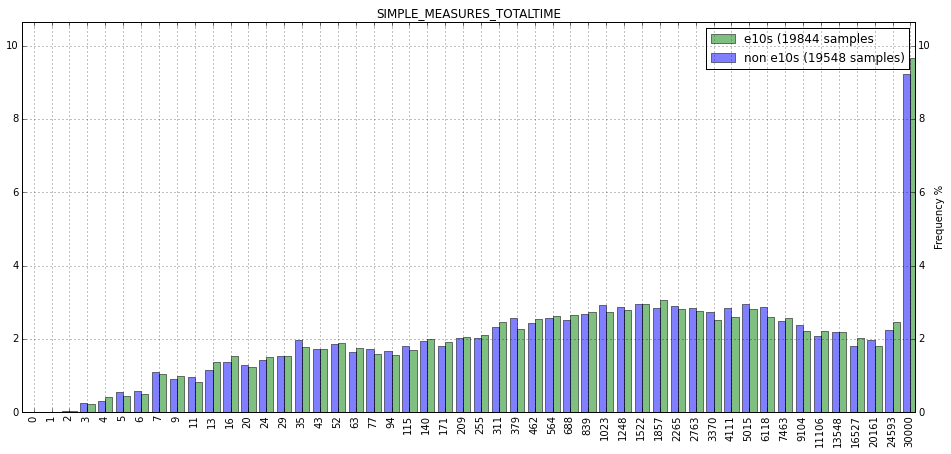

The chi2 distance for PREDICTOR_TOTAL_PRECONNECTS is 0.00121220455423


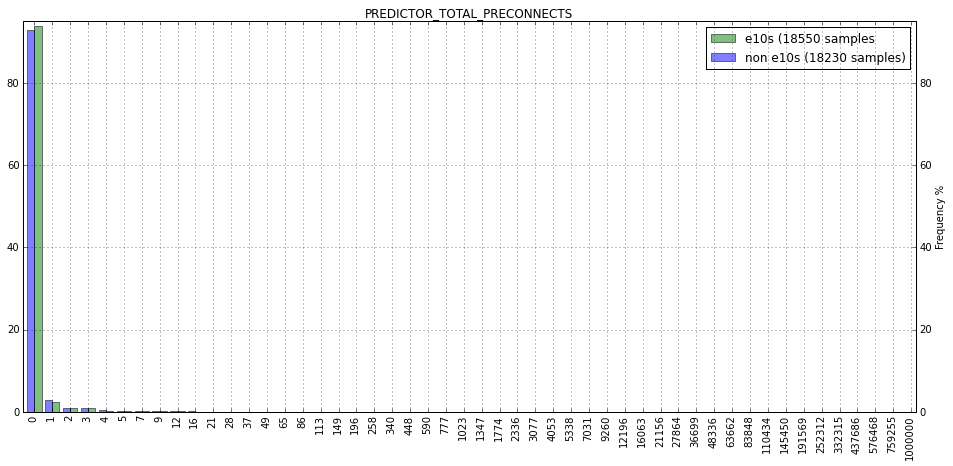

The chi2 distance for SIMPLE_MEASURES_SHUTDOWNDURATION is 0.00119950803833


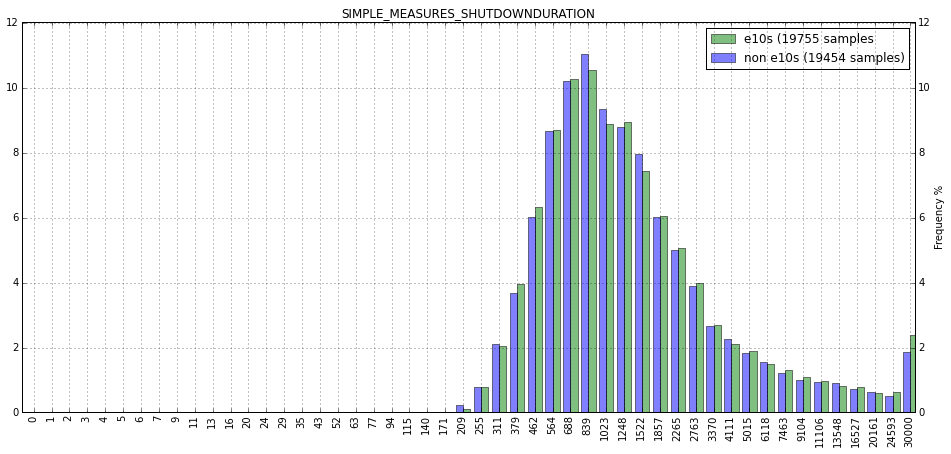

The chi2 distance for SIMPLE_MEASURES_SELECTPROFILE is 0.00118764766956


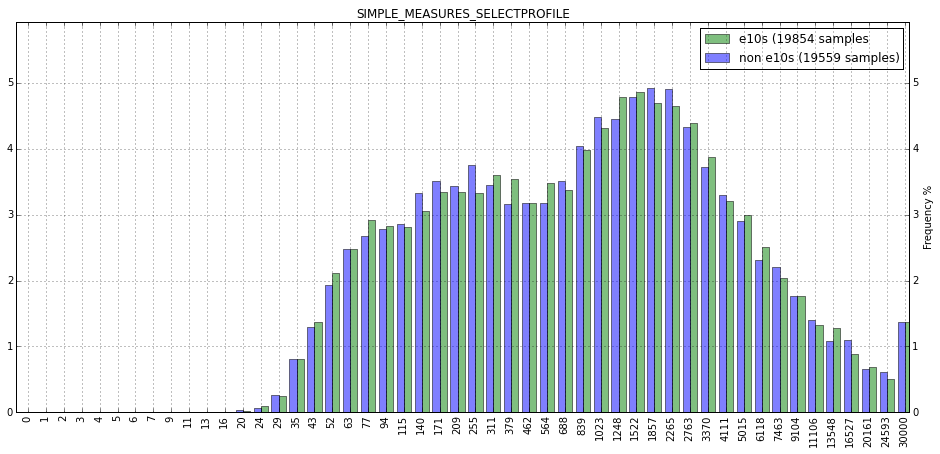

The chi2 distance for FX_SESSION_RESTORE_CONTENT_COLLECT_DATA_LONGEST_OP_MS is 0.00118466323664


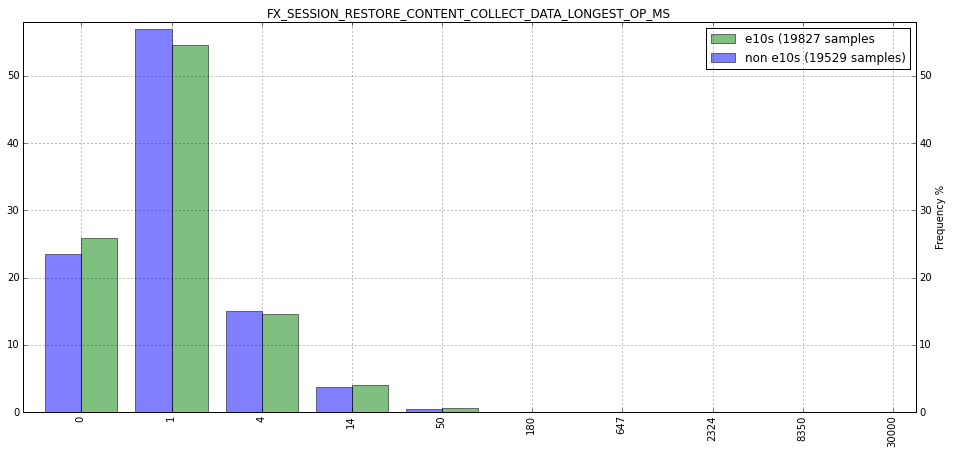

The chi2 distance for STARTUP_WORD_CACHE_MISSES_CHROME is 0.00113053927198


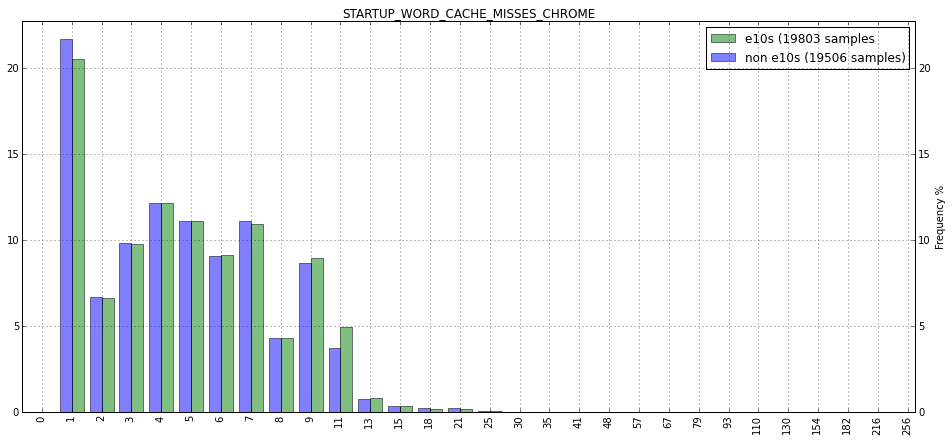

The chi2 distance for SIMPLE_MEASURES_UPTIME is 0.00108749379316


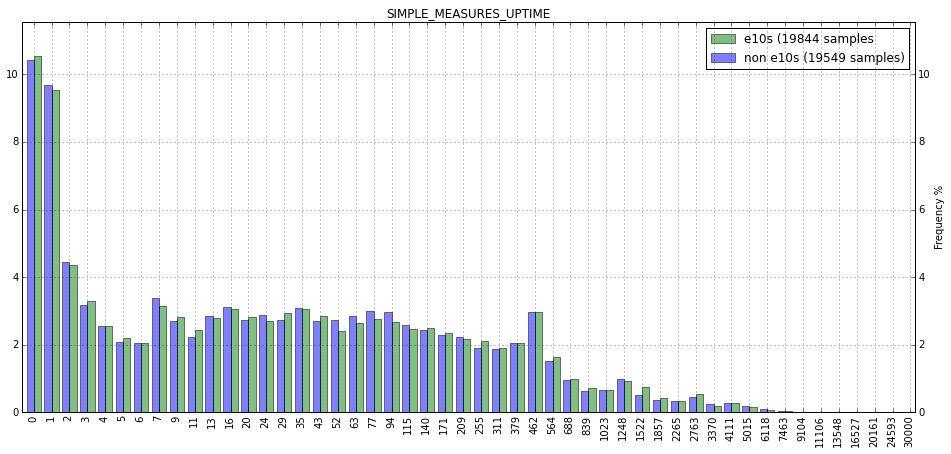

The chi2 distance for CERT_VALIDATION_SUCCESS_BY_CA is 0.00108252250125


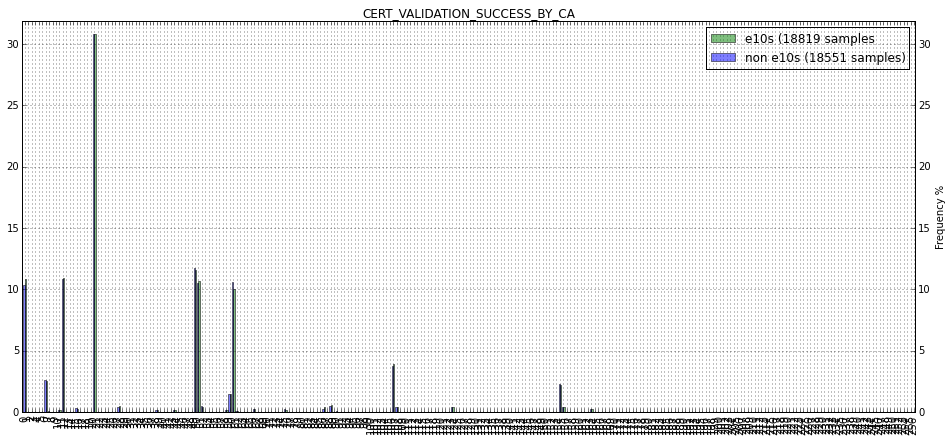

The chi2 distance for PLACES_IDLE_FRECENCY_DECAY_TIME_MS is 0.00106966698014


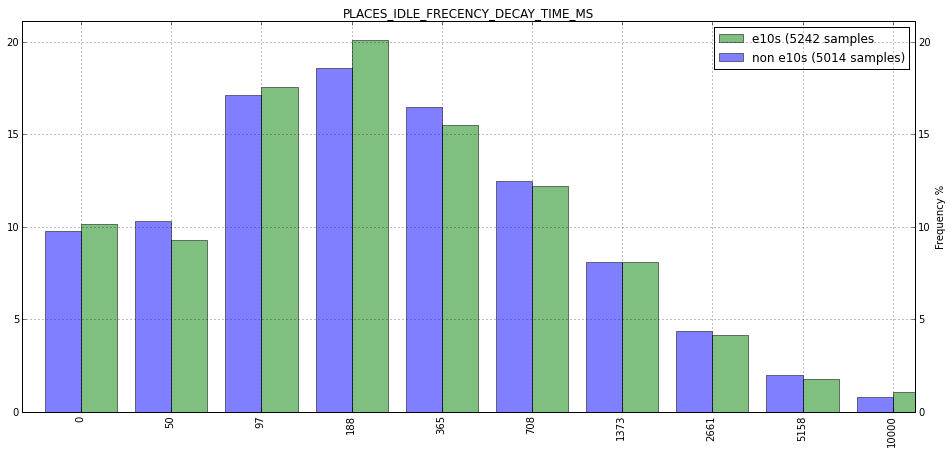

The chi2 distance for PLACES_SORTED_BOOKMARKS_PERC is 0.00106588968055


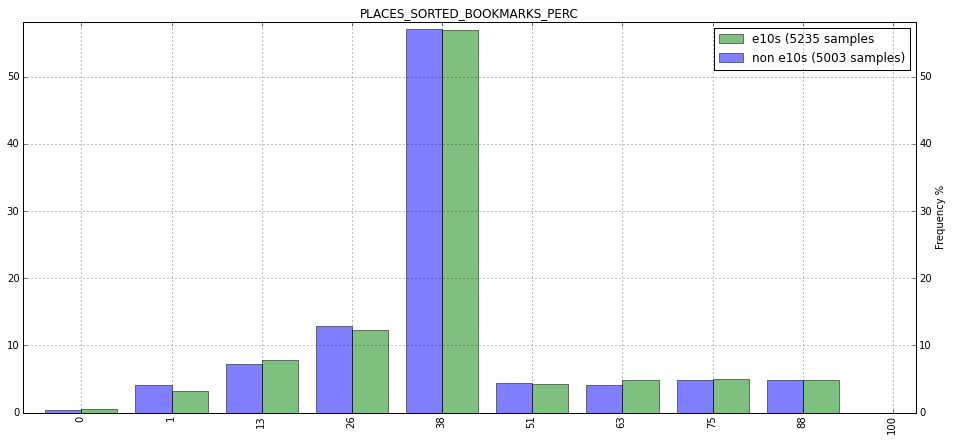

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COUNT is 0.0010527239204


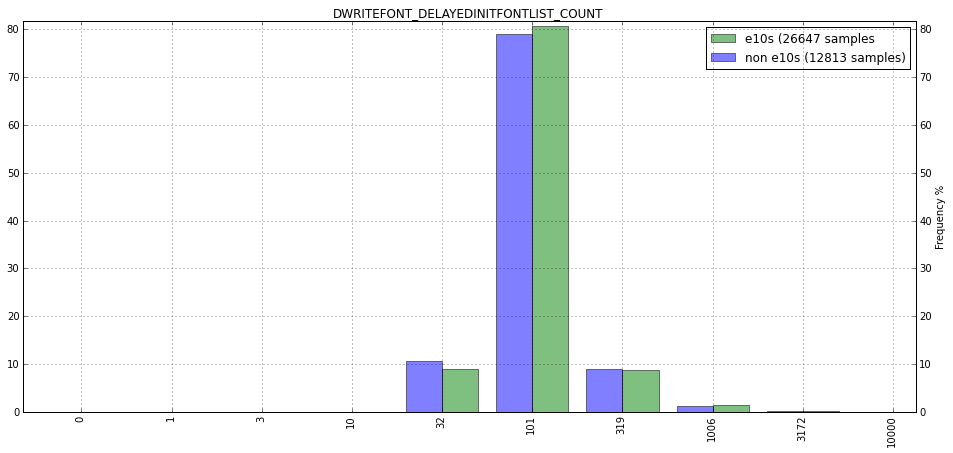

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_SIZE is 0.00103596135693


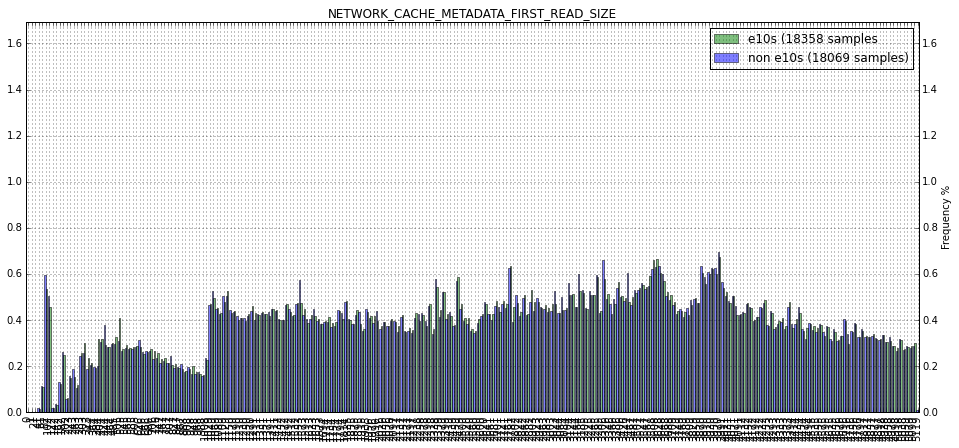

The chi2 distance for DECODER_INSTANTIATED_ISO_8859_5 is 0.00103166437706


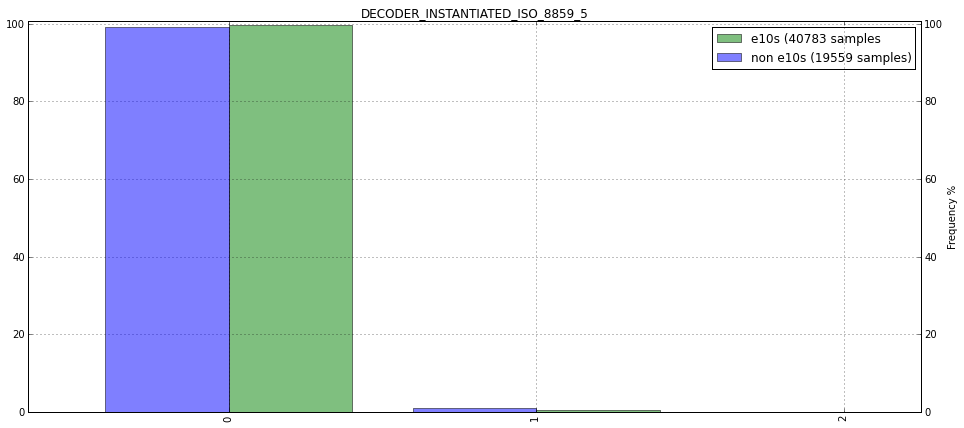

The chi2 distance for SPDY_SYN_SIZE is 0.00102496401983


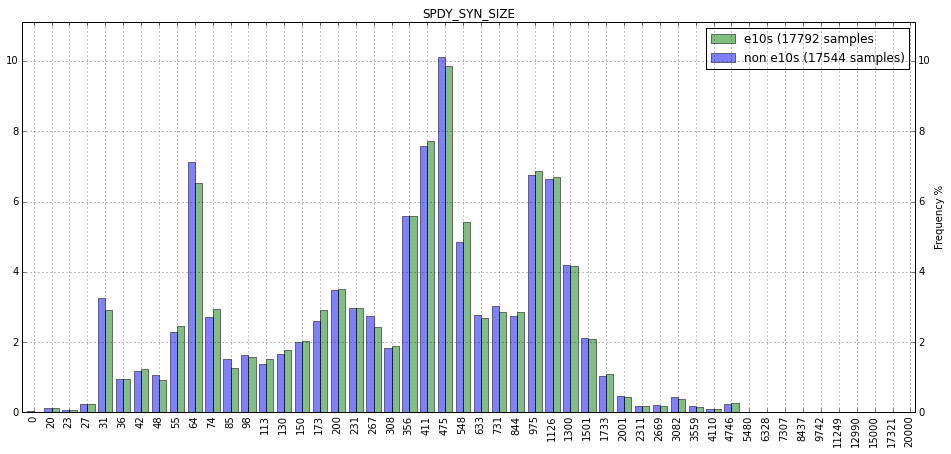

The chi2 distance for PLACES_DATABASE_SIZE_PER_PAGE_B is 0.001016326632


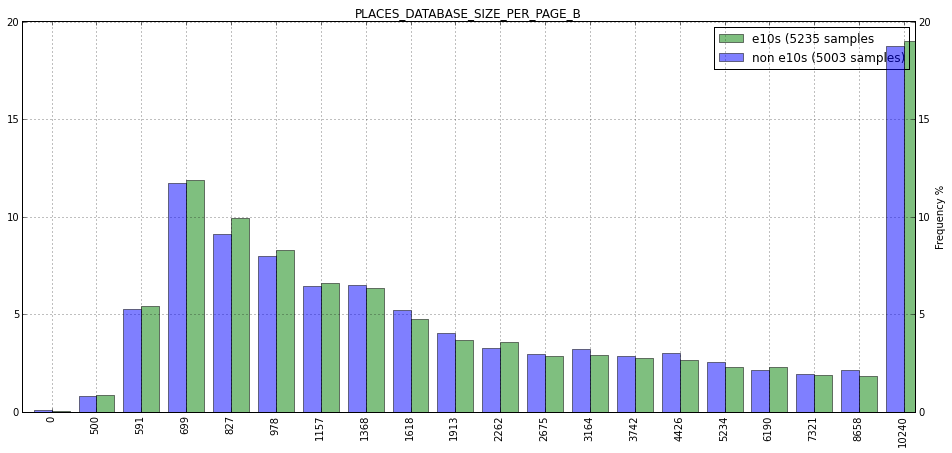

In [21]:
keys.sort(key=lambda key: chi2_distance(aggregates[0][key]["histogram"], aggregates[1][key]["histogram"]), reverse=True)

for key in keys:
    compare_histogram(key, aggregates[1][key], aggregates[0][key])    